<h1 style="text-align:center;">Data Science & Society Thesis</h1>
<h3 style="text-align:center;">FORECASTING CRYPTO PRICE  PEAKS: REGRESSION – BASED </h3>
<h3 style="text-align:center;">TIME – UNTIL – NEW - HIGH </h3>
<h3 style="text-align:center;">PREDICTIONS</h3>
<h5 style="text-align:center;"> ELEFTHERIOS DIAMANTIDIS</h5>

---

# **RQ 1:** ML Model Comparison

## <span style='color:brown'>**Stage A:** Preprocessing</span>

### **Step 1:** Import Libraries

In [1]:
# Import Basic Libraries
# type: ignore
import pandas as pd
import numpy as np
import matplotlib.pylab as plt   
import matplotlib.dates as mdates                                                            
import seaborn as sns                                                                        
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Prevent line-wrapping

import statsmodels.api as sm
from collections import Counter
from scipy.stats import randint, uniform, loguniform

import shap

from plot_results import plot_log_results, plot_results

# Import Libraries for Time Series Analysis
from tsfresh import extract_features, select_features                                        
from tsfresh.utilities.dataframe_functions import roll_time_series, impute                   

# Import Libraries for Machine Learning
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score          
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit                      
from sklearn.preprocessing import StandardScaler, RobustScaler                 
from sklearn.svm import SVR                                                                  
from sklearn.ensemble import RandomForestRegressor         
from quantile_forest import RandomForestQuantileRegressor
from xgboost import XGBRegressor
                                                                        

# Import Libraries for Deep Learning
from tensorflow.keras.models import Sequential, Model                                               
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam                                                 
from scikeras.wrappers import KerasRegressor                                                                       
from keras_tuner import RandomSearch   
from tensorflow.keras.optimizers import Nadam                                               
from keras.callbacks import EarlyStopping      
import kerastuner as kt  
from keras.regularizers import l2

### **Step 2:** Import data

In [2]:
df_btc = pd.read_csv("data/final_data_btc.csv")
df_btc['coin'] = 'BTC'
df_btc = df_btc.rename(columns={"Date":"date"})
df_btc["date"] = pd.to_datetime(df_btc["date"])
df_btc['Date'] = df_btc['date'].dt.date
df_btc['date'] = df_btc['date'].dt.date
df_btc = df_btc.set_index('Date')
print(df_btc.head())

                  date    Open    High     Low   Close  Volume  tunh coin
Date                                                                     
2010-07-17  2010-07-17  0.0500  0.0500  0.0500  0.0500     0.0   1.0  BTC
2010-07-18  2010-07-18  0.0858  0.0858  0.0858  0.0858     0.0  82.0  BTC
2010-07-19  2010-07-19  0.0808  0.0808  0.0808  0.0808     0.0  81.0  BTC
2010-07-20  2010-07-20  0.0747  0.0747  0.0747  0.0747     0.0   1.0  BTC
2010-07-21  2010-07-21  0.0792  0.0792  0.0792  0.0792     0.0  79.0  BTC


In [3]:
df_btc.shape

(5381, 8)

### **Step 3:** Handle missing data & outliers

In [4]:
df_btc.isna().sum()

date       0
Open       0
High       0
Low        0
Close      0
Volume     0
tunh      26
coin       0
dtype: int64

In [5]:
df_btc['tunh'] = df_btc['tunh'].ffill().bfill()

In [6]:
df_btc.isna().sum()

date      0
Open      0
High      0
Low       0
Close     0
Volume    0
tunh      0
coin      0
dtype: int64

In [7]:
upper_limit = df_btc['tunh'].quantile(0.99)
df_btc['tunh_outlier'] = df_btc['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_btc['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_btc):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

Detected 54 outliers (1.00%) above the 99th percentile (710.20 days).


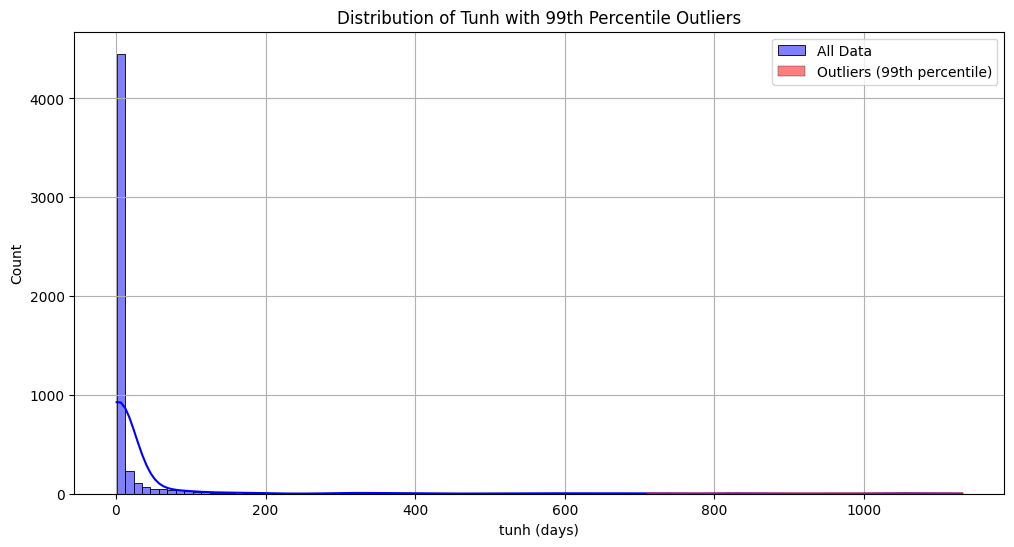

In [8]:
plt.figure(figsize=(12, 6))
sns.histplot(df_btc['tunh'], bins=100, kde=True, color='blue', label='All Data')
sns.histplot(df_btc[df_btc['tunh_outlier']]['tunh'], bins=100, kde=True, color='red', label='Outliers (99th percentile)')
plt.xlabel("tunh (days)")
plt.title("Distribution of Tunh with 99th Percentile Outliers")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
df_btc = df_btc[~df_btc['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_btc.shape}")
df_btc.drop(columns=['tunh_outlier'], inplace=True)

Final data shape after outlier removal: (5327, 9)


### **Step 4:** Log-transform target

In [10]:
df_btc['tunh_log'] = np.log1p(df_btc['tunh'])
print(df_btc.head())

                  date    Open    High     Low   Close  Volume  tunh coin  tunh_log
Date                                                                               
2010-07-17  2010-07-17  0.0500  0.0500  0.0500  0.0500     0.0   1.0  BTC  0.693147
2010-07-18  2010-07-18  0.0858  0.0858  0.0858  0.0858     0.0  82.0  BTC  4.418841
2010-07-19  2010-07-19  0.0808  0.0808  0.0808  0.0808     0.0  81.0  BTC  4.406719
2010-07-20  2010-07-20  0.0747  0.0747  0.0747  0.0747     0.0   1.0  BTC  0.693147
2010-07-21  2010-07-21  0.0792  0.0792  0.0792  0.0792     0.0  79.0  BTC  4.382027


### **Step 5:** Plots

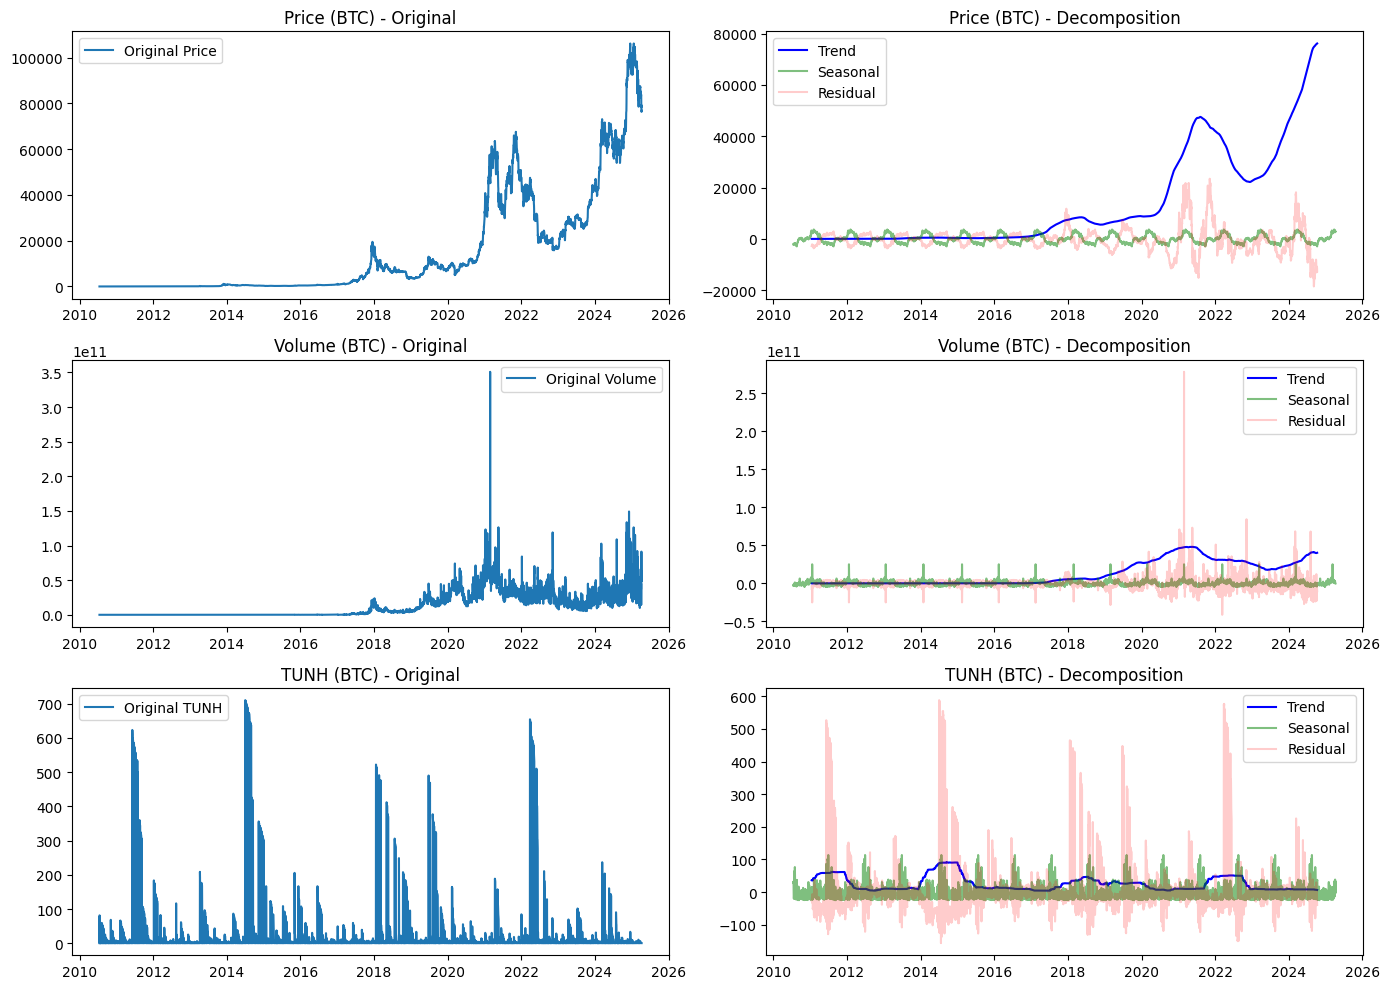

In [11]:
# Decompose the time series for 'Close', 'Volume', and 'tunh'
decomposition_price = sm.tsa.seasonal_decompose(df_btc['Close'], model='additive', period=365)
decomposition_volume = sm.tsa.seasonal_decompose(df_btc['Volume'], model='additive', period=365)
decomposition_tunh = sm.tsa.seasonal_decompose(df_btc['tunh'], model='additive', period=365)

# Create the subplots for Price, Volume, and TUNH
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Price (Close)
axes[0, 0].plot(df_btc['Close'], label='Original Price')
axes[0, 0].set_title('Price (BTC) - Original')
axes[0, 0].legend()

axes[0, 1].plot(decomposition_price.trend, label='Trend', color='blue')
axes[0, 1].plot(decomposition_price.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[0, 1].plot(decomposition_price.resid, label='Residual', color='red', alpha=0.2)
axes[0, 1].set_title('Price (BTC) - Decomposition')
axes[0, 1].legend()

# Volume
axes[1, 0].plot(df_btc['Volume'], label='Original Volume')
axes[1, 0].set_title('Volume (BTC) - Original')
axes[1, 0].legend()

axes[1, 1].plot(decomposition_volume.trend, label='Trend', color='blue')
axes[1, 1].plot(decomposition_volume.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[1, 1].plot(decomposition_volume.resid, label='Residual', color='red', alpha=0.2)
axes[1, 1].set_title('Volume (BTC) - Decomposition')
axes[1, 1].legend()

# TUNH
axes[2, 0].plot(df_btc['tunh'], label='Original TUNH')
axes[2, 0].set_title('TUNH (BTC) - Original')
axes[2, 0].legend()

axes[2, 1].plot(decomposition_tunh.trend, label='Trend', color='blue')
axes[2, 1].plot(decomposition_tunh.seasonal, label='Seasonal', color='green', alpha=0.5)
axes[2, 1].plot(decomposition_tunh.resid, label='Residual', color='red', alpha=0.2)
axes[2, 1].set_title('TUNH (BTC) - Decomposition')
axes[2, 1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

fig.savefig('Plots/1. time_series_plots/1. decomposition_btc.png', dpi=300, bbox_inches='tight')

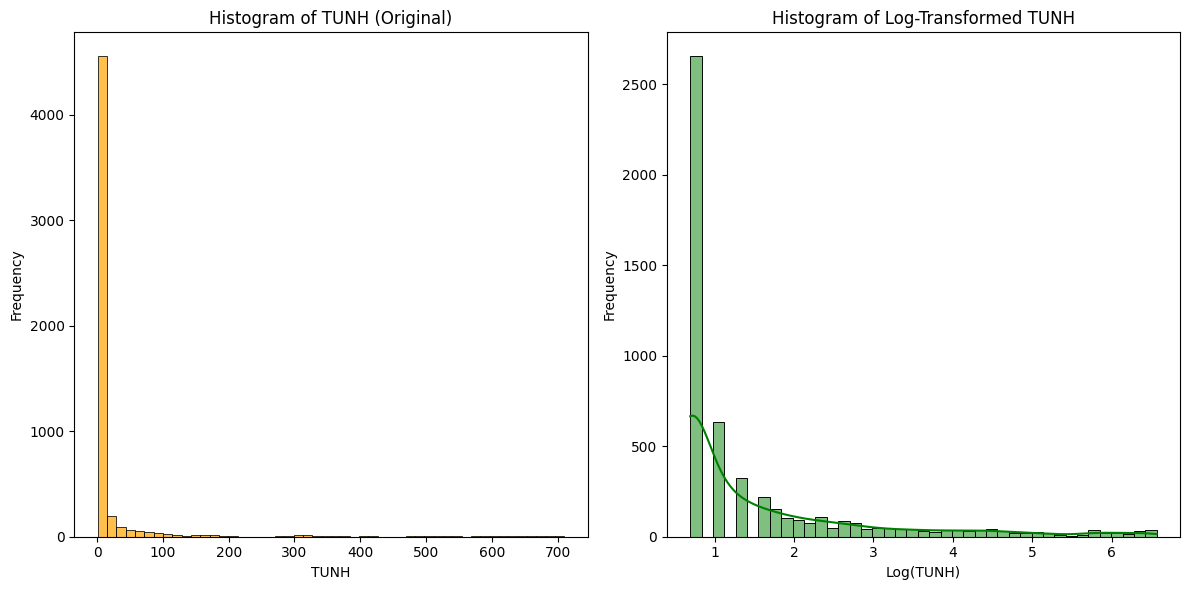

In [12]:
plt.figure(figsize=(12, 6))

# Plot original TUNH histogram
plt.subplot(1, 2, 1)
sns.histplot(df_btc['tunh'], bins=50, color='orange', edgecolor="black", alpha=0.7)  # default Matplotlib colours
plt.title('Histogram of TUNH (Original)')
plt.xlabel('TUNH')
plt.ylabel('Frequency')

# Plot transformed TUNH (log-transformed) histogram
plt.subplot(1, 2, 2)
sns.histplot(df_btc['tunh_log'], kde=True, color='green')
plt.title('Histogram of Log-Transformed TUNH')
plt.xlabel('Log(TUNH)')
plt.ylabel('Frequency')

# Show the plots
plt.savefig('Plots/2. histograms/1. histogram_btc.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

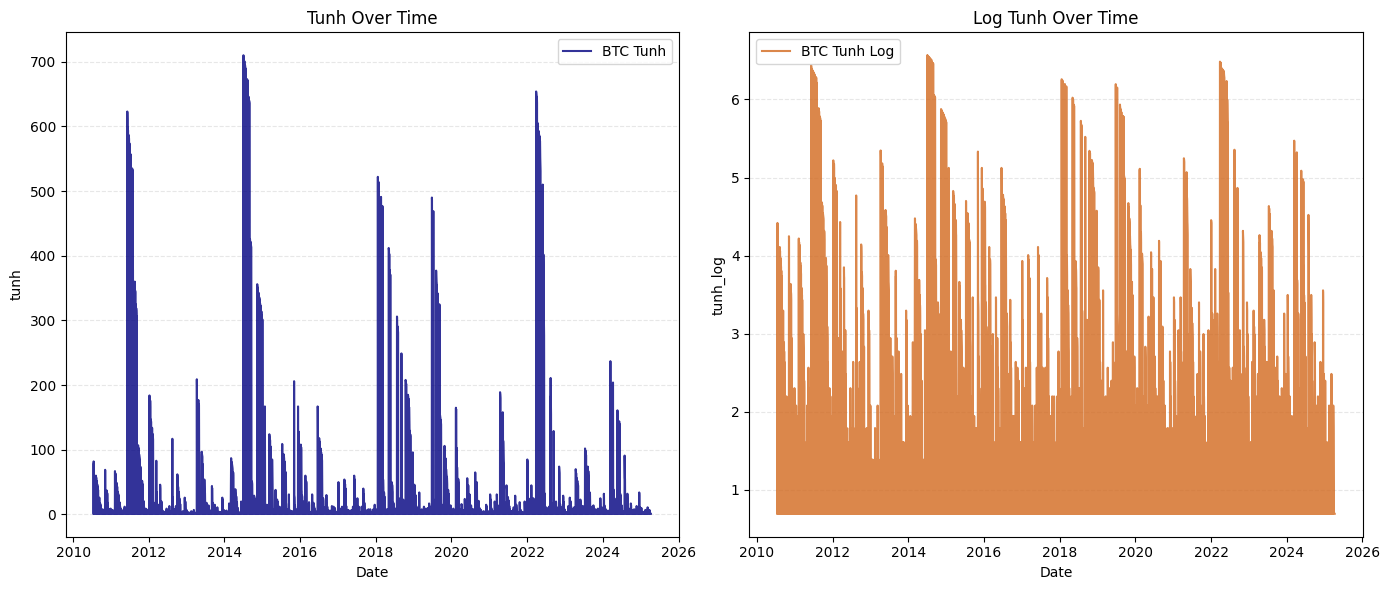

In [13]:
# Create the figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Tunh Over Time
sns.lineplot(x=df_btc["date"], y=df_btc["tunh"], color="navy", alpha=0.8, label="BTC Tunh", ax=axes[0])
axes[0].set_title("Tunh Over Time")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('tunh')
axes[0].legend()
axes[0].grid(visible=True, alpha=0.3, linestyle='--', axis='y')
axes[0].grid(visible=False, alpha=0.0, axis='x')

# Second plot: Log Tunh Over Time
sns.lineplot(x=df_btc["date"], y=df_btc["tunh_log"], color="chocolate", alpha=0.8, label="BTC Tunh Log", ax=axes[1])
axes[1].set_title("Log Tunh Over Time")
axes[1].set_xlabel('Date')
axes[1].set_ylabel('tunh_log')
axes[1].legend()
axes[1].grid(visible=True, alpha=0.3, linestyle='--', axis='y')
axes[1].grid(visible=False, alpha=0.0, axis='x')

plt.savefig('Plots/3. lineplots/1. lineplot_btc.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

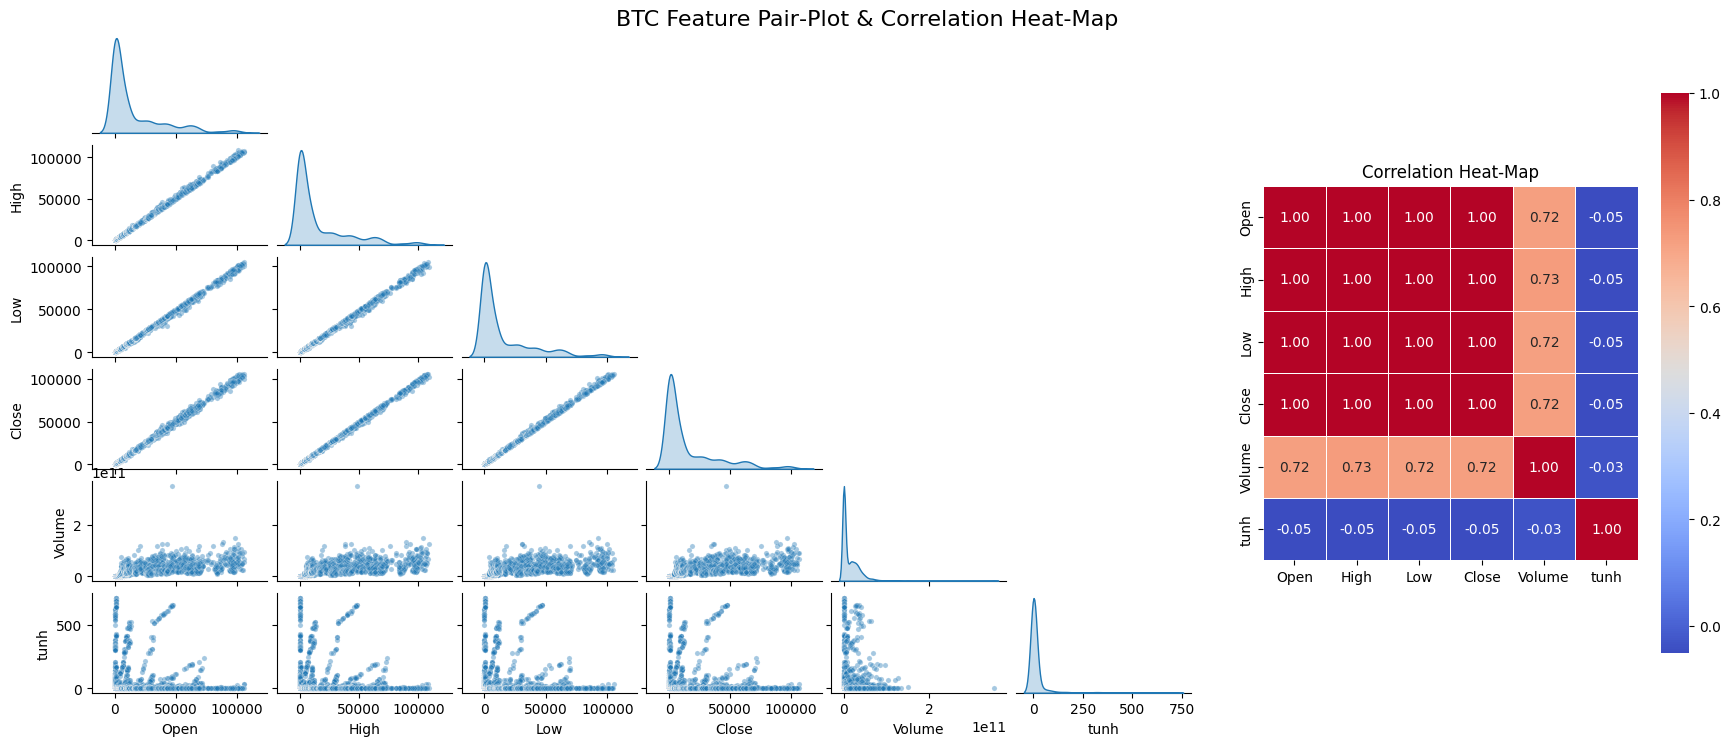

In [14]:
num_cols = ["Open", "High", "Low", "Close", "Volume", "tunh"]

g = sns.pairplot(
    df_btc[num_cols],
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.4, "s": 14}
)
g.fig.set_size_inches(18, 7)          # make it wide enough

g.fig.subplots_adjust(right=0.68)     # 68 % of width → pair‑plot; rest → heat‑map

ax_heat = g.fig.add_axes([0.72, 0.10, 0.26, 0.80])   # [left, bottom, width, height]

corr = df_btc[num_cols].corr(method="pearson")
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    ax=ax_heat
)
ax_heat.set_title("Correlation Heat‑Map", fontsize=12)

g.fig.suptitle("BTC Feature Pair‑Plot & Correlation Heat‑Map", y=1.02, fontsize=16)
plt.savefig('Plots/4. pairplots/1. pairplot_btc.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
df_btc = df_btc.drop(['tunh'], axis=1)

### **Step 6:** Function to calculate metrics

In [16]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    direction_true = np.sign(np.diff(y_true))
    direction_pred = np.sign(np.diff(y_pred))
    da = np.mean(direction_true == direction_pred) * 100
    return mae, rmse, mape, da

### **Step 7:** Convert to time-series

In [17]:
df_btc_rolled = roll_time_series(df_btc, column_id="coin", column_sort="date",
                            max_timeshift=20, min_timeshift=5)

Rolling: 100%|██████████| 20/20 [00:04<00:00,  4.61it/s]


In [18]:
print(df_btc_rolled.head())
print("\nLen of df_rolled:",len(df_btc_rolled))
print("Unique id's:",df_btc_rolled["id"].nunique())

         date    Open    High     Low   Close  Volume coin  tunh_log                 id
0  2010-07-17  0.0500  0.0500  0.0500  0.0500     0.0  BTC  0.693147  (BTC, 2010-07-22)
1  2010-07-18  0.0858  0.0858  0.0858  0.0858     0.0  BTC  4.418841  (BTC, 2010-07-22)
2  2010-07-19  0.0808  0.0808  0.0808  0.0808     0.0  BTC  4.406719  (BTC, 2010-07-22)
3  2010-07-20  0.0747  0.0747  0.0747  0.0747     0.0  BTC  0.693147  (BTC, 2010-07-22)
4  2010-07-21  0.0792  0.0792  0.0792  0.0792     0.0  BTC  4.382027  (BTC, 2010-07-22)

Len of df_rolled: 111642
Unique id's: 5322


### **Step 8:** Feature extraction

In [19]:
X_btc = extract_features(df_btc_rolled.drop("coin", axis=1), 
                    column_id="id", column_sort="date", column_value="tunh_log", 
                    impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


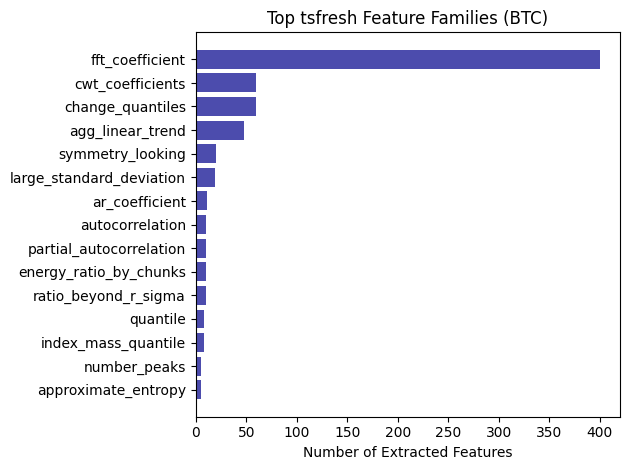

In [20]:
feature_families = []
for col in X_btc.columns:
    # tsfresh column format:  "Open__autocorrelation__lag_5"  → family = "autocorrelation"
    parts = col.split("__")
    feature_families.append(parts[1] if len(parts) >= 2 else "other")

family_counts = Counter(feature_families)
families, counts = zip(*family_counts.most_common(15))   # top‑15

coverage = (
    df_btc_rolled.groupby("date")["id"]
    .nunique()
    .sort_index()
)

# --- Left: feature‑family barh
plt.barh(list(families)[::-1], list(counts)[::-1], color="darkblue", alpha=0.7)
plt.title("Top tsfresh Feature Families (BTC)")
plt.xlabel("Number of Extracted Features")


fig.suptitle("Feature‑Extraction Diagnostics", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

### **Step 9:** Split the data

In [21]:
X_btc = X_btc.set_index(X_btc.index.map(lambda x: x[1]), drop=True)
X_btc.index.name = "last_date"
X_btc.head()

tunh_log__variance_larger_than_standard_deviation  tunh_log__has_duplicate_max  tunh_log__has_duplicate_min  tunh_log__has_duplicate  tunh_log__sum_values  tunh_log__abs_energy  tunh_log__mean_abs_change  tunh_log__mean_change  tunh_log__mean_second_derivative_central  tunh_log__median  tunh_log__mean  tunh_log__length  tunh_log__standard_deviation  tunh_log__variation_coefficient  tunh_log__variance  tunh_log__skewness  tunh_log__kurtosis  tunh_log__root_mean_square  tunh_log__absolute_sum_of_changes  tunh_log__longest_strike_below_mean  tunh_log__longest_strike_above_mean  tunh_log__count_above_mean  tunh_log__count_below_mean  tunh_log__last_location_of_maximum  tunh_log__first_location_of_maximum  tunh_log__last_location_of_minimum  tunh_log__first_location_of_minimum  tunh_log__percentage_of_reoccurring_values_to_all_values  tunh_log__percentage_of_reoccurring_datapoints_to_all_datapoints  tunh_log__sum_of_reoccurring_values  tunh_log__sum_of_reoccurring_data_points  \
last_date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2010-07-22                                                1.0                          0.0                          1.0                      1.0             15.287028             59.588843                   2.965829               0.000000                                 -0.926822          2.537587        2.547838               6.0                      1.854722                         0.727959            3.439995            0.000140           -3.332937                    3.151424                          14.829146                                  1.0                                  2.0                         3.0                         3.0                            0.333333                             0.166667                            1.000000                                  0.0                                           0.250000                                                  0.500000                                            0.693147                                  2.079442   
2010-07-23                                                1.0                          0.0                          1.0                      1.0             17.232938             63.375410                   2.680318               0.208794                                 -0.247293          1.945910        2.461848               7.0                      1.730009                         0.702728            2.992933            0.185774           -2.644201                    3.008925                          16.081909                                  2.0                                  2.0                         3.0                         4.0                            0.285714                             0.142857                            0.857143                                  0.0                                           0.200000                                                  0.428571                                            0.693147                                  2.079442   
2010-07-

In [22]:
y_btc = df_btc.set_index("date").sort_index().tunh_log.shift(-1)

In [23]:
y_btc = y_btc.dropna()
y_btc.isna().sum()

0

In [24]:
y_btc = y_btc[y_btc.index.isin(X_btc.index)]
X_btc = X_btc[X_btc.index.isin(y_btc.index)]

## <span style='color:brown'>**Stage B:** Modelling</span>

### <span style='color:darkgoldenrod'>**Model 1 (Baseline):** Support Vector Regressor</span>

#### **Step 1:** Split the data for the SVR (80% Train - Next 10% Validation - 10% Test)

In [26]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X_btc) * 0.80)
wf_index    = int(len(X_btc) * 0.90)

X_tr_raw = X_btc.iloc[:split_index]
X_wf_raw = X_btc.iloc[split_index:wf_index]
X_te_raw = X_btc.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_btc_svr  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X_btc.columns)
X_wf_btc_svr  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X_btc.columns)
X_test_btc_svr  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X_btc.columns)

y_train_btc_svr = y_btc.reindex(X_train_btc_svr.index).dropna()
X_train_btc_svr = X_train_btc_svr.loc[y_train_btc_svr.index]
y_wf_btc_svr = y_btc.reindex(X_wf_btc_svr.index).dropna()
X_wf_btc_svr = X_wf_btc_svr.loc[y_wf_btc_svr.index]
y_test_btc_svr = y_btc.reindex(X_test_btc_svr.index).dropna()
X_test_btc_svr = X_test_btc_svr.loc[y_test_btc_svr.index]

In [27]:
print("Train date range:", X_train_btc_svr.index.min(), "to", X_train_btc_svr.index.max())
print("Walk-forward date range:", X_wf_btc_svr.index.min(), "to", X_wf_btc_svr.index.max())
print("Test date range:", X_test_btc_svr.index.min(), "to", X_test_btc_svr.index.max())

Train date range: 2010-07-22 to 2022-05-09
Walk-forward date range: 2022-05-10 to 2023-10-23
Test date range: 2023-10-24 to 2025-04-08


In [28]:
print("Train samples:", len(X_train_btc_svr))
print("Walk-forward samples:", len(X_wf_btc_svr))
print("Test samples:", len(X_test_btc_svr))

Train samples: 4256
Walk-forward samples: 532
Test samples: 533


#### **Step 2:** SVR Feature Selection

In [29]:
selected = select_features(X_train_btc_svr, y_train_btc_svr).columns
X_train_selected_btc_svr = X_train_btc_svr[selected]
X_wf_selected_btc_svr = X_wf_btc_svr[selected]
X_test_selected_btc_svr = X_test_btc_svr[selected]

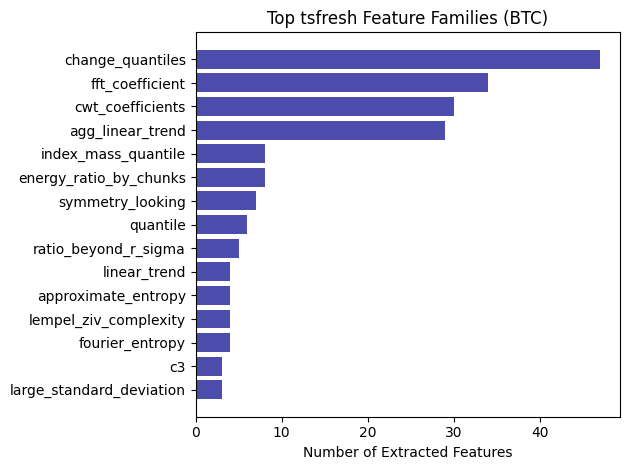

In [30]:
feature_families = []
for col in X_train_selected_btc_svr.columns:
    parts = col.split("__")
    feature_families.append(parts[1] if len(parts) >= 2 else "other")

family_counts = Counter(feature_families)
families, counts = zip(*family_counts.most_common(15))   # top‑15

coverage = (
    df_btc_rolled.groupby("date")["id"]
    .nunique()
    .sort_index()
)

plt.barh(list(families)[::-1], list(counts)[::-1], color="darkblue", alpha=0.7)
plt.title("Top tsfresh Feature Families (BTC)")
plt.xlabel("Number of Extracted Features")

fig.suptitle("Feature‑Extraction Diagnostics", fontsize=15, y=1.02)
plt.savefig('Plots/5. top features/1. top_features_btc.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

#### **Step 3:** SVR Train

In [31]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_btc_svr.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_btc_svr.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_btc_svr.diff().shift(-1) < 0).astype(int)

X_train_reg_btc_svr = X_train_selected_btc_svr.copy(); X_train_reg_btc_svr['regime'] = reg_tr
X_wf_reg_btc_svr = X_wf_selected_btc_svr.copy(); X_wf_reg_btc_svr['regime'] = reg_wf
X_test_reg_btc_svr = X_test_selected_btc_svr.copy(); X_test_reg_btc_svr['regime'] = reg_te

In [32]:
def expand_with_regime_interactions(X, reg):
    X_exp = pd.DataFrame(index=X.index)
    # the “global” features:
    X_exp[X.columns] = X
    # bull‑only features (zero in bear)
    X_exp[[f"{c}_bull" for c in X.columns]] = X.values * reg.values[:,None]
    # bear‑only features (zero in bull)
    X_exp[[f"{c}_bear" for c in X.columns]] = X.values * (1 - reg.values)[:,None]
    return X_exp

X_train_int_btc_svr = expand_with_regime_interactions(X_train_selected_btc_svr, reg_tr)
X_wf_int_btc_svr = expand_with_regime_interactions(X_wf_selected_btc_svr, reg_wf)
X_test_int_btc_svr = expand_with_regime_interactions(X_test_selected_btc_svr, reg_te)

In [31]:
svr = SVR(kernel="poly", C=1.0, epsilon=0.1, gamma="scale", degree=2)
svr.fit(X_train_int_btc_svr, y_train_btc_svr)

SVR(degree=2, kernel='poly')

#### **Step 4:** SVR Walk-Forward Validation

In [32]:
# ─── 5) WALK‐FORWARD PREDICTIONS ───────────────────────────────────────────
fold_preds, fold_actuals, fold_indices = [], [], []
window_size = 100
start = 0

while start + window_size <= len(X_wf_int_btc_svr):
    idx = X_wf_int_btc_svr.index[start:start+window_size]
    X_win_btc = X_wf_int_btc_svr.loc[idx]
    y_win_btc = y_wf_btc_svr.loc[idx]
    preds = svr.predict(X_win_btc)
    fold_preds.append(preds)
    fold_actuals.append(y_win_btc.values)
    fold_indices.append(idx)
    # print per‐window metrics
    MAE, RMSE, MAPE, DA = calculate_metrics(y_win_btc.values, preds)
    print(f"WF window ending at {idx[-1]}: MAE={MAE:.4f}, RMSE={RMSE:.4f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")
    start += window_size

WF window ending at 2022-08-17: MAE=0.5586, RMSE=0.9934, MAPE=30.80%, DA=61.62%
WF window ending at 2022-11-25: MAE=0.3766, RMSE=0.7125, MAPE=22.40%, DA=69.70%
WF window ending at 2023-03-05: MAE=0.2989, RMSE=0.5245, MAPE=19.46%, DA=60.61%
WF window ending at 2023-06-13: MAE=0.4367, RMSE=0.7558, MAPE=22.98%, DA=62.63%
WF window ending at 2023-09-21: MAE=0.4074, RMSE=0.7365, MAPE=20.79%, DA=64.65%


#### **Step 5:** Evaluate SVR

In [33]:
# ─── 6) FINAL TEST PREDICTION & EVALUATION ────────────────────────────────
y_train_pred_btc_svr = svr.predict(X_train_int_btc_svr)
y_test_pred_btc_svr = svr.predict(X_test_int_btc_svr)

# overall test metrics
MAE_train_btc_svr, RMSE_train_btc_svr, MAPE_train_btc_svr, DA_train_btc_svr = calculate_metrics(y_train_btc_svr.values, y_train_pred_btc_svr)
MAE_test_btc_svr, RMSE_test_btc_svr, MAPE_test_btc_svr, DA_test_btc_svr = calculate_metrics(y_test_btc_svr.values, y_test_pred_btc_svr)

print("SVR Train Metrics:")
print(f" MAE={MAE_train_btc_svr:.5f}, RMSE={RMSE_train_btc_svr:.5f}, MAPE={MAPE_train_btc_svr:.2f}%, DA={DA_train_btc_svr:.2f}%")

print("\nSVR Test Metrics:")
print(f" MAE={MAE_test_btc_svr:.5f}, RMSE={RMSE_test_btc_svr:.5f}, MAPE={MAPE_test_btc_svr:.2f}%, DA={DA_test_btc_svr:.2f}%")

SVR Train Metrics:
 MAE=0.28758, RMSE=0.64103, MAPE=16.57%, DA=63.15%

SVR Test Metrics:
 MAE=0.27550, RMSE=0.55598, MAPE=17.11%, DA=59.77%


In [34]:
# 1) WALK‑FORWARD DataFrame
df_wf_btc_results = pd.DataFrame({
    "Actual": np.concatenate(fold_actuals),
    "Predicted": np.concatenate(fold_preds)
}, index=pd.DatetimeIndex(np.concatenate(fold_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_btc_results = pd.DataFrame({
    "Actual":  y_test_btc_svr.values,
    "Predicted": y_test_pred_btc_svr
}, index=X_test_selected_btc_svr.index)

# 3) convert back to days
df_test_days_btc = df_test_btc_results.copy()
df_test_days_btc["Actual_days"]    = np.expm1(df_test_days_btc["Actual"])
df_test_days_btc["Predicted_days"] = np.expm1(df_test_days_btc["Predicted"])
print("\nTest Results (in days):")
print(df_test_days_btc.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2023-10-24  2.079442   1.749746          7.0        4.753139
2023-10-25  1.609438   1.659793          4.0        4.258220
2023-10-26  0.693147   0.776180          1.0        1.173155
2023-10-27  0.693147   0.815322          1.0        1.259904
2023-10-28  0.693147   0.816071          1.0        1.261596


#### **Step 6:** SVR Plots

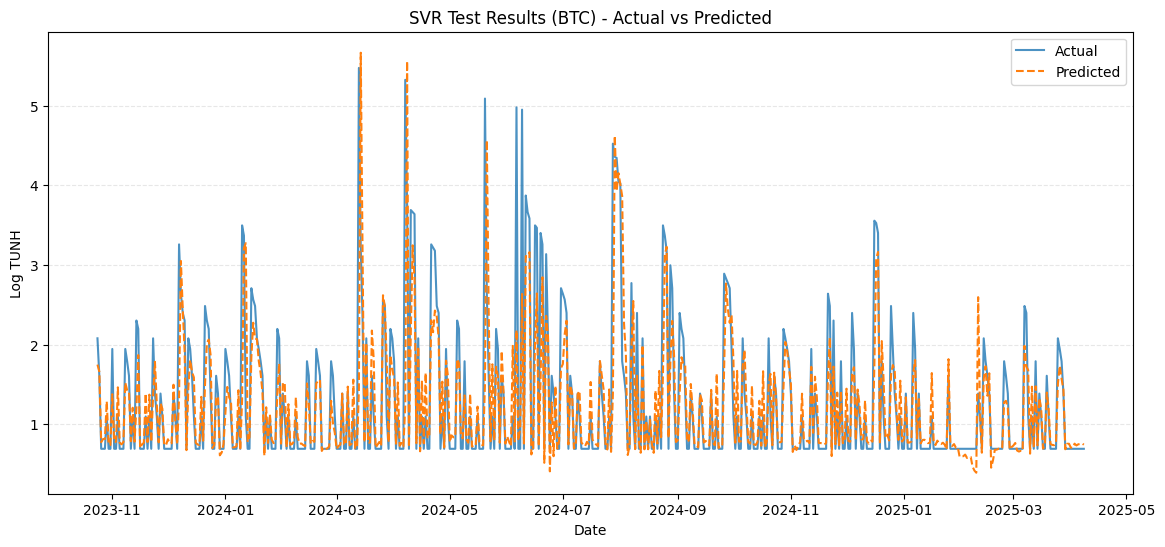

In [35]:
plot_log_results(
    df_test_btc_results,
    "SVR Test Results (BTC) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/1. svr/1a. test_results_log_btc.png'
)

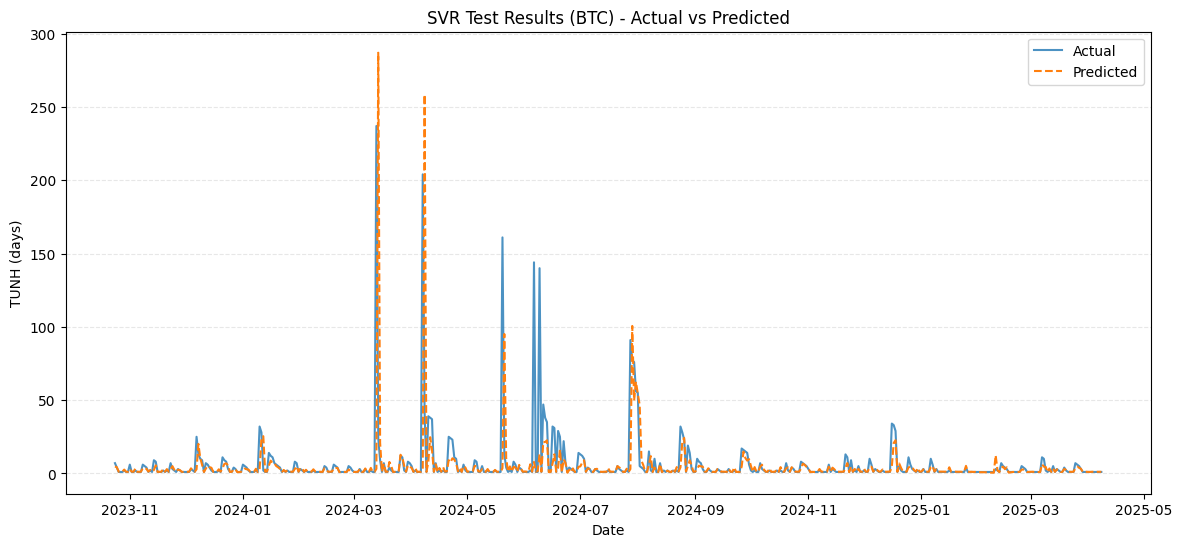

In [36]:
plot_results(
    df_test_days_btc,
    "SVR Test Results (BTC) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/1. svr/1b. test_results_btc.png'
)

### <span style='color:darkgoldenrod'>**Model 2:** Random Forest Regressor</span>

#### **Step 1:** Split the data for the RF (80% Train - Next 10% Validation - 10% Test)

In [25]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X_btc) * 0.80)
wf_index    = int(len(X_btc) * 0.90)

X_tr_raw = X_btc.iloc[:split_index]
X_wf_raw = X_btc.iloc[split_index:wf_index]
X_te_raw = X_btc.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_btc_rf  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X_btc.columns)
X_wf_btc_rf  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X_btc.columns)
X_test_btc_rf  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X_btc.columns)

y_train_btc_rf = y_btc.reindex(X_train_btc_rf.index).dropna()
X_train_btc_rf = X_train_btc_rf.loc[y_train_btc_rf.index]
y_wf_btc_rf = y_btc.reindex(X_wf_btc_rf.index).dropna()
X_wf_btc_rf = X_wf_btc_rf.loc[y_wf_btc_rf.index]
y_test_btc_rf = y_btc.reindex(X_test_btc_rf.index).dropna()
X_test_btc_rf = X_test_btc_rf.loc[y_test_btc_rf.index]

#### **Step 2:** RF Feature Selection

In [33]:
# 2) FEATURE SELECTION
selected = select_features(X_train_btc_rf, y_train_btc_rf).columns
X_train_selected_btc_rf = X_train_btc_rf[selected]
X_wf_selected_btc_rf = X_wf_btc_rf[selected]
X_test_selected_btc_rf = X_test_btc_rf[selected]

#### **Step 3:** RF HP Tuning & Train

In [34]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_btc_rf.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_btc_rf.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_btc_rf.diff().shift(-1) < 0).astype(int)

X_train_reg_btc_rf = X_train_selected_btc_rf.copy(); X_train_reg_btc_rf['regime'] = reg_tr
X_wf_reg_btc_rf = X_wf_selected_btc_rf.copy(); X_wf_reg_btc_rf['regime'] = reg_wf
X_test_reg_btc_rf = X_test_selected_btc_rf.copy(); X_test_reg_btc_rf['regime'] = reg_te

In [35]:
X_train_int_btc_rf = expand_with_regime_interactions(X_train_selected_btc_rf, reg_tr)
X_wf_int_btc_rf = expand_with_regime_interactions(X_wf_selected_btc_rf, reg_wf)
X_test_int_btc_rf = expand_with_regime_interactions(X_test_selected_btc_rf, reg_te)

In [42]:
# Setup the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid
param_dist_rf = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized Search for hyperparameter tuning
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=20, cv=tscv, verbose=2, random_state=42, n_jobs=-1)

In [43]:
# Best model
random_search_rf.fit(X_train_int_btc_rf, y_train_btc_rf)
best_rf = random_search_rf.best_estimator_
print("Best parameters for RF with TimeSeriesSplit:", random_search_rf.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  24.0s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  47.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  58.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.4min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=  34.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 2.0min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time= 1.0min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total tim

In [36]:
best_rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=4, bootstrap=True, random_state=42)
# Best model
best_rf.fit(X_train_int_btc_rf, y_train_btc_rf)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)

#### **Step 4:** RF Walk-Forward Validation

In [37]:
# ─── C) WALK‑FORWARD EVALUATION ─────────────────────────────────────────────
fold_preds, fold_actuals, fold_indices = [], [], []
window_size = 100
for start in range(0, len(X_wf_int_btc_rf), window_size):
    idx = X_wf_int_btc_rf.index[start:start+window_size]
    X_win = X_wf_int_btc_rf.loc[idx]
    y_win = y_wf_btc_rf.loc[idx]
    preds = best_rf.predict(X_win)
    fold_preds.append(preds)
    fold_actuals.append(y_win.values)
    fold_indices.append(idx)
    MAE, RMSE, MAPE, DA = calculate_metrics(y_win.values, preds)
    print(f"WF ending {idx[-1]}: MAE={MAE:.4f}, RMSE={RMSE:.4f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

WF ending 2022-08-17: MAE=0.4570, RMSE=0.8838, MAPE=20.16%, DA=68.69%
WF ending 2022-11-25: MAE=0.3529, RMSE=0.6474, MAPE=18.71%, DA=79.80%
WF ending 2023-03-05: MAE=0.2707, RMSE=0.4959, MAPE=16.83%, DA=71.72%
WF ending 2023-06-13: MAE=0.3443, RMSE=0.6511, MAPE=18.28%, DA=75.76%
WF ending 2023-09-21: MAE=0.3483, RMSE=0.6802, MAPE=16.40%, DA=76.77%
WF ending 2023-10-23: MAE=0.2044, RMSE=0.4185, MAPE=12.15%, DA=67.74%


#### **Step 5:** Evaluate RF

In [38]:
# ─── 6) FINAL TEST PREDICTION & EVALUATION ────────────────────────────────
y_train_pred_btc_rf = best_rf.predict(X_train_int_btc_rf)
y_test_pred_btc_rf = best_rf.predict(X_test_int_btc_rf)

# overall test metrics
MAE_train_btc_rf, RMSE_train_btc_rf, MAPE_train_btc_rf, DA_train_btc_rf = calculate_metrics(y_train_btc_rf.values, y_train_pred_btc_rf)
MAE_test_btc_rf, RMSE_test_btc_rf, MAPE_test_btc_rf, DA_test_btc_rf = calculate_metrics(y_test_btc_rf.values, y_test_pred_btc_rf)

print("RF Train Metrics:")
print(f" MAE={MAE_train_btc_rf:.5f}, RMSE={RMSE_train_btc_rf:.5f}, MAPE={MAPE_train_btc_rf:.2f}%, DA={DA_train_btc_rf:.2f}%")

print("\nRF Test Metrics:")
print(f" MAE={MAE_test_btc_rf:.5f}, RMSE={RMSE_test_btc_rf:.5f}, MAPE={MAPE_test_btc_rf:.2f}%, DA={DA_test_btc_rf:.2f}%")

RF Train Metrics:
 MAE=0.25116, RMSE=0.50678, MAPE=13.05%, DA=70.95%

RF Test Metrics:
 MAE=0.24088, RMSE=0.49850, MAPE=14.08%, DA=70.49%


In [39]:
# 1) WALK‑FORWARD DataFrame
#   - y_wf_all, y_wf_pred, idx_wf_all came from the regime‑split loop
df_wf_btc_results = pd.DataFrame({
    "Actual": np.concatenate(fold_actuals),
    "Predicted": np.concatenate(fold_preds)
}, index=pd.DatetimeIndex(np.concatenate(fold_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_btc_results = pd.DataFrame({
    "Actual":  y_test_btc_rf.values,
    "Predicted": y_test_pred_btc_rf
}, index=X_test_selected_btc_rf.index)

# 3) convert back to days
df_test_days_btc = df_test_btc_results.copy()
df_test_days_btc["Actual_days"]    = np.expm1(df_test_days_btc["Actual"])
df_test_days_btc["Predicted_days"] = np.expm1(df_test_days_btc["Predicted"])
print("\nTest Results (in days):")
print(df_test_days_btc.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2023-10-24  2.079442   1.825475          7.0        5.205739
2023-10-25  1.609438   1.760254          4.0        4.813912
2023-10-26  0.693147   0.693147          1.0        1.000000
2023-10-27  0.693147   0.693147          1.0        1.000000
2023-10-28  0.693147   0.693147          1.0        1.000000


#### **Step 6:** RF Plots

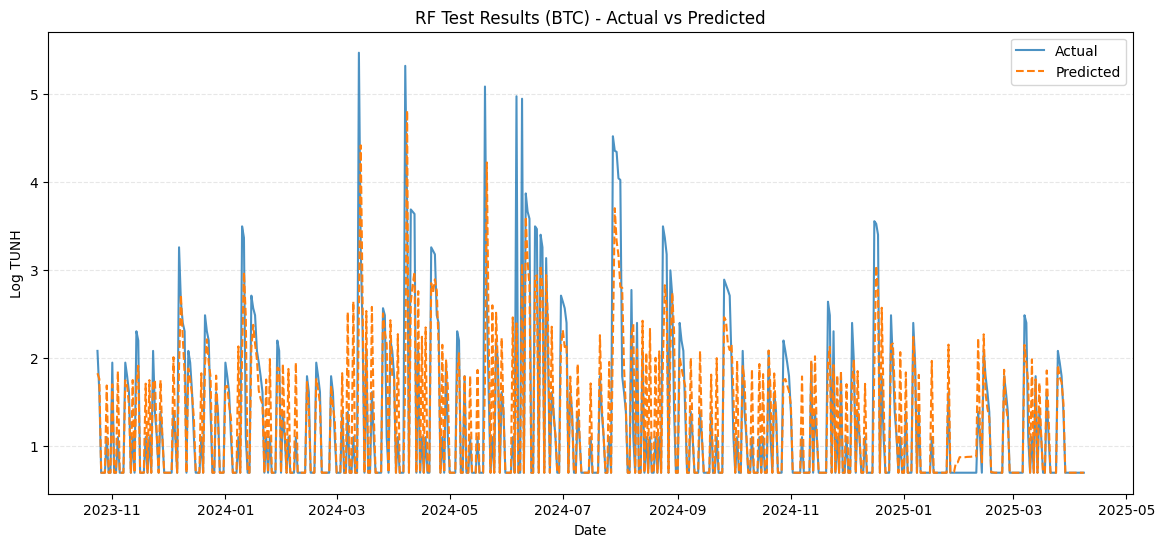

In [39]:
plot_log_results(
    df_test_btc_results,
    "RF Test Results (BTC) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/2. rf/1a. test_results_log_btc.png'
)

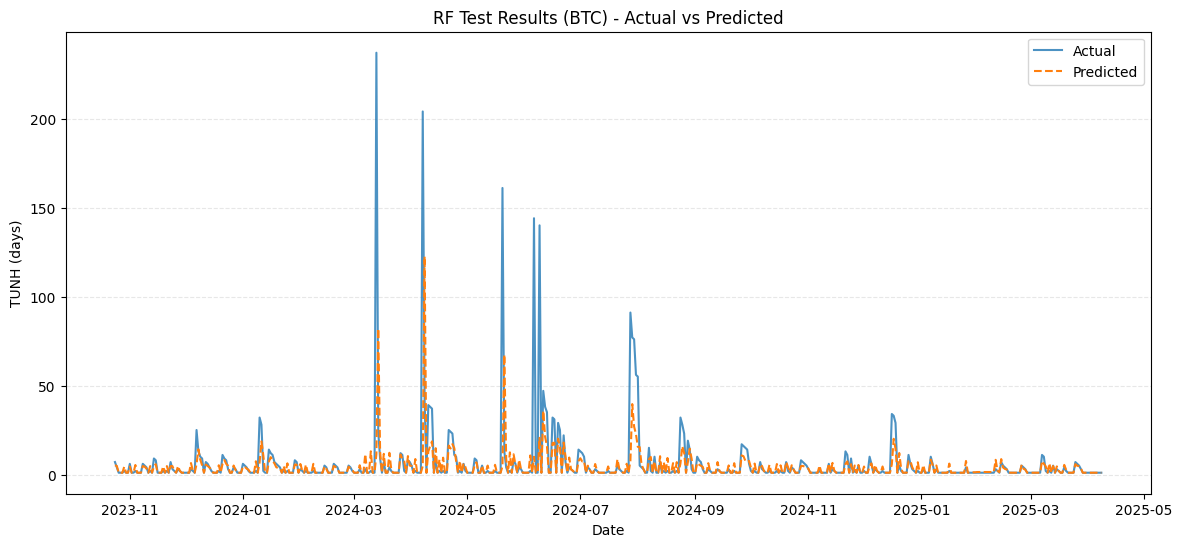

In [40]:
plot_results(
    df_test_days_btc,
    "RF Test Results (BTC) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/2. rf/1b. test_results_btc.png'
)

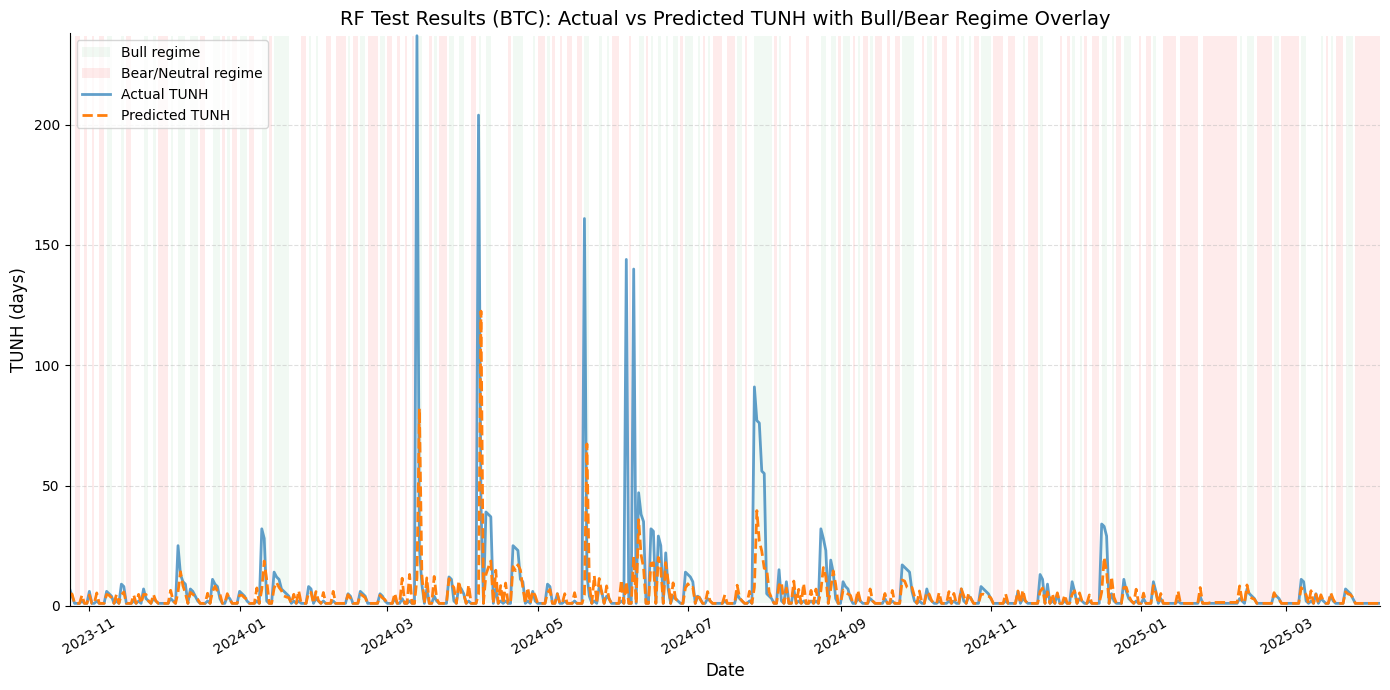

In [184]:
# 1) start from your existing df_test_btc_results
df = df_test_days_btc.copy()

# 2) compute the bull/bear regime flag on-the-fly
df['regime'] = (df['Actual_days'].diff().shift(-1) < 0).astype(int)

# 3) get y-limits for shading
ymin = df[['Actual_days', 'Predicted_days']].min().min()
ymax = df[['Actual_days', 'Predicted_days']].max().max()

# 4) plot
fig, ax = plt.subplots(figsize=(14, 7))

# Define custom colors
bull_color = '#76c893'  # Soft green for bull regime
bear_color = '#f94144'  # Soft red for bear/neutral regime

# Shade bull days
ax.fill_between(
    df.index, ymin, ymax,
    where=(df['regime'] == 1),
    facecolor=bull_color, alpha=0.1,
    label='Bull regime'
)

# Shade bear/neutral days
ax.fill_between(
    df.index, ymin, ymax,
    where=(df['regime'] == 0),
    facecolor=bear_color, alpha=0.1,
    label='Bear/Neutral regime'
)

# Plot actual vs. predicted
ax.plot(df.index, df['Actual_days'], alpha=0.7, linewidth=2, label='Actual TUNH', linestyle='-')
ax.plot(df.index, df['Predicted_days'], label='Predicted TUNH', linestyle='--', alpha=1, linewidth=2)

# Set axis limits and labels
ax.set_xlim(df.index.min(), df.index.max())
ax.set_ylim(ymin - 1, ymax + 1)
ax.set_title("RF Test Results (BTC): Actual vs Predicted TUNH with Bull/Bear Regime Overlay", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("TUNH (days)", fontsize=12)

# Customize legend
ax.legend(loc='upper left', fontsize=10, frameon=True)

# Remove all borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Rotate x-axis ticks for better readability
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(visible=True, alpha=0.4, linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('Plots/6. test results/2. rf/1c. test_results_btc_regime.png', dpi=300, bbox_inches='tight')
plt.show()

### <span style='color:darkgoldenrod'>**Model 3:** XGBoost Regressor</span>

#### **Step 1:** Split the data for the XGBoost (80% Train - Next 10% Validation - 10% Test)

In [31]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X_btc) * 0.80)
wf_index    = int(len(X_btc) * 0.90)

X_tr_raw = X_btc.iloc[:split_index]
X_wf_raw = X_btc.iloc[split_index:wf_index]
X_te_raw = X_btc.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_btc_xgb  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X_btc.columns)
X_wf_btc_xgb  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X_btc.columns)
X_test_btc_xgb  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X_btc.columns)

y_train_btc_xgb = y_btc.reindex(X_train_btc_xgb.index).dropna()
X_train_btc_xgb = X_train_btc_xgb.loc[y_train_btc_xgb.index]
y_wf_btc_xgb = y_btc.reindex(X_wf_btc_xgb.index).dropna()
X_wf_btc_xgb = X_wf_btc_xgb.loc[y_wf_btc_xgb.index]
y_test_btc_xgb = y_btc.reindex(X_test_btc_xgb.index).dropna()
X_test_btc_xgb = X_test_btc_xgb.loc[y_test_btc_xgb.index]

#### **Step 2:** XGBoost Feature Selection

In [32]:
# 2) FEATURE SELECTION
selected = select_features(X_train_btc_xgb, y_train_btc_xgb).columns
X_train_selected_btc_xgb = X_train_btc_xgb[selected]
X_wf_selected_btc_xgb = X_wf_btc_xgb[selected]
X_test_selected_btc_xgb = X_test_btc_xgb[selected]

#### **Step 3:** XGBoost HP Tuning & Train

In [33]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_btc_xgb.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_btc_xgb.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_btc_xgb.diff().shift(-1) < 0).astype(int)

X_train_reg_btc_xgb = X_train_selected_btc_xgb.copy(); X_train_reg_btc_xgb['regime'] = reg_tr
X_wf_reg_btc_xgb = X_wf_selected_btc_xgb.copy(); X_wf_reg_btc_xgb['regime'] = reg_wf
X_test_reg_btc_xgb = X_test_selected_btc_xgb.copy(); X_test_reg_btc_xgb['regime'] = reg_te

In [34]:
X_train_int_btc_xgb = expand_with_regime_interactions(X_train_selected_btc_xgb, reg_tr)
X_wf_int_btc_xgb = expand_with_regime_interactions(X_wf_selected_btc_xgb, reg_wf)
X_test_int_btc_xgb = expand_with_regime_interactions(X_test_selected_btc_xgb, reg_te)

In [35]:
# 4) HYPERPARAMETER GRID & TS SPLIT
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}
tscv = TimeSeriesSplit(n_splits=5)

# tune bull specialist
search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=20, cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42, n_jobs=-1, verbose=1
)
search.fit(X_train_int_btc_xgb, y_train_btc_xgb)
best_xgb = search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


#### **Step 4:** XGBoost Walk-Forward Validation

In [36]:
# ─── C) WALK‑FORWARD EVALUATION ─────────────────────────────────────────────
fold_preds, fold_actuals, fold_indices = [], [], []
window_size = 100
for start in range(0, len(X_wf_int_btc_xgb), window_size):
    idx = X_wf_int_btc_xgb.index[start:start+window_size]
    X_win = X_wf_int_btc_xgb.loc[idx]
    y_win = y_wf_btc_xgb.loc[idx]
    preds = best_xgb.predict(X_win)
    fold_preds.append(preds)
    fold_actuals.append(y_win.values)
    fold_indices.append(idx)
    MAE, RMSE, MAPE, DA = calculate_metrics(y_win.values, preds)
    print(f"WF ending {idx[-1]}: MAE={MAE:.4f}, RMSE={RMSE:.4f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

WF ending 2022-08-17: MAE=0.4763, RMSE=0.9129, MAPE=19.95%, DA=88.89%
WF ending 2022-11-25: MAE=0.3858, RMSE=0.7014, MAPE=20.53%, DA=90.91%
WF ending 2023-03-05: MAE=0.2611, RMSE=0.4949, MAPE=16.09%, DA=90.91%
WF ending 2023-06-13: MAE=0.3719, RMSE=0.6667, MAPE=20.13%, DA=91.92%
WF ending 2023-09-21: MAE=0.3512, RMSE=0.6556, MAPE=16.34%, DA=84.85%
WF ending 2023-10-23: MAE=0.2080, RMSE=0.4157, MAPE=12.52%, DA=96.77%


#### **Step 5:** Evaluate XGBoost

In [37]:
# ─── 6) FINAL TEST PREDICTION & EVALUATION ────────────────────────────────
y_train_pred_btc_xgb = best_xgb.predict(X_train_int_btc_xgb)
y_test_pred_btc_xgb = best_xgb.predict(X_test_int_btc_xgb)

# overall test metrics
MAE_train_btc_xgb, RMSE_train_btc_xgb, MAPE_train_btc_xgb, DA_train_btc_xgb = calculate_metrics(y_train_btc_xgb.values, y_train_pred_btc_xgb)
MAE_test_btc_xgb, RMSE_test_btc_xgb, MAPE_test_btc_xgb, DA_test_btc_xgb = calculate_metrics(y_test_btc_xgb.values, y_test_pred_btc_xgb)

print("XGBoost Train Metrics:")
print(f" MAE={MAE_train_btc_xgb:.5f}, RMSE={RMSE_train_btc_xgb:.5f}, MAPE={MAPE_train_btc_xgb:.2f}%, DA={DA_train_btc_xgb:.2f}%")

print("\nXGBoostTest Metrics:")
print(f" MAE={MAE_test_btc_xgb:.5f}, RMSE={RMSE_test_btc_xgb:.5f}, MAPE={MAPE_test_btc_xgb:.2f}%, DA={DA_test_btc_xgb:.2f}%")

XGBoost Train Metrics:
 MAE=0.12431, RMSE=0.23147, MAPE=6.82%, DA=93.73%

XGBoostTest Metrics:
 MAE=0.24347, RMSE=0.51200, MAPE=13.87%, DA=93.80%


In [38]:
# 1) WALK‑FORWARD DataFrame
#   - y_wf_all, y_wf_pred, idx_wf_all came from the regime‑split loop
df_wf_btc_results = pd.DataFrame({
    "Actual": np.concatenate(fold_actuals),
    "Predicted": np.concatenate(fold_preds)
}, index=pd.DatetimeIndex(np.concatenate(fold_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_btc_results = pd.DataFrame({
    "Actual":  y_test_btc_xgb.values,
    "Predicted": y_test_pred_btc_xgb
}, index=X_test_selected_btc_xgb.index)

# 3) convert back to days
df_test_days_btc = df_test_btc_results.copy()
df_test_days_btc["Actual_days"]    = np.expm1(df_test_days_btc["Actual"])
df_test_days_btc["Predicted_days"] = np.expm1(df_test_days_btc["Predicted"])
print("\nTest Results (in days):")
print(df_test_days_btc.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2023-10-24  2.079442   2.008422          7.0        6.451552
2023-10-25  1.609438   1.619163          4.0        4.048865
2023-10-26  0.693147   0.692670          1.0        0.999045
2023-10-27  0.693147   0.692670          1.0        0.999045
2023-10-28  0.693147   0.692670          1.0        0.999045


#### **Step 6:** XGBoost Plots

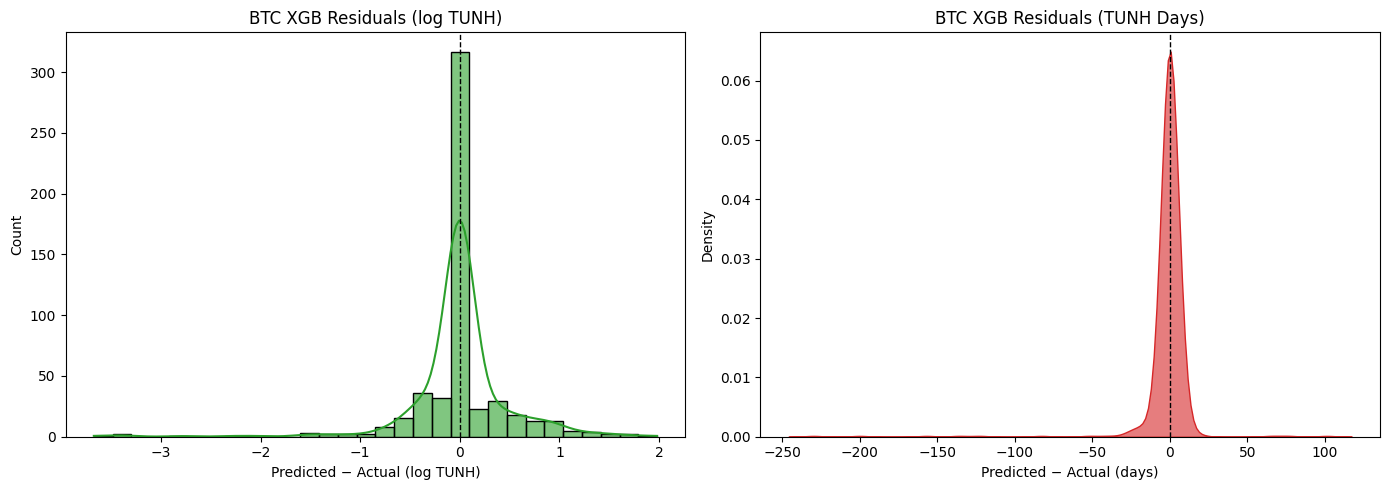

In [42]:
# compute residuals
res_log = df_test_btc_results["Predicted"] - df_test_btc_results["Actual"]
res_days = df_test_days_btc["Predicted_days"] - df_test_days_btc["Actual_days"]

# set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) histogram + KDE of log-TUNH residuals
sns.histplot(
    res_log,
    bins=30,
    kde=True,
    ax=axes[0],
    color="C2",
    edgecolor="k",
    alpha=0.6
)
axes[0].axvline(0, color="k", linestyle="--", linewidth=1)
axes[0].set_title("BTC XGB Residuals (log TUNH)")
axes[0].set_xlabel("Predicted − Actual (log TUNH)")
axes[0].set_ylabel("Count")

# 2) KDE of days residuals
sns.kdeplot(
    res_days,
    fill=True,
    ax=axes[1],
    color="C3",
    alpha=0.6
)
axes[1].axvline(0, color="k", linestyle="--", linewidth=1)
axes[1].set_title("BTC XGB Residuals (TUNH Days)")
axes[1].set_xlabel("Predicted − Actual (days)")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.savefig('Plots/residuals_btc.png', dpi=300, bbox_inches='tight')
plt.show()

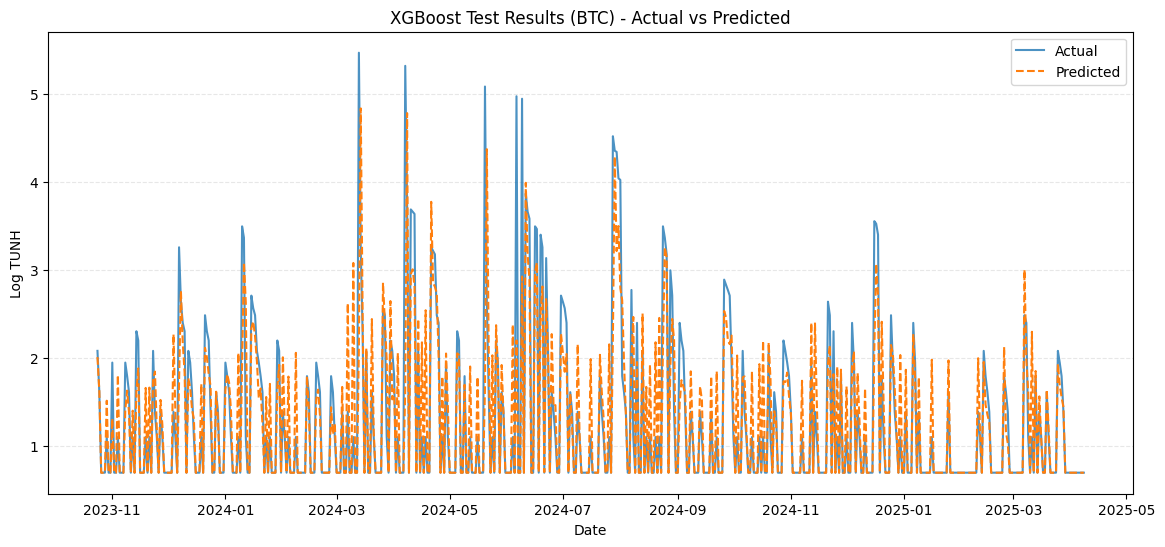

In [55]:
plot_log_results(
    df_test_btc_results,
    "XGBoost Test Results (BTC) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/3. xgb/1a. test_results_log_btc.png'
)

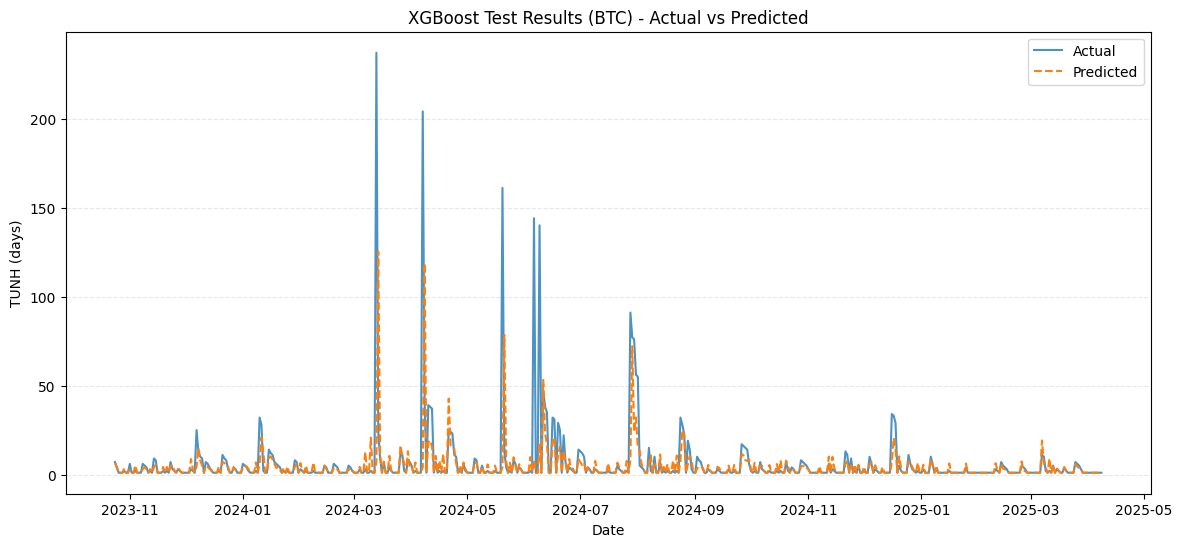

In [56]:
plot_results(
    df_test_days_btc,
    "XGBoost Test Results (BTC) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/3. xgb/1b. test_results_btc.png'
)

### <span style='color:darkgoldenrod'>**Model 4:** LSTM</span>

#### **Step 1:** Split the data for the LSTM (80% Train - Next 10% Validation - 10% Test)

In [57]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X_btc) * 0.80)
wf_index    = int(len(X_btc) * 0.90)

X_tr_raw = X_btc.iloc[:split_index]
X_wf_raw = X_btc.iloc[split_index:wf_index]
X_te_raw = X_btc.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_btc_lstm  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X_btc.columns)
X_wf_btc_lstm  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X_btc.columns)
X_test_btc_lstm  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X_btc.columns)

y_train_btc_lstm = y_btc.reindex(X_train_btc_lstm.index).dropna()
X_train_btc_lstm = X_train_btc_lstm.loc[y_train_btc_lstm.index]
y_wf_btc_lstm = y_btc.reindex(X_wf_btc_lstm.index).dropna()
X_wf_btc_lstm = X_wf_btc_lstm.loc[y_wf_btc_lstm.index]
y_test_btc_lstm = y_btc.reindex(X_test_btc_lstm.index).dropna()
X_test_btc_lstm = X_test_btc_lstm.loc[y_test_btc_lstm.index]

#### **Step 2:** LSTM Feature Selection

In [58]:
# 2) FEATURE SELECTION
selected = select_features(X_train_btc_lstm, y_train_btc_lstm).columns
X_train_selected_btc_lstm = X_train_btc_lstm[selected]
X_wf_selected_btc_lstm = X_wf_btc_lstm[selected]
X_test_selected_btc_lstm = X_test_btc_lstm[selected]

#### **Step 3:** LSTM HP Tuning & Train

In [59]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_btc_lstm.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_btc_lstm.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_btc_lstm.diff().shift(-1) < 0).astype(int)

X_train_reg_btc_lstm = X_train_selected_btc_lstm.copy(); X_train_reg_btc_lstm['regime'] = reg_tr
X_wf_reg_btc_lstm = X_wf_selected_btc_lstm.copy(); X_wf_reg_btc_lstm['regime'] = reg_wf
X_test_reg_btc_lstm = X_test_selected_btc_lstm.copy(); X_test_reg_btc_lstm['regime'] = reg_te

In [60]:
X_train_int_btc_lstm = expand_with_regime_interactions(X_train_selected_btc_lstm, reg_tr)
X_wf_int_btc_lstm = expand_with_regime_interactions(X_wf_selected_btc_lstm, reg_wf)
X_test_int_btc_lstm = expand_with_regime_interactions(X_test_selected_btc_lstm, reg_te)

In [61]:
# shape vars (from SNIPPET 1+2/3)
n_features = X_train_int_btc_lstm.shape[1]
timesteps  = 1

def lstm_builder(hp):
    model = Sequential()
    model.add(Input(shape=(timesteps, n_features)))
    # first LSTM
    model.add(LSTM(
        units=hp.Int("units1", min_value=32, max_value=128, step=32),
        return_sequences=True
    ))
    model.add(Dropout(hp.Float("dropout1", 0.1, 0.5, step=0.1)))
    # optional second LSTM
    if hp.Boolean("stack_second", default=True):
        model.add(LSTM(
            units=hp.Int("units2", min_value=16, max_value=64, step=16),
            return_sequences=False
        ))
        model.add(Dropout(hp.Float("dropout2", 0.1, 0.5, step=0.1)))
    # output
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="mean_squared_error"
    )
    return model

In [62]:
# set up tuner
tuner = kt.RandomSearch(
    lstm_builder,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="tuner_logs_btc",
    project_name="btc_lstm_split"
)

# prepare 3D input
X_tr_3d = X_train_int_btc_lstm.values.reshape((-1, timesteps, n_features))
y_tr_arr = y_train_btc_lstm.values

# tune on the entire train set (you could also limit to bull‑slice)
tuner.search(
    X_tr_3d, y_tr_arr,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5)]
)

# retrieve best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]
print("🔍 Best LSTM hyperparameters:", best_hps.values)

Reloading Tuner from tuner_logs_btc/btc_lstm_split/tuner0.json
🔍 Best LSTM hyperparameters: {'units1': 96, 'dropout1': 0.30000000000000004, 'stack_second': True, 'units2': 64, 'dropout2': 0.2, 'learning_rate': 0.0003133857760621912}


In [63]:
# rebuild specialists with best_hps
def build_best_lstm():
    model = lstm_builder(best_hps)
    return model

best_lstm = build_best_lstm()

best_lstm.fit(
    X_tr_3d, y_tr_arr,
    epochs=50, batch_size=32,
    callbacks=[EarlyStopping(monitor="loss", patience=3)],
    verbose=1
)

Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.3162
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8658
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7207
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6862
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5814
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5227
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5778
Epoch 8/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5035
Epoch 9/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4550
Epoch 10/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4695
Epoch 11/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4376
Epoch 12/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4069
Epoch 13/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4183
Epoch 14/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3674
Epoch 15/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

#### **Step 4:** LSTM Walk-Forward Validation

In [64]:
# ─── C) WALK‑FORWARD EVALUATION ─────────────────────────────────────────────
for start in range(0, len(X_wf_int_btc_lstm), window_size):
    # 1) select the window
    idx    = X_wf_int_btc_lstm.index[start:start+window_size]
    X_win  = X_wf_int_btc_lstm.loc[idx]
    y_win  = y_wf_btc_lstm.loc[idx]

    # 2) reshape to (batch, timesteps=1, features)
    X_win_3d = X_win.values.reshape((len(X_win), 1, X_win.shape[1]))

    # 3) predict
    preds = best_lstm.predict(X_win_3d, verbose=0).flatten()

    # 4) store and report
    fold_preds.append(preds)
    fold_actuals.append(y_win.values)
    fold_indices.append(idx)

    MAE, RMSE, MAPE, DA = calculate_metrics(y_win.values, preds)
    print(f"WF ending {idx[-1]}: MAE={MAE:.4f}, RMSE={RMSE:.4f}, "
        f"MAPE={MAPE:.2f}%, DA={DA:.2f}%")

WF ending 2022-08-17: MAE=0.4393, RMSE=0.9092, MAPE=22.36%, DA=64.65%
WF ending 2022-11-25: MAE=0.4734, RMSE=0.8322, MAPE=27.71%, DA=69.70%
WF ending 2023-03-05: MAE=0.2842, RMSE=0.5299, MAPE=18.29%, DA=65.66%
WF ending 2023-06-13: MAE=0.4119, RMSE=0.7308, MAPE=23.43%, DA=67.68%
WF ending 2023-09-21: MAE=0.3805, RMSE=0.6679, MAPE=20.89%, DA=69.70%
WF ending 2023-10-23: MAE=0.1757, RMSE=0.3471, MAPE=10.85%, DA=64.52%


#### **Step 5:** Evaluate LSTM

In [65]:
n_feats = X_train_int_btc_lstm.shape[1]

X_train_int_3d = X_train_int_btc_lstm.values.reshape(
    (len(X_train_int_btc_lstm), 1, n_feats)
)
X_test_int_3d  = X_test_int_btc_lstm.values.reshape(
    (len(X_test_int_btc_lstm), 1, n_feats)
)

# 2) predict and flatten to 1-D
y_train_pred_btc_lstm = best_lstm.predict(X_train_int_3d, verbose=0).flatten()
y_test_pred_btc_lstm  = best_lstm.predict(X_test_int_3d,  verbose=0).flatten()

# 3) compute metrics
MAE_train_btc_lstm, RMSE_train_btc_lstm, MAPE_train_btc_lstm, DA_train_btc_lstm = \
    calculate_metrics(y_train_btc_lstm.values, y_train_pred_btc_lstm)

MAE_test_btc_lstm,  RMSE_test_btc_lstm,  MAPE_test_btc_lstm,  DA_test_btc_lstm  = \
    calculate_metrics(y_test_btc_lstm.values,  y_test_pred_btc_lstm)

# 4) print
print("LSTM Train Metrics:")
print(f" MAE={MAE_train_btc_lstm:.5f}, RMSE={RMSE_train_btc_lstm:.5f}, MAPE={MAPE_train_btc_lstm:.2f}%, DA={DA_train_btc_lstm:.2f}%\n")

print("LSTM Test Metrics:")
print(f" MAE={MAE_test_btc_lstm:.5f}, RMSE={RMSE_test_btc_lstm:.5f}, MAPE={MAPE_test_btc_lstm:.2f}%, DA={DA_test_btc_lstm:.2f}%")

LSTM Train Metrics:
 MAE=0.15639, RMSE=0.30553, MAPE=9.39%, DA=65.85%

LSTM Test Metrics:
 MAE=0.29116, RMSE=0.56755, MAPE=17.60%, DA=62.22%


In [66]:
# 1) WALK‑FORWARD DataFrame
#   - y_wf_all, y_wf_pred, idx_wf_all came from the regime‑split loop
df_wf_btc_results = pd.DataFrame({
    "Actual": np.concatenate(fold_actuals),
    "Predicted": np.concatenate(fold_preds)
}, index=pd.DatetimeIndex(np.concatenate(fold_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_btc_results = pd.DataFrame({
    "Actual":  y_test_btc_lstm.values,
    "Predicted": y_test_pred_btc_lstm
}, index=X_test_selected_btc_lstm.index)

# 3) convert back to days
df_test_days_btc = df_test_btc_results.copy()
df_test_days_btc["Actual_days"]    = np.expm1(df_test_days_btc["Actual"])
df_test_days_btc["Predicted_days"] = np.expm1(df_test_days_btc["Predicted"])
print("\nTest Results (in days):")
print(df_test_days_btc.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2023-10-24  2.079442   1.835505          7.0        5.268298
2023-10-25  1.609438   1.250894          4.0        2.493465
2023-10-26  0.693147   0.654248          1.0        0.923695
2023-10-27  0.693147   0.733408          1.0        1.082165
2023-10-28  0.693147   0.659117          1.0        0.933085


#### **Step 6:** LSTM Plots

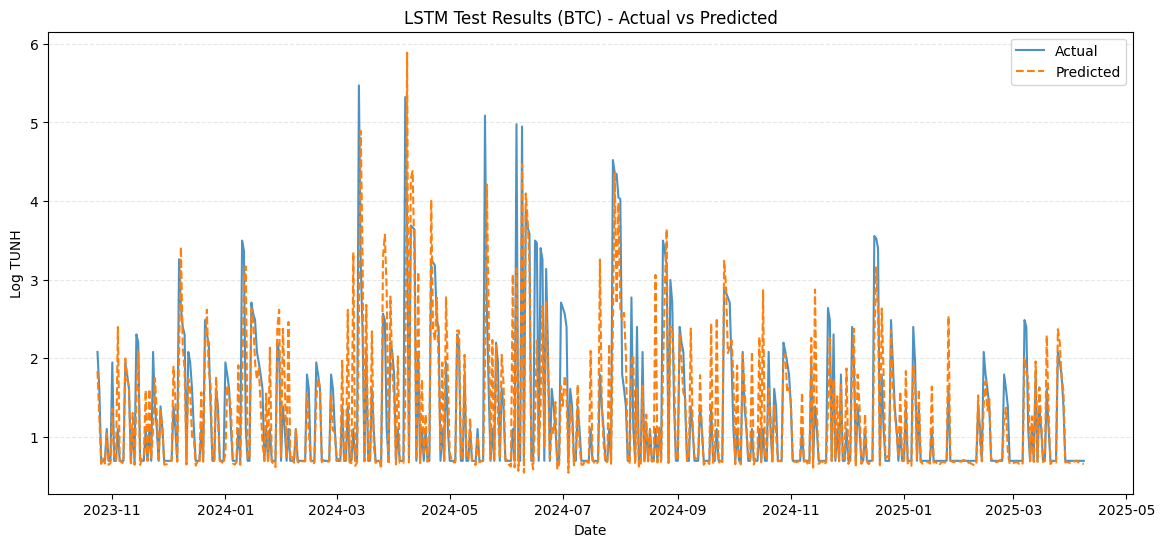

In [67]:
plot_log_results(
    df_test_btc_results,
    "LSTM Test Results (BTC) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/4. lstm/1a. test_results_log_btc.png'
)

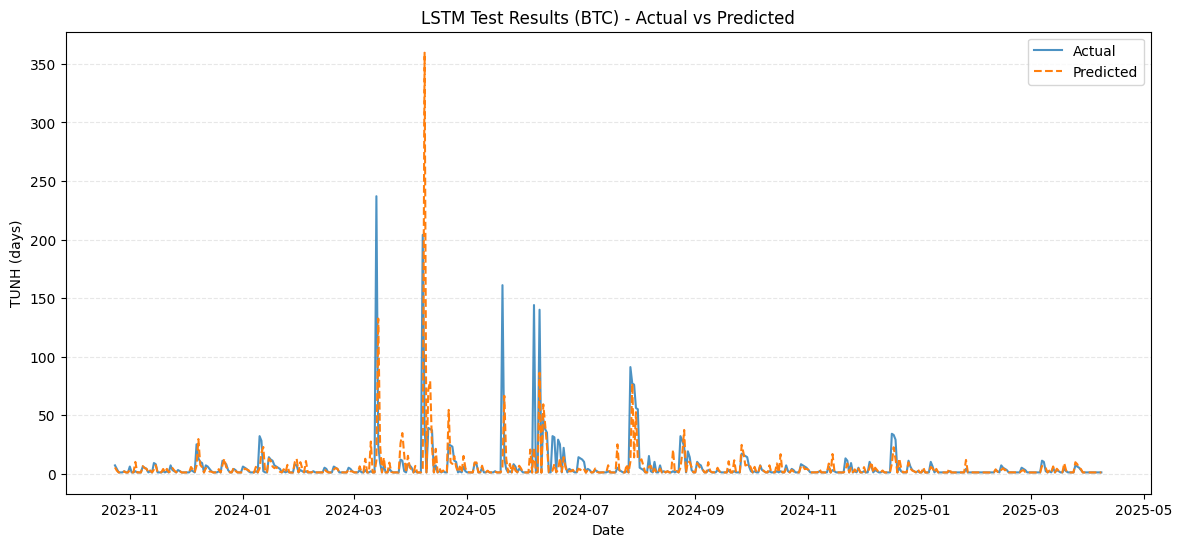

In [68]:
plot_results(
    df_test_days_btc,
    "LSTM Test Results (BTC) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/4. lstm/1b. test_results_btc.png'
)

### <span style='color:darkgoldenrod'>**Model 5:** MLP</span>

#### **Step 1:** Split the data for the MLP (80% Train - Next 10% Validation - 10% Test)

In [69]:
# ─── 1) SPLIT & SCALE ──────────────────────────────────────────────────────
split_index = int(len(X_btc) * 0.80)
wf_index    = int(len(X_btc) * 0.90)

X_tr_raw = X_btc.iloc[:split_index]
X_wf_raw = X_btc.iloc[split_index:wf_index]
X_te_raw = X_btc.iloc[wf_index:]

scaler = StandardScaler().fit(X_tr_raw)
X_train_btc_mlp  = pd.DataFrame(scaler.transform(X_tr_raw), index=X_tr_raw.index,  columns=X_btc.columns)
X_wf_btc_mlp  = pd.DataFrame(scaler.transform(X_wf_raw), index=X_wf_raw.index,  columns=X_btc.columns)
X_test_btc_mlp  = pd.DataFrame(scaler.transform(X_te_raw), index=X_te_raw.index,  columns=X_btc.columns)

y_train_btc_mlp = y_btc.reindex(X_train_btc_mlp.index).dropna()
X_train_btc_mlp = X_train_btc_mlp.loc[y_train_btc_mlp.index]
y_wf_btc_mlp = y_btc.reindex(X_wf_btc_mlp.index).dropna()
X_wf_btc_mlp = X_wf_btc_mlp.loc[y_wf_btc_mlp.index]
y_test_btc_mlp = y_btc.reindex(X_test_btc_mlp.index).dropna()
X_test_btc_mlp = X_test_btc_mlp.loc[y_test_btc_mlp.index]

#### **Step 2:** MLP Feature Selection

In [70]:
# 2) FEATURE SELECTION
selected = select_features(X_train_btc_mlp, y_train_btc_mlp).columns
X_train_selected_btc_mlp = X_train_btc_mlp[selected]
X_wf_selected_btc_mlp = X_wf_btc_mlp[selected]
X_test_selected_btc_mlp = X_test_btc_mlp[selected]

#### **Step 3:** MLP Build and Train

In [71]:
# ─── 3) ADD REGIME FLAG AS FEATURE ────────────────────────────────────────
# regime = 1 if next‐day TUNH faster (i.e. diff<0), else 0
reg_tr = (y_train_btc_mlp.diff().shift(-1) < 0).astype(int)
reg_wf = (y_wf_btc_mlp.diff().shift(-1) < 0).astype(int)
reg_te = (y_test_btc_mlp.diff().shift(-1) < 0).astype(int)

X_train_reg_btc_mlp = X_train_selected_btc_mlp.copy(); X_train_reg_btc_mlp['regime'] = reg_tr
X_wf_reg_btc_mlp = X_wf_selected_btc_mlp.copy(); X_wf_reg_btc_mlp['regime'] = reg_wf
X_test_reg_btc_mlp = X_test_selected_btc_mlp.copy(); X_test_reg_btc_mlp['regime'] = reg_te

In [72]:
X_train_int_btc_mlp = expand_with_regime_interactions(X_train_selected_btc_mlp, reg_tr)
X_wf_int_btc_mlp = expand_with_regime_interactions(X_wf_selected_btc_mlp, reg_wf)
X_test_int_btc_mlp = expand_with_regime_interactions(X_test_selected_btc_mlp, reg_te)

In [73]:
def build_mlp(input_dim, hidden_units=[512,256,128], dropout_rate=0.3, lr=1e-3):
    inp = Input(shape=(input_dim,))
    x = inp
    for h in hidden_units:
        x = Dense(h, activation="relu")(x)
        x = Dropout(dropout_rate)(x)
    out = Dense(1, activation="linear")(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr),
                loss="mean_absolute_error")
    return model

In [74]:
mlp = build_mlp(input_dim=X_train_int_btc_mlp.shape[1])
mlp.fit(X_train_int_btc_mlp.values, y_train_btc_mlp.values,
        validation_data=(X_wf_int_btc_mlp.values, y_wf_btc_mlp.values),
        epochs=50,
        batch_size=32,
        verbose=2)

Epoch 1/50
133/133 - 2s - 12ms/step - loss: 0.7782 - val_loss: 0.6167
Epoch 2/50
133/133 - 1s - 5ms/step - loss: 0.6265 - val_loss: 0.4678
Epoch 3/50
133/133 - 1s - 6ms/step - loss: 0.5460 - val_loss: 0.5585
Epoch 4/50
133/133 - 1s - 6ms/step - loss: 0.5169 - val_loss: 0.4292
Epoch 5/50
133/133 - 1s - 5ms/step - loss: 0.4988 - val_loss: 0.3986
Epoch 6/50
133/133 - 1s - 5ms/step - loss: 0.4751 - val_loss: 0.4599
Epoch 7/50
133/133 - 1s - 5ms/step - loss: 0.4520 - val_loss: 0.4703
Epoch 8/50
133/133 - 1s - 5ms/step - loss: 0.4413 - val_loss: 0.4174
Epoch 9/50
133/133 - 1s - 4ms/step - loss: 0.4275 - val_loss: 0.4077
Epoch 10/50
133/133 - 1s - 4ms/step - loss: 0.4258 - val_loss: 0.4361
Epoch 11/50
133/133 - 1s - 4ms/step - loss: 0.4068 - val_loss: 0.3847
Epoch 12/50
133/133 - 1s - 7ms/step - loss: 0.3996 - val_loss: 0.3833
Epoch 13/50
133/133 - 1s - 8ms/step - loss: 0.3939 - val_loss: 0.4038
Epoch 14/50
133/133 - 1s - 8ms/step - loss: 0.3781 - val_loss: 0.3514
Epoch 15/50
133/133 - 1s - 7

#### **Step 4:** MLP Walk-Forward Validation

In [75]:
wf_preds, wf_actuals, wf_indices = [], [], []
for start in range(0, len(X_wf_int_btc_mlp), 100):
    idx = X_wf_int_btc_mlp.index[start:start+100]
    end = min(start+100, len(X_wf_int_btc_mlp))
    p = mlp.predict(X_wf_int_btc_mlp.values[start:end]).flatten()
    wf_preds.append(p)
    wf_actuals.append(y_wf_btc_mlp.values[start:end])
    wf_indices.append(idx)
    MAE_wf, RMSE_wf, MAPE_wf, DA_wf = calculate_metrics(np.concatenate(wf_actuals), 
                                                        np.concatenate(wf_preds))
    print(f"WF ending {X_wf_int_btc_mlp.index[end-1]}: MAE={MAE_wf:.4f}, RMSE={RMSE_wf:.4f}, MAPE={MAPE_wf:.2f}%, DA={DA_wf:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
WF ending 2022-08-17: MAE=0.4804, RMSE=1.0006, MAPE=17.11%, DA=84.85%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 
WF ending 2022-11-25: MAE=0.4346, RMSE=0.8857, MAPE=17.29%, DA=85.43%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
WF ending 2023-03-05: MAE=0.3954, RMSE=0.8002, MAPE=16.68%, DA=86.62%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
WF ending 2023-06-13: MAE=0.4051, RMSE=0.8030, MAPE=17.18%, DA=86.97%
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
WF ending 2023-09-21: MAE=0.4008, RMSE=0.7843, MAPE=17.02%, DA=86.97%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
WF ending 2023-10-23: MAE=0.3923, RMSE=0.7703, MAPE=16.77%, DA=87.19%


#### **Step 5:** Evaluate MLP

In [76]:
y_train_pred_btc_mlp = mlp.predict(X_train_int_btc_mlp.values).flatten()
y_test_pred_btc_mlp = mlp.predict(X_test_int_btc_mlp.values).flatten()

MAE_train_btc_mlp, RMSE_train_btc_mlp, MAPE_train_btc_mlp, DA_train_btc_mlp = \
    calculate_metrics(y_train_btc_mlp.values, y_train_pred_btc_mlp)
MAE_test_btc_mlp, RMSE_test_btc_mlp, MAPE_test_btc_mlp, DA_test_btc_mlp = \
    calculate_metrics(y_test_btc_mlp.values, y_test_pred_btc_mlp)

print("MLP Train Metrics:")
print(f" MAE={MAE_train_btc_mlp:.5f}, RMSE={RMSE_train_btc_mlp:.5f}, MAPE={MAPE_train_btc_mlp:.2f}%, DA={DA_train_btc_mlp:.2f}%\n")

print("MLP Test Metrics:")
print(f" MAE={MAE_test_btc_mlp:.5f}, RMSE={RMSE_test_btc_mlp:.5f}, MAPE={MAPE_test_btc_mlp:.2f}%, DA={DA_test_btc_mlp:.2f}%")

133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MLP Train Metrics:
 MAE=0.32618, RMSE=0.69655, MAPE=12.12%, DA=90.81%

MLP Test Metrics:
 MAE=0.26939, RMSE=0.59254, MAPE=12.03%, DA=90.23%


In [77]:
# 1) WALK‑FORWARD DataFrame
#   - y_wf_all, y_wf_pred, idx_wf_all came from the regime‑split loop
df_wf_btc_results = pd.DataFrame({
    "Actual": np.concatenate(wf_actuals),
    "Predicted": np.concatenate(wf_preds)
}, index=pd.DatetimeIndex(np.concatenate(wf_indices)))

# 2) FINAL TEST DataFrame
#   - y_te and pred_te are your true & predicted log‑TUNH for the test period
df_test_btc_results = pd.DataFrame({
    "Actual":  y_test_btc_mlp.values,
    "Predicted": y_test_pred_btc_mlp
}, index=X_test_selected_btc_mlp.index)

# 3) convert back to days
df_test_days_btc = df_test_btc_results.copy()
df_test_days_btc["Actual_days"]    = np.expm1(df_test_days_btc["Actual"])
df_test_days_btc["Predicted_days"] = np.expm1(df_test_days_btc["Predicted"])
print("\nTest Results (in days):")
print(df_test_days_btc.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2023-10-24  2.079442   1.777894          7.0        4.917383
2023-10-25  1.609438   1.724210          4.0        4.608087
2023-10-26  0.693147   0.693021          1.0        0.999747
2023-10-27  0.693147   0.693021          1.0        0.999747
2023-10-28  0.693147   0.693021          1.0        0.999747


#### **Step 6:** MLP Plots

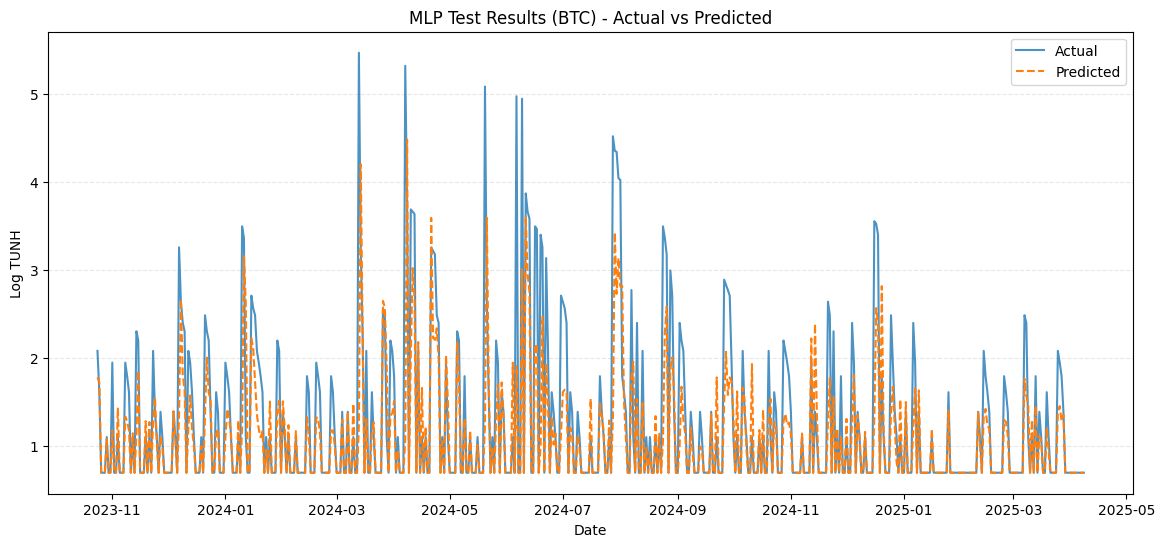

In [78]:
plot_log_results(
    df_test_btc_results,
    "MLP Test Results (BTC) - Actual vs Predicted",
    "Log TUNH",
    'Plots/6. test results/5. mlp/1a. test_results_log_btc.png'
)

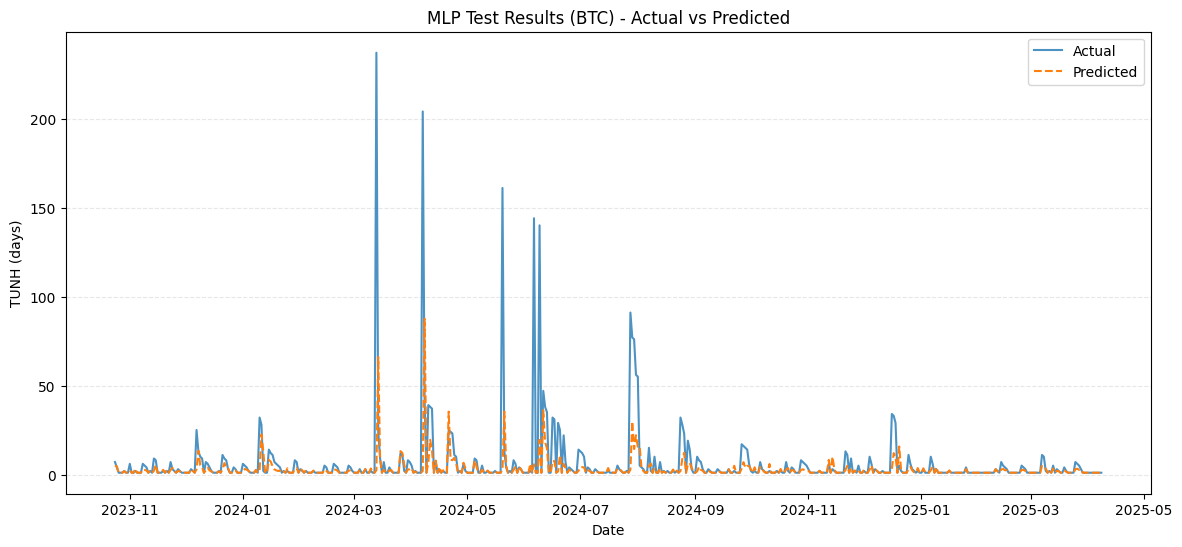

In [79]:
plot_results(
    df_test_days_btc,
    "MLP Test Results (BTC) - Actual vs Predicted",
    "TUNH (days)",
    'Plots/6. test results/5. mlp/1b. test_results_btc.png'
)

## <span style='color:brown'>**Stage C:** Comparison</span>

In [80]:
# Final metrics
model_names = ['SVR', 'Random Forest', 'XGBoost', 'LSTM', 'MLP']

train_rmse = [RMSE_train_btc_svr, RMSE_train_btc_rf, RMSE_train_btc_xgb, RMSE_train_btc_lstm, RMSE_train_btc_mlp]
test_rmse = [RMSE_test_btc_svr, RMSE_test_btc_rf, RMSE_test_btc_xgb, RMSE_test_btc_lstm, RMSE_test_btc_mlp]

train_mae = [MAE_train_btc_svr, MAE_train_btc_rf, MAE_train_btc_xgb, MAE_train_btc_lstm, MAE_train_btc_mlp]
test_mae = [MAE_test_btc_svr, MAE_test_btc_rf, MAE_test_btc_xgb, MAE_test_btc_lstm, MAE_test_btc_mlp]

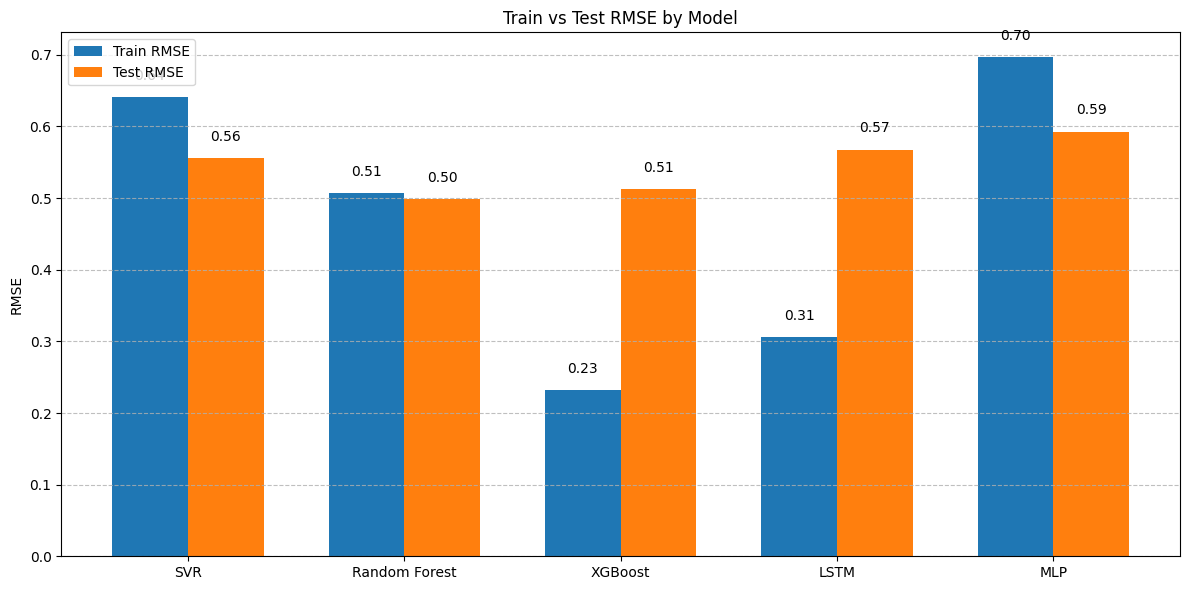

In [81]:
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_rmse, width, label='Train RMSE')
bars2 = ax.bar(x + width/2, test_rmse, width, label='Test RMSE')

ax.set_ylabel('RMSE')
ax.set_title('Train vs Test RMSE by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y',linestyle='--', alpha=0.8)

# Annotate bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.savefig('Plots/7. comparisons/1a. summary_rmse_btc.png', dpi=300)
plt.tight_layout()
plt.show()

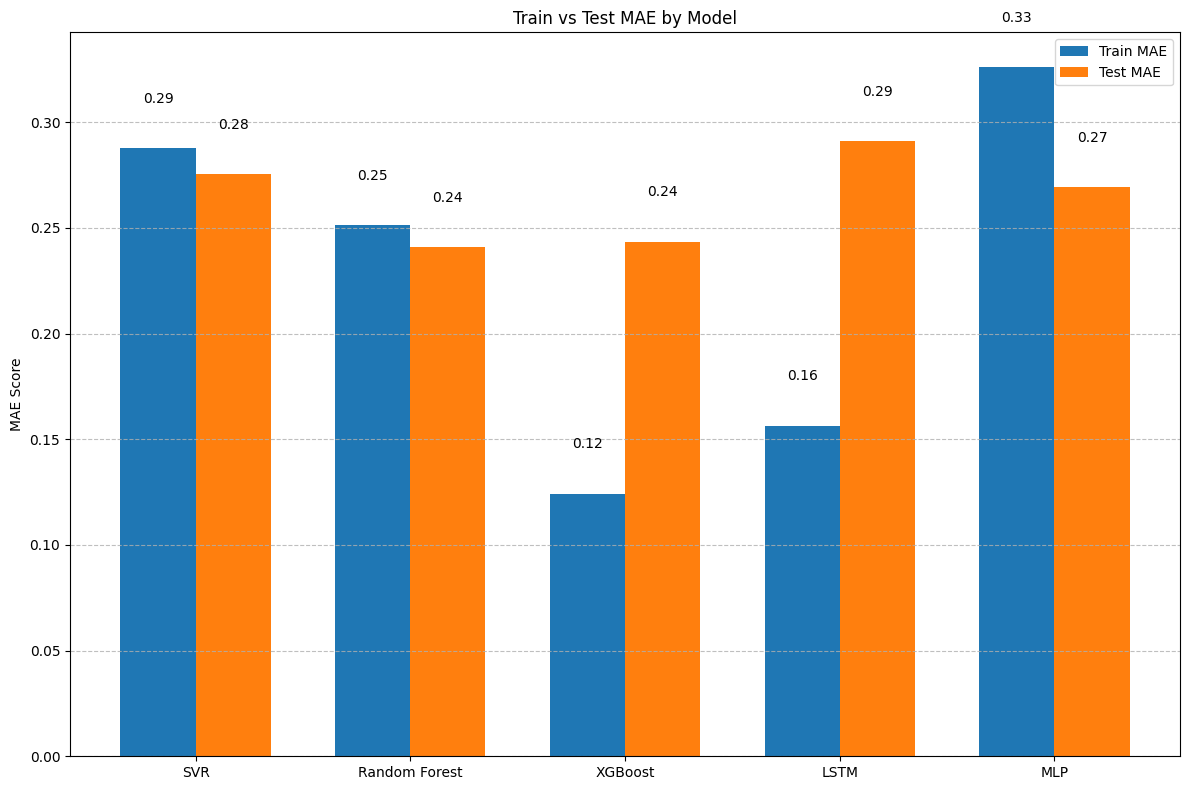

In [82]:
fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width/2, train_mae, width, label='Train MAE')
bars2 = ax.bar(x + width/2, test_mae, width, label='Test MAE')

ax.set_ylabel('MAE Score')
ax.set_title('Train vs Test MAE by Model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y',linestyle='--', alpha=0.8)

# Annotate bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')

plt.savefig('Plots/7. comparisons/1b. summary_mae_btc.png', dpi=300)
plt.tight_layout()
plt.show()

# **RQ2:** Feature Importance

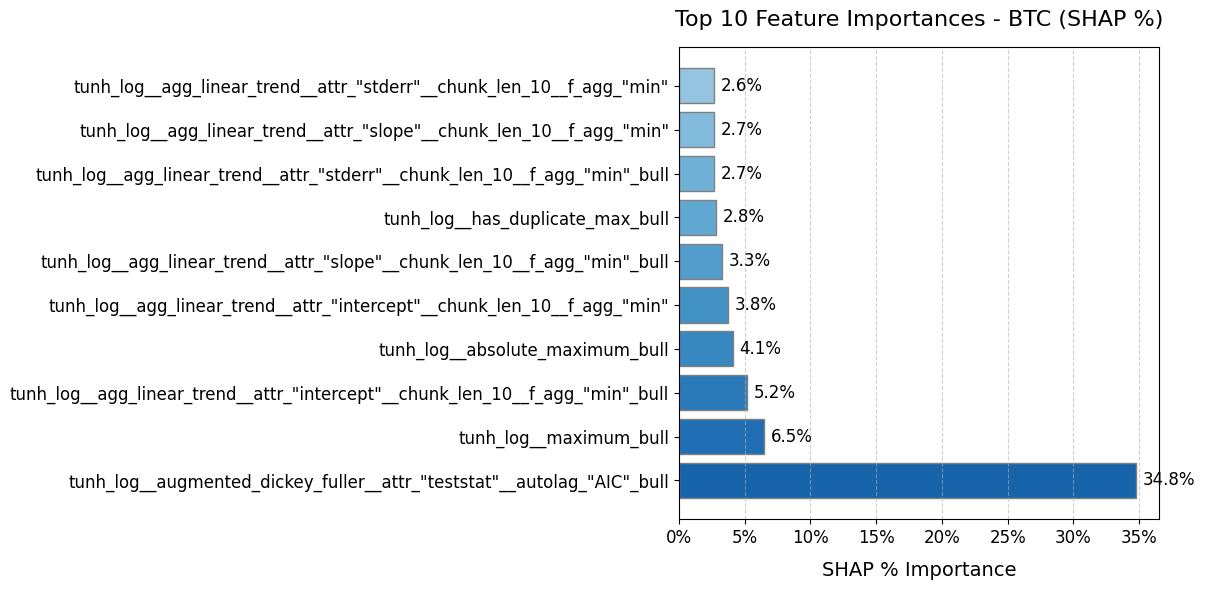

In [43]:
# ─── 1) Build a TreeExplainer for your trained RandomForest model ───────────
explainer = shap.TreeExplainer(best_rf)

# ─── 2) Compute SHAP values on the regime-interaction training set ──────────
#    This returns an array of shape (n_samples, n_features)
shap_vals = explainer.shap_values(X_train_int_btc_rf)

# ─── 3) Compute mean absolute SHAP per feature ─────────────────────────────
mean_abs_shap = np.abs(shap_vals).mean(axis=0)
shap_imp = pd.Series(mean_abs_shap, index=X_train_int_btc_rf.columns)

# ─── 4) Convert to percentage of total importance ─────────────────────────
shap_imp_pct = 100 * shap_imp / shap_imp.sum()

# ─── 5) Select the Top 10 features ────────────────────────────────────────
top10_shap = shap_imp_pct.sort_values(ascending=False).head(10)

# ─── 6) Plot as a horizontal bar chart ────────────────────────────────────
features = top10_shap.index.tolist()
values   = top10_shap.values

# reverse so the largest is on top
features = features[::-1]
values   = values[::-1]

# build a blue‐toned gradient
cmap = plt.get_cmap("Blues")
colors = cmap(np.linspace(0.4, 0.8, len(values)))

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(features, values, color=colors, edgecolor="gray")

# annotate each bar with its percentage
for bar, val in zip(bars, values):
    ax.text(
        bar.get_width() + 0.5,               # slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # vertically centered
        f"{val:.1f}%", 
        va="center", 
        fontsize=12
    )

# styling
ax.set_xlabel("SHAP % Importance", fontsize=14, labelpad=10)
ax.set_title("Top 10 Feature Importances - BTC (SHAP %)", fontsize=16, pad=15)
ax.xaxis.set_major_formatter(lambda x, pos: f"{int(x)}%")
ax.grid(axis="x", linestyle="--", alpha=0.6)
ax.invert_yaxis()  # largest on top
ax.tick_params(axis="y", labelsize=12)
ax.tick_params(axis="x", labelsize=12)

plt.savefig('Plots/8. feature importance/1. shap_rf_btc.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# **RQ3:** Cross-Crypto Generalization

## <span style='color:darkgreen'>**1) BTC VS PAXG**</span>

### <span style='color:brown'>**Stage A:** Preprocessing</span>

In [83]:
df_paxg = pd.read_csv("data/final_data_paxg.csv")
df_paxg['coin'] = 'PAXG'
df_paxg = df_paxg.rename(columns={"Date":"date"})
df_paxg["date"] = pd.to_datetime(df_paxg["date"])
df_paxg['Date'] = df_paxg['date'].dt.date
df_paxg['date'] = df_paxg['date'].dt.date
df_paxg = df_paxg.set_index('Date')
print(df_paxg.head())

                  date         Open         High          Low        Close   Volume  tunh  coin
Date                                                                                           
2019-09-26  2019-09-26  1522.969238  1540.213257  1499.900024  1516.510620  5337186   1.0  PAXG
2019-09-27  2019-09-27  1515.437378  1547.361206  1502.289062  1528.739990  2583554   1.0  PAXG
2019-09-28  2019-09-28  1525.926392  1553.475098  1508.814087  1525.717896  2243053   8.0  PAXG
2019-09-29  2019-09-29  1526.947998  1551.402344  1511.673950  1528.866577  1602218   7.0  PAXG
2019-09-30  2019-09-30  1528.866577  1538.616821  1497.364990  1513.878052  3023598   1.0  PAXG


In [84]:
df_paxg.isna().sum()

df_paxg['tunh'] = df_paxg['tunh'].ffill().bfill()

upper_limit = df_paxg['tunh'].quantile(0.99)
df_paxg['tunh_outlier'] = df_paxg['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_paxg['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_paxg):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

df_paxg = df_paxg[~df_paxg['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_paxg.shape}")
df_paxg.drop(columns=['tunh_outlier'], inplace=True)

Detected 21 outliers (1.04%) above the 99th percentile (243.86 days).
Final data shape after outlier removal: (2002, 9)


In [85]:
df_paxg['tunh_log'] = np.log1p(df_paxg['tunh'])
df_paxg.head()

df_paxg = df_paxg.drop(['tunh'], axis=1)

In [86]:
df_paxg_rolled = roll_time_series(df_paxg, column_id="coin", column_sort="date",
                            max_timeshift=20, min_timeshift=5)

X_paxg = extract_features(df_paxg_rolled.drop("coin", axis=1), 
                    column_id="id", column_sort="date", column_value="tunh_log", 
                    impute_function=impute, show_warnings=False)

X_paxg = X_paxg.set_index(X_paxg.index.map(lambda x: x[1]), drop=True)
X_paxg.index.name = "last_date"
X_paxg.head()

Feature Extraction: 100%|██████████| 20/20 [00:42<00:00,  2.12s/it]


tunh_log__variance_larger_than_standard_deviation  tunh_log__has_duplicate_max  tunh_log__has_duplicate_min  tunh_log__has_duplicate  tunh_log__sum_values  tunh_log__abs_energy  tunh_log__mean_abs_change  tunh_log__mean_change  tunh_log__mean_second_derivative_central  tunh_log__median  tunh_log__mean  tunh_log__length  tunh_log__standard_deviation  tunh_log__variation_coefficient  tunh_log__variance  tunh_log__skewness  tunh_log__kurtosis  tunh_log__root_mean_square  tunh_log__absolute_sum_of_changes  tunh_log__longest_strike_below_mean  tunh_log__longest_strike_above_mean  tunh_log__count_above_mean  tunh_log__count_below_mean  tunh_log__last_location_of_maximum  tunh_log__first_location_of_maximum  tunh_log__last_location_of_minimum  tunh_log__first_location_of_minimum  tunh_log__percentage_of_reoccurring_values_to_all_values  tunh_log__percentage_of_reoccurring_datapoints_to_all_datapoints  tunh_log__sum_of_reoccurring_values  tunh_log__sum_of_reoccurring_data_points  \
last_date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2019-10-01                                                0.0                          0.0                          1.0                      1.0              8.147867             13.803634                   0.821353               0.219722                                  0.137327          1.242453        1.357978               6.0                      0.675649                         0.497541            0.456502            0.123343           -3.011070                    1.516775                           4.106767                                  2.0                                  2.0                         3.0                         3.0                            0.500000                             0.333333                            0.833333                                  0.0                                               0.25                                                  0.500000                                            0.693147                                  2.079442   
2019-10-02                                                0.0                          0.0                          1.0                      1.0              9.246479             15.010583                   0.799986               0.067578                                 -0.069315          1.098612        1.320926               7.0                      0.632079                         0.478513            0.399524            0.337635           -2.310720                    1.464366                           4.799914                                  2.0                                  2.0                         3.0                         4.0                            0.428571                             0.285714                            0.714286                                  0.0                                               0.20                                                  0.428571                                            0.693147                                  2.079442   
2019-10-

In [87]:
y_paxg = df_paxg.set_index("date").sort_index().tunh_log.shift(-1)
y_paxg = y_paxg.dropna()

y_paxg = y_paxg[y_paxg.index.isin(X_paxg.index)]
X_paxg = X_paxg[X_paxg.index.isin(y_paxg.index)]

### <span style='color:brown'>**Stage B:** Modelling</span>

#### **Step 1:** Split the data

In [88]:
# BTC → 80% train / 10% wf
split_idx = int(len(X_btc) * 0.80)
wf_end    = int(len(X_btc) * 0.90)

X_btc_tr = X_btc.iloc[:split_idx]
X_btc_wf = X_btc.iloc[split_idx:wf_end]

# PAXG → first 10% few-shot, remaining 90% test
n_pax      = len(X_paxg)
few_end    = int(n_pax * 0.10)
X_paxg_few = X_paxg.iloc[:few_end]
X_paxg_te  = X_paxg.iloc[few_end:]

# scale on BTC-train
scaler = StandardScaler().fit(X_btc_tr)
def scale(df): return pd.DataFrame(scaler.transform(df), index=df.index, columns=X_btc.columns)

X_tr  = scale(X_btc_tr)
X_wf  = scale(X_btc_wf)
X_few = scale(X_paxg_few)
X_te  = scale(X_paxg_te)

# align targets
y_tr  = y_btc.reindex(X_tr.index).dropna();  X_tr  = X_tr.loc[y_tr.index]
y_wf  = y_btc.reindex(X_wf.index).dropna();  X_wf  = X_wf.loc[y_wf.index]
y_few = y_paxg.reindex(X_few.index).dropna();X_few = X_few.loc[y_few.index]
y_te  = y_paxg.reindex(X_te.index).dropna(); X_te  = X_te.loc[y_te.index]

#### **Step 2:** Feature Selection

In [89]:
# 1) feature-select on BTC-train only
sel       = select_features(X_tr, y_tr).columns
X_tr_sel  = X_tr[sel]
X_wf_sel  = X_wf[sel]
X_few_sel = X_few[sel]
X_te_sel  = X_te[sel]

# 2) regime flags
reg_tr  = (y_tr.diff().shift(-1)  < 0).astype(int)
reg_wf  = (y_wf.diff().shift(-1)  < 0).astype(int)
reg_few = (y_few.diff().shift(-1) < 0).astype(int)
reg_te  = (y_te.diff().shift(-1)  < 0).astype(int)

# 3) expand interactions
def expand_with_regime_interactions(X, reg):
    Xexp = pd.DataFrame(index=X.index)
    Xexp[X.columns] = X
    Xexp[[f"{c}_bull" for c in X.columns]] = X.values * reg.values[:,None]
    Xexp[[f"{c}_bear" for c in X.columns]] = X.values * (1-reg.values)[:,None]
    return Xexp

X_tr_int  = expand_with_regime_interactions(X_tr_sel,  reg_tr)
X_wf_int  = expand_with_regime_interactions(X_wf_sel,  reg_wf)
X_few_int = expand_with_regime_interactions(X_few_sel, reg_few)
X_te_int  = expand_with_regime_interactions(X_te_sel,  reg_te)

#### **Step 3:** Pre-train on BTC

In [90]:
# pre-train
mlp.fit(
    X_tr_int.values, y_tr.values,
    validation_data=(X_wf_int.values, y_wf.values),
    epochs=100,
    batch_size=64,
    verbose=2
)

Epoch 1/100
67/67 - 2s - 30ms/step - loss: 0.2879 - val_loss: 0.3961
Epoch 2/100
67/67 - 1s - 13ms/step - loss: 0.2737 - val_loss: 0.3791
Epoch 3/100
67/67 - 1s - 14ms/step - loss: 0.2740 - val_loss: 0.3822
Epoch 4/100
67/67 - 1s - 13ms/step - loss: 0.2714 - val_loss: 0.3869
Epoch 5/100
67/67 - 1s - 15ms/step - loss: 0.2644 - val_loss: 0.3922
Epoch 6/100
67/67 - 1s - 14ms/step - loss: 0.2589 - val_loss: 0.4072
Epoch 7/100
67/67 - 1s - 14ms/step - loss: 0.2666 - val_loss: 0.3979
Epoch 8/100
67/67 - 1s - 12ms/step - loss: 0.2661 - val_loss: 0.4150
Epoch 9/100
67/67 - 1s - 11ms/step - loss: 0.2653 - val_loss: 0.4302
Epoch 10/100
67/67 - 1s - 13ms/step - loss: 0.2677 - val_loss: 0.3877
Epoch 11/100
67/67 - 1s - 15ms/step - loss: 0.2654 - val_loss: 0.3846
Epoch 12/100
67/67 - 2s - 23ms/step - loss: 0.2577 - val_loss: 0.4230
Epoch 13/100
67/67 - 1s - 17ms/step - loss: 0.2580 - val_loss: 0.3954
Epoch 14/100
67/67 - 2s - 34ms/step - loss: 0.2607 - val_loss: 0.3882
Epoch 15/100
67/67 - 4s - 58m

#### **Step 4:** Fine-tune on PAXG

In [91]:
n = len(X_te_int)
n_ft = max(10, int(n*0.1))   # at least 10 samples
X_ft = X_te_int.iloc[:n_ft]
y_ft = y_te.iloc[:n_ft]
X_final = X_te_int.iloc[n_ft:]
y_final = y_te.iloc[n_ft:]

In [92]:
# lower learning-rate for fine-tuning
mlp.compile(optimizer=Adam(1e-4),
            loss="mean_absolute_error")

mlp.fit(
    X_ft.values, y_ft.values,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
    verbose=2
)

Epoch 1/50
9/9 - 4s - 415ms/step - loss: 0.2586 - val_loss: 0.3893
Epoch 2/50
9/9 - 0s - 36ms/step - loss: 0.2489 - val_loss: 0.3965
Epoch 3/50
9/9 - 0s - 35ms/step - loss: 0.2121 - val_loss: 0.3947
Epoch 4/50
9/9 - 0s - 31ms/step - loss: 0.2265 - val_loss: 0.3832
Epoch 5/50
9/9 - 0s - 36ms/step - loss: 0.2279 - val_loss: 0.3758
Epoch 6/50
9/9 - 0s - 46ms/step - loss: 0.2051 - val_loss: 0.3690
Epoch 7/50
9/9 - 0s - 39ms/step - loss: 0.2100 - val_loss: 0.3666
Epoch 8/50
9/9 - 0s - 36ms/step - loss: 0.2084 - val_loss: 0.3684
Epoch 9/50
9/9 - 0s - 40ms/step - loss: 0.1856 - val_loss: 0.3683
Epoch 10/50
9/9 - 0s - 29ms/step - loss: 0.1824 - val_loss: 0.3674
Epoch 11/50
9/9 - 0s - 50ms/step - loss: 0.1740 - val_loss: 0.3609
Epoch 12/50
9/9 - 0s - 44ms/step - loss: 0.1813 - val_loss: 0.3599
Epoch 13/50
9/9 - 0s - 47ms/step - loss: 0.1758 - val_loss: 0.3621
Epoch 14/50
9/9 - 0s - 25ms/step - loss: 0.1744 - val_loss: 0.3655
Epoch 15/50
9/9 - 0s - 29ms/step - loss: 0.1469 - val_loss: 0.3675
Epo

#### **Step 5:** Evaluate on PAXG

In [93]:
y_pred = mlp.predict(X_final.values).flatten()
MAE, RMSE, MAPE, DA = calculate_metrics(y_final.values, y_pred)
print(" Few-Shot PAXG Final Test Metrics:")
print(f" MAE={MAE:.5f}, RMSE={RMSE:.5f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 Few-Shot PAXG Final Test Metrics:
 MAE=0.39295, RMSE=0.79444, MAPE=16.32%, DA=87.14%


In [94]:
df_results = pd.DataFrame({
    "Actual":    y_final.values,
    "Predicted": y_pred
}, index=y_final.index)

# Also add back “days” scale if you like
df_results["Actual_days"]    = np.expm1(df_results["Actual"])
df_results["Predicted_days"] = np.expm1(df_results["Predicted"])

print("\nTest Results (in days):")
print(df_results.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2020-10-15  1.386294   1.108549          3.0        2.029958
2020-10-16  1.098612   1.095384          2.0        1.990331
2020-10-17  0.693147   0.693149          1.0        1.000004
2020-10-18  0.693147   0.693149          1.0        1.000004
2020-10-19  0.693147   0.693149          1.0        1.000004


#### **Step 6:** Plot

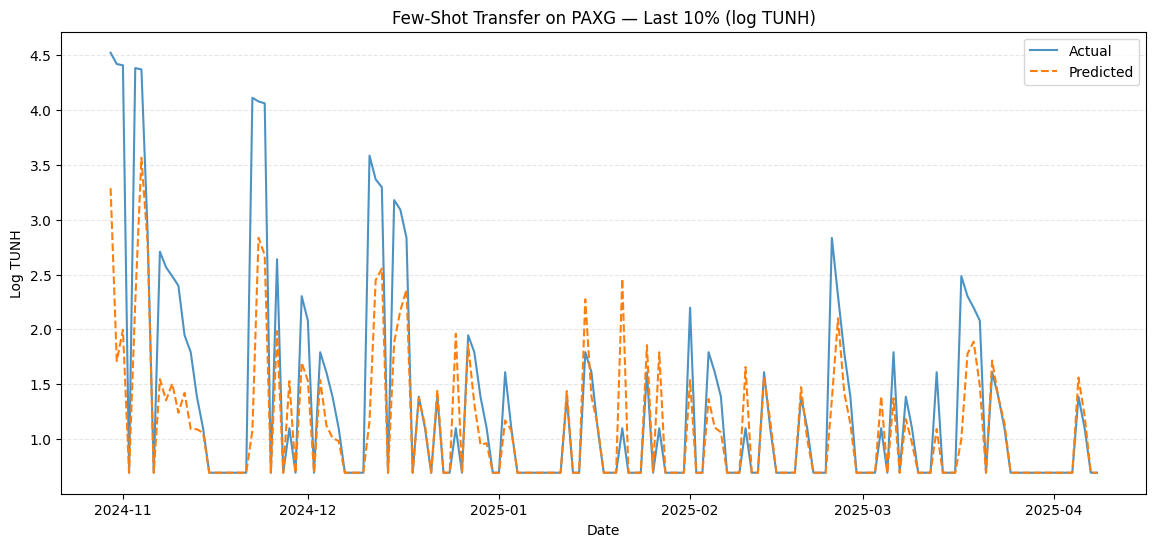

In [95]:
n_last = int(len(df_results) * 0.10)
df_last = df_results.tail(n_last)

plot_log_results(
    df_last,
    "Few-Shot Transfer on PAXG — Last 10% (log TUNH)",
    "Log TUNH",
    'Plots/9. cross generalization/1a. btc_paxg_log.png'
)

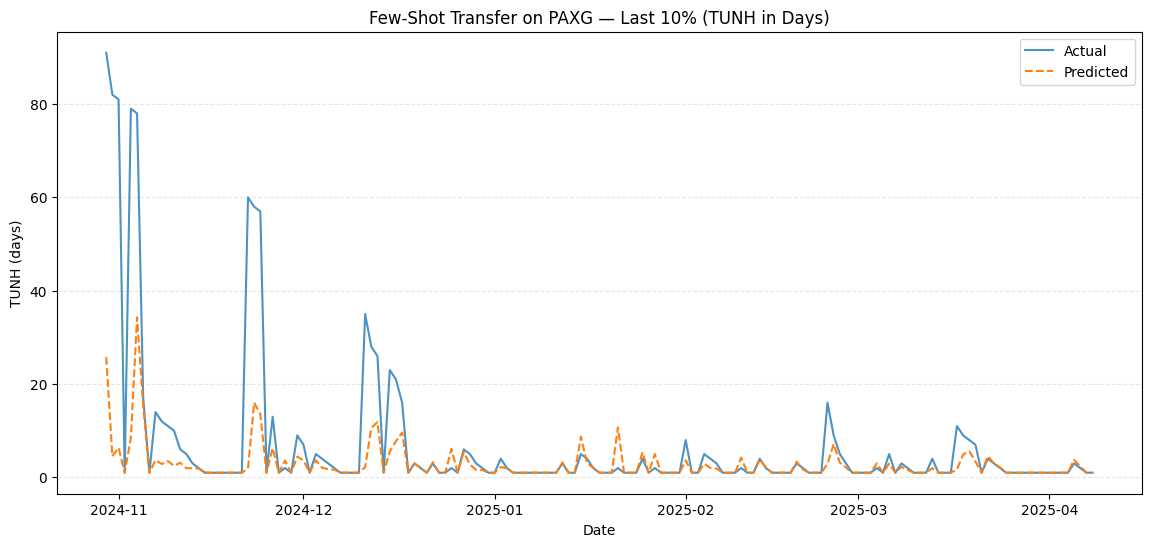

In [96]:
plot_results(df_last,
    "Few-Shot Transfer on PAXG — Last 10% (TUNH in Days)",
    "TUNH (days)",
    'Plots/9. cross generalization/1b. btc_paxg.png'
)

## <span style='color:darkgreen'>**2) BTC VS ETH**</span>

### <span style='color:brown'>**Stage A:** Preprocessing</span>

In [97]:
df_eth = pd.read_csv("data/final_data_ETH.csv")
df_eth['coin'] = 'ETH'
df_eth = df_eth.rename(columns={"Date":"date"})
df_eth["date"] = pd.to_datetime(df_eth["date"])
df_eth['Date'] = df_eth['date'].dt.date
df_eth['date'] = df_eth['date'].dt.date
df_eth = df_eth.set_index('Date')
print(df_eth.head())

                  date        Open        High         Low       Close      Volume  tunh coin
Date                                                                                         
2017-11-09  2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   5.0  ETH
2017-11-10  2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   3.0  ETH
2017-11-11  2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   2.0  ETH
2017-11-12  2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   1.0  ETH
2017-11-13  2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   1.0  ETH


In [98]:
df_eth['tunh'] = df_eth['tunh'].ffill().bfill()

upper_limit = df_eth['tunh'].quantile(0.99)
df_eth['tunh_outlier'] = df_eth['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_eth['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_eth):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

df_eth = df_eth[~df_eth['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_eth.shape}")
df_eth.drop(columns=['tunh_outlier'], inplace=True)

df_eth['tunh_log'] = np.log1p(df_eth['tunh'])

df_eth = df_eth.drop(['tunh'], axis=1)

Detected 28 outliers (1.03%) above the 99th percentile (949.12 days).
Final data shape after outlier removal: (2681, 9)


In [99]:
df_eth_rolled = roll_time_series(df_eth, column_id="coin", column_sort="date",
                            max_timeshift=20, min_timeshift=5)

X_eth = extract_features(df_eth_rolled.drop("coin", axis=1), 
                    column_id="id", column_sort="date", column_value="tunh_log", 
                    impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


In [100]:
X_eth = X_eth.set_index(X_eth.index.map(lambda x: x[1]), drop=True)
X_eth.index.name = "last_date"

y_eth = df_eth.set_index("date").sort_index().tunh_log.shift(-1)

y_eth = y_eth.dropna()

y_eth = y_eth[y_eth.index.isin(X_eth.index)]
X_eth = X_eth[X_eth.index.isin(y_eth.index)]

### <span style='color:brown'>**Stage B:** Modelling</span>

#### **Step 1:** Split the data

In [101]:
# BTC → 80% train / 10% wf
split_idx = int(len(X_btc) * 0.80)
wf_end    = int(len(X_btc) * 0.90)

X_btc_tr = X_btc.iloc[:split_idx]
X_btc_wf = X_btc.iloc[split_idx:wf_end]

# ETH → first 10% few-shot, remaining 90% test
n_pax      = len(X_eth)
few_end    = int(n_pax * 0.10)
X_eth_few = X_eth.iloc[:few_end]
X_eth_te  = X_eth.iloc[few_end:]

# scale on BTC-train
scaler = StandardScaler().fit(X_btc_tr)
def scale(df): return pd.DataFrame(scaler.transform(df), index=df.index, columns=X_btc.columns)

X_tr  = scale(X_btc_tr)
X_wf  = scale(X_btc_wf)
X_few = scale(X_eth_few)
X_te  = scale(X_eth_te)

# align targets
y_tr  = y_btc.reindex(X_tr.index).dropna();  X_tr  = X_tr.loc[y_tr.index]
y_wf  = y_btc.reindex(X_wf.index).dropna();  X_wf  = X_wf.loc[y_wf.index]
y_few = y_eth.reindex(X_few.index).dropna();X_few = X_few.loc[y_few.index]
y_te  = y_eth.reindex(X_te.index).dropna(); X_te  = X_te.loc[y_te.index]

#### **Step 2:** Feature Selection

In [102]:
# 1) feature-select on BTC-train only
sel       = select_features(X_tr, y_tr).columns
X_tr_sel  = X_tr[sel]
X_wf_sel  = X_wf[sel]
X_few_sel = X_few[sel]
X_te_sel  = X_te[sel]

# 2) regime flags
reg_tr  = (y_tr.diff().shift(-1)  < 0).astype(int)
reg_wf  = (y_wf.diff().shift(-1)  < 0).astype(int)
reg_few = (y_few.diff().shift(-1) < 0).astype(int)
reg_te  = (y_te.diff().shift(-1)  < 0).astype(int)

# 3) expand interactions
X_tr_int  = expand_with_regime_interactions(X_tr_sel,  reg_tr)
X_wf_int  = expand_with_regime_interactions(X_wf_sel,  reg_wf)
X_few_int = expand_with_regime_interactions(X_few_sel, reg_few)
X_te_int  = expand_with_regime_interactions(X_te_sel,  reg_te)

#### **Step 3:** Pre-train on BTC

In [103]:
# pre-train
mlp.fit(
    X_tr_int.values, y_tr.values,
    validation_data=(X_wf_int.values, y_wf.values),
    epochs=100,
    batch_size=64,
    verbose=2
)

Epoch 1/100
67/67 - 0s - 7ms/step - loss: 0.2233 - val_loss: 0.4178
Epoch 2/100
67/67 - 0s - 5ms/step - loss: 0.2121 - val_loss: 0.4171
Epoch 3/100
67/67 - 0s - 5ms/step - loss: 0.1933 - val_loss: 0.4137
Epoch 4/100
67/67 - 0s - 5ms/step - loss: 0.1907 - val_loss: 0.4246
Epoch 5/100
67/67 - 0s - 5ms/step - loss: 0.1912 - val_loss: 0.4051
Epoch 6/100
67/67 - 0s - 5ms/step - loss: 0.1882 - val_loss: 0.4040
Epoch 7/100
67/67 - 0s - 5ms/step - loss: 0.1767 - val_loss: 0.4037
Epoch 8/100
67/67 - 0s - 5ms/step - loss: 0.1838 - val_loss: 0.4060
Epoch 9/100
67/67 - 0s - 5ms/step - loss: 0.1766 - val_loss: 0.4108
Epoch 10/100
67/67 - 0s - 5ms/step - loss: 0.1756 - val_loss: 0.4010
Epoch 11/100
67/67 - 0s - 5ms/step - loss: 0.1766 - val_loss: 0.4038
Epoch 12/100
67/67 - 0s - 5ms/step - loss: 0.1766 - val_loss: 0.4025
Epoch 13/100
67/67 - 0s - 6ms/step - loss: 0.1827 - val_loss: 0.4025
Epoch 14/100
67/67 - 0s - 5ms/step - loss: 0.1709 - val_loss: 0.4057
Epoch 15/100
67/67 - 0s - 5ms/step - loss: 

#### **Step 4:** Fine-tune on ETH

In [104]:
n = len(X_te_int)
n_ft = max(10, int(n*0.1))   # at least 10 samples
X_ft = X_te_int.iloc[:n_ft]
y_ft = y_te.iloc[:n_ft]
X_final = X_te_int.iloc[n_ft:]
y_final = y_te.iloc[n_ft:]

In [105]:
# lower learning-rate for fine-tuning
mlp.compile(optimizer=Adam(1e-4),
            loss="mean_absolute_error")

mlp.fit(
    X_ft.values, y_ft.values,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
    verbose=2
)

Epoch 1/50
12/12 - 1s - 52ms/step - loss: 0.5775 - val_loss: 0.2503
Epoch 2/50
12/12 - 0s - 6ms/step - loss: 0.5121 - val_loss: 0.2518
Epoch 3/50
12/12 - 0s - 6ms/step - loss: 0.4669 - val_loss: 0.2502
Epoch 4/50
12/12 - 0s - 7ms/step - loss: 0.4476 - val_loss: 0.2450
Epoch 5/50
12/12 - 0s - 6ms/step - loss: 0.4621 - val_loss: 0.2464
Epoch 6/50
12/12 - 0s - 5ms/step - loss: 0.4247 - val_loss: 0.2543
Epoch 7/50
12/12 - 0s - 6ms/step - loss: 0.4581 - val_loss: 0.2579
Epoch 8/50
12/12 - 0s - 6ms/step - loss: 0.4138 - val_loss: 0.2515
Epoch 9/50
12/12 - 0s - 6ms/step - loss: 0.4177 - val_loss: 0.2544
Epoch 10/50
12/12 - 0s - 6ms/step - loss: 0.3779 - val_loss: 0.2555
Epoch 11/50
12/12 - 0s - 7ms/step - loss: 0.4267 - val_loss: 0.2568
Epoch 12/50
12/12 - 0s - 6ms/step - loss: 0.4029 - val_loss: 0.2589
Epoch 13/50
12/12 - 0s - 6ms/step - loss: 0.4073 - val_loss: 0.2586
Epoch 14/50
12/12 - 0s - 7ms/step - loss: 0.3914 - val_loss: 0.2529
Epoch 15/50
12/12 - 0s - 6ms/step - loss: 0.3553 - val_l

#### **Step 5:** Evaluate on ETH

In [110]:
y_pred = mlp.predict(X_final.values).flatten()
MAE, RMSE, MAPE, DA = calculate_metrics(y_final.values, y_pred)
print(" Few-Shot ETH Final Test Metrics:")
print(f" MAE={MAE:.5f}, RMSE={RMSE:.5f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
 Few-Shot ETH Final Test Metrics:
 MAE=0.39022, RMSE=0.79518, MAPE=17.59%, DA=88.19%


In [107]:
df_results = pd.DataFrame({
    "Actual":    y_final.values,
    "Predicted": y_pred
}, index=y_final.index)

# Also add back “days” scale if you like
df_results["Actual_days"]    = np.expm1(df_results["Actual"])
df_results["Predicted_days"] = np.expm1(df_results["Predicted"])

print("\nTest Results (in days):")
print(df_results.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2019-05-03  1.098612   1.748691          2.0        4.747074
2019-05-04  0.693147   0.693272          1.0        1.000249
2019-05-05  0.693147   0.693272          1.0        1.000249
2019-05-06  1.609438   2.909571          4.0       17.348919
2019-05-07  0.693147   0.693272          1.0        1.000249


#### **Step 7:** Plot

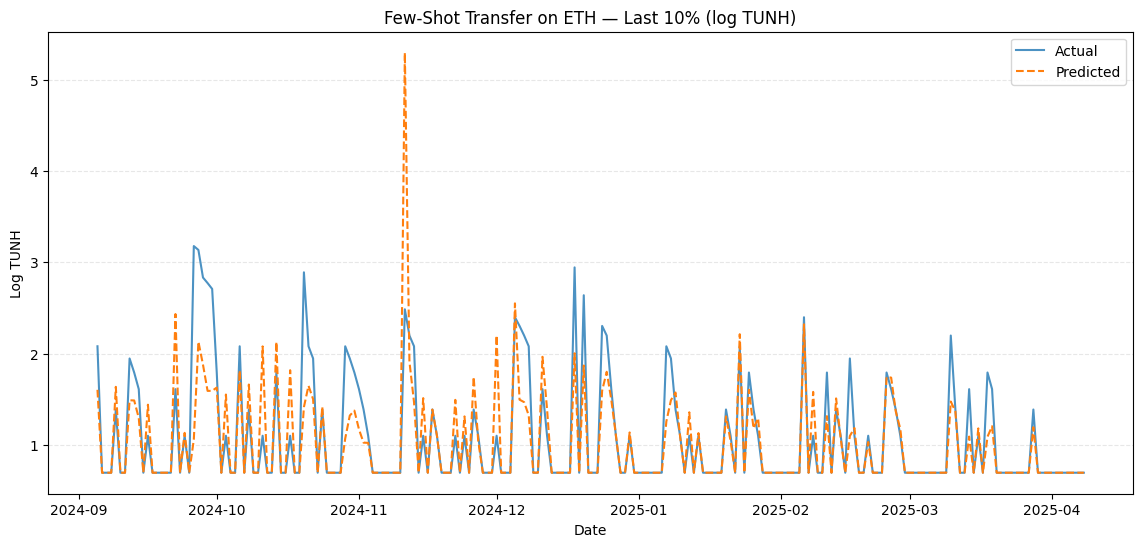

In [111]:
n_last = int(len(df_results) * 0.10)
df_last = df_results.tail(n_last)

plot_log_results(
    df_last,
    "Few-Shot Transfer on ETH — Last 10% (log TUNH)",
    "Log TUNH",
    'Plots/9. cross generalization/2a. btc_eth_log.png'
)

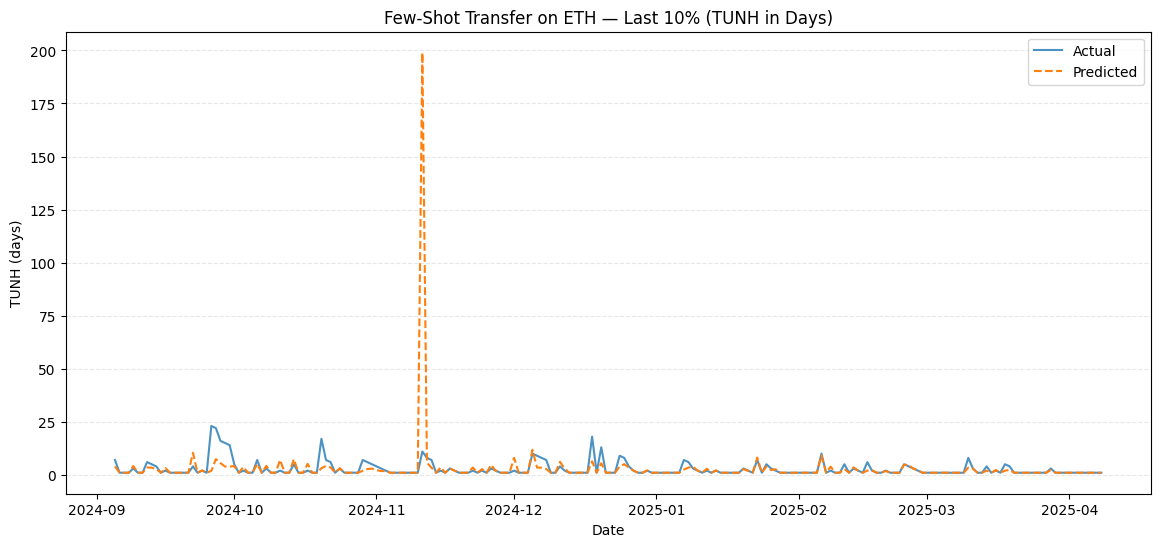

In [112]:
plot_results(
    df_last,
    "Few-Shot Transfer on ETH — Last 10% (TUNH in Days)",
    "TUNH (days)",
    'Plots/9. cross generalization/2b. btc_eth.png'
)

## <span style='color:darkgreen'>**3) BTC VS BNB**</span>

### <span style='color:brown'>**Stage A:** Preprocessing</span>

In [113]:
df_bnb = pd.read_csv("data/final_data_bnb.csv")
df_bnb['coin'] = 'BNB'
df_bnb = df_bnb.rename(columns={"Date":"date"})
df_bnb["date"] = pd.to_datetime(df_bnb["date"])
df_bnb['Date'] = df_bnb['date'].dt.date
df_bnb['date'] = df_bnb['date'].dt.date
df_bnb = df_bnb.set_index('Date')
print(df_bnb.head())

                  date     Open     High      Low    Close    Volume  tunh coin
Date                                                                           
2017-11-09  2017-11-09  2.05314  2.17423  1.89394  1.99077  19192200  24.0  BNB
2017-11-10  2017-11-10  2.00773  2.06947  1.64478  1.79684  11155000  21.0  BNB
2017-11-11  2017-11-11  1.78628  1.91775  1.61429  1.67047   8178150  14.0  BNB
2017-11-12  2017-11-12  1.66889  1.67280  1.46256  1.51969  15298700   1.0  BNB
2017-11-13  2017-11-13  1.52601  1.73502  1.51760  1.68662  12238800   1.0  BNB


In [114]:
df_bnb['tunh'] = df_bnb['tunh'].ffill().bfill()

upper_limit = df_bnb['tunh'].quantile(0.99)
df_bnb['tunh_outlier'] = df_bnb['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_bnb['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_bnb):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

df_bnb = df_bnb[~df_bnb['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_bnb.shape}")
df_bnb.drop(columns=['tunh_outlier'], inplace=True)

df_bnb['tunh_log'] = np.log1p(df_bnb['tunh'])

df_bnb = df_bnb.drop(['tunh'], axis=1)

Detected 28 outliers (1.03%) above the 99th percentile (685.36 days).
Final data shape after outlier removal: (2681, 9)


In [115]:
df_bnb_rolled = roll_time_series(df_bnb, column_id="coin", column_sort="date",
                            max_timeshift=20, min_timeshift=5)

X_bnb = extract_features(df_bnb_rolled.drop("coin", axis=1), 
                    column_id="id", column_sort="date", column_value="tunh_log", 
                    impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


In [116]:
X_bnb = X_bnb.set_index(X_bnb.index.map(lambda x: x[1]), drop=True)
X_bnb.index.name = "last_date"

y_bnb = df_bnb.set_index("date").sort_index().tunh_log.shift(-1)

y_bnb = y_bnb.dropna()

y_bnb = y_bnb[y_bnb.index.isin(X_bnb.index)]
X_bnb = X_bnb[X_bnb.index.isin(y_bnb.index)]

### <span style='color:brown'>**Stage B:** Modelling</span>

#### **Step 1:** Split the data

In [117]:
# BTC → 80% train / 10% wf
split_idx = int(len(X_btc) * 0.80)
wf_end    = int(len(X_btc) * 0.90)

X_btc_tr = X_btc.iloc[:split_idx]
X_btc_wf = X_btc.iloc[split_idx:wf_end]

# BNB → first 10% few-shot, remaining 90% test
n_pax      = len(X_bnb)
few_end    = int(n_pax * 0.10)
X_bnb_few = X_bnb.iloc[:few_end]
X_bnb_te  = X_bnb.iloc[few_end:]

# scale on BTC-train
scaler = StandardScaler().fit(X_btc_tr)
def scale(df): return pd.DataFrame(scaler.transform(df), index=df.index, columns=X_btc.columns)

X_tr  = scale(X_btc_tr)
X_wf  = scale(X_btc_wf)
X_few = scale(X_bnb_few)
X_te  = scale(X_bnb_te)

# align targets
y_tr  = y_btc.reindex(X_tr.index).dropna();  X_tr  = X_tr.loc[y_tr.index]
y_wf  = y_btc.reindex(X_wf.index).dropna();  X_wf  = X_wf.loc[y_wf.index]
y_few = y_bnb.reindex(X_few.index).dropna();X_few = X_few.loc[y_few.index]
y_te  = y_bnb.reindex(X_te.index).dropna(); X_te  = X_te.loc[y_te.index]

#### **Step 2:** Feature Selection

In [118]:
# 1) feature-select on BTC-train only
sel       = select_features(X_tr, y_tr).columns
X_tr_sel  = X_tr[sel]
X_wf_sel  = X_wf[sel]
X_few_sel = X_few[sel]
X_te_sel  = X_te[sel]

# 2) regime flags
reg_tr  = (y_tr.diff().shift(-1)  < 0).astype(int)
reg_wf  = (y_wf.diff().shift(-1)  < 0).astype(int)
reg_few = (y_few.diff().shift(-1) < 0).astype(int)
reg_te  = (y_te.diff().shift(-1)  < 0).astype(int)

# 3) expand interactions
X_tr_int  = expand_with_regime_interactions(X_tr_sel,  reg_tr)
X_wf_int  = expand_with_regime_interactions(X_wf_sel,  reg_wf)
X_few_int = expand_with_regime_interactions(X_few_sel, reg_few)
X_te_int  = expand_with_regime_interactions(X_te_sel,  reg_te)

#### **Step 3:** Pre-train on BTC

In [119]:
# pre-train
mlp.fit(
    X_tr_int.values, y_tr.values,
    validation_data=(X_wf_int.values, y_wf.values),
    epochs=100,
    batch_size=64,
    verbose=2
)

Epoch 1/100
67/67 - 1s - 9ms/step - loss: 0.1677 - val_loss: 0.4074
Epoch 2/100
67/67 - 0s - 4ms/step - loss: 0.1594 - val_loss: 0.4093
Epoch 3/100
67/67 - 0s - 4ms/step - loss: 0.1572 - val_loss: 0.4111
Epoch 4/100
67/67 - 0s - 4ms/step - loss: 0.1551 - val_loss: 0.4037
Epoch 5/100
67/67 - 0s - 4ms/step - loss: 0.1532 - val_loss: 0.4104
Epoch 6/100
67/67 - 0s - 5ms/step - loss: 0.1550 - val_loss: 0.4016
Epoch 7/100
67/67 - 0s - 4ms/step - loss: 0.1538 - val_loss: 0.4045
Epoch 8/100
67/67 - 0s - 4ms/step - loss: 0.1542 - val_loss: 0.4108
Epoch 9/100
67/67 - 0s - 4ms/step - loss: 0.1577 - val_loss: 0.4085
Epoch 10/100
67/67 - 0s - 4ms/step - loss: 0.1507 - val_loss: 0.4063
Epoch 11/100
67/67 - 0s - 4ms/step - loss: 0.1532 - val_loss: 0.4070
Epoch 12/100
67/67 - 0s - 4ms/step - loss: 0.1520 - val_loss: 0.4008
Epoch 13/100
67/67 - 0s - 4ms/step - loss: 0.1513 - val_loss: 0.4039
Epoch 14/100
67/67 - 0s - 4ms/step - loss: 0.1510 - val_loss: 0.4004
Epoch 15/100
67/67 - 0s - 4ms/step - loss: 

#### **Step 4:** Fine-tune on BNB

In [120]:
n = len(X_te_int)
n_ft = max(10, int(n*0.1))   # at least 10 samples
X_ft = X_te_int.iloc[:n_ft]
y_ft = y_te.iloc[:n_ft]
X_final = X_te_int.iloc[n_ft:]
y_final = y_te.iloc[n_ft:]

In [121]:
# lower learning-rate for fine-tuning
mlp.compile(optimizer=Adam(1e-4),
            loss="mean_absolute_error")

mlp.fit(
    X_ft.values, y_ft.values,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
    verbose=2
)

Epoch 1/50
12/12 - 1s - 76ms/step - loss: 0.4974 - val_loss: 0.1889
Epoch 2/50
12/12 - 0s - 6ms/step - loss: 0.4663 - val_loss: 0.1895
Epoch 3/50
12/12 - 0s - 6ms/step - loss: 0.4539 - val_loss: 0.1852
Epoch 4/50
12/12 - 0s - 6ms/step - loss: 0.4234 - val_loss: 0.1825
Epoch 5/50
12/12 - 0s - 6ms/step - loss: 0.4400 - val_loss: 0.1831
Epoch 6/50
12/12 - 0s - 6ms/step - loss: 0.4141 - val_loss: 0.1879
Epoch 7/50
12/12 - 0s - 6ms/step - loss: 0.4067 - val_loss: 0.1889
Epoch 8/50
12/12 - 0s - 6ms/step - loss: 0.3889 - val_loss: 0.1884
Epoch 9/50
12/12 - 0s - 6ms/step - loss: 0.3794 - val_loss: 0.1880
Epoch 10/50
12/12 - 0s - 8ms/step - loss: 0.3653 - val_loss: 0.1876
Epoch 11/50
12/12 - 0s - 6ms/step - loss: 0.3576 - val_loss: 0.1850
Epoch 12/50
12/12 - 0s - 6ms/step - loss: 0.3438 - val_loss: 0.1852
Epoch 13/50
12/12 - 0s - 8ms/step - loss: 0.3423 - val_loss: 0.1958
Epoch 14/50
12/12 - 0s - 6ms/step - loss: 0.3455 - val_loss: 0.1989
Epoch 15/50
12/12 - 0s - 6ms/step - loss: 0.3348 - val_l

#### **Step 5:** Evaluate on BNB

In [122]:
y_pred = mlp.predict(X_final.values).flatten()
MAE, RMSE, MAPE, DA = calculate_metrics(y_final.values, y_pred)
print(" Few-Shot BNB Final Test Metrics:")
print(f" MAE={MAE:.5f}, RMSE={RMSE:.5f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
 Few-Shot BNB Final Test Metrics:
 MAE=0.37783, RMSE=0.76243, MAPE=15.86%, DA=87.13%


In [123]:
df_results = pd.DataFrame({
    "Actual":    y_final.values,
    "Predicted": y_pred
}, index=y_final.index)

# Also add back “days” scale if you like
df_results["Actual_days"]    = np.expm1(df_results["Actual"])
df_results["Predicted_days"] = np.expm1(df_results["Predicted"])

print("\nTest Results (in days):")
print(df_results.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2019-04-05  2.197225   1.518456          8.0        3.565170
2019-04-06  2.079442   1.669752          7.0        4.310850
2019-04-07  1.945910   1.235320          6.0        2.439478
2019-04-08  0.693147   0.693105          1.0        0.999915
2019-04-09  1.386294   1.134409          3.0        2.109336


#### **Step 6:** Plot

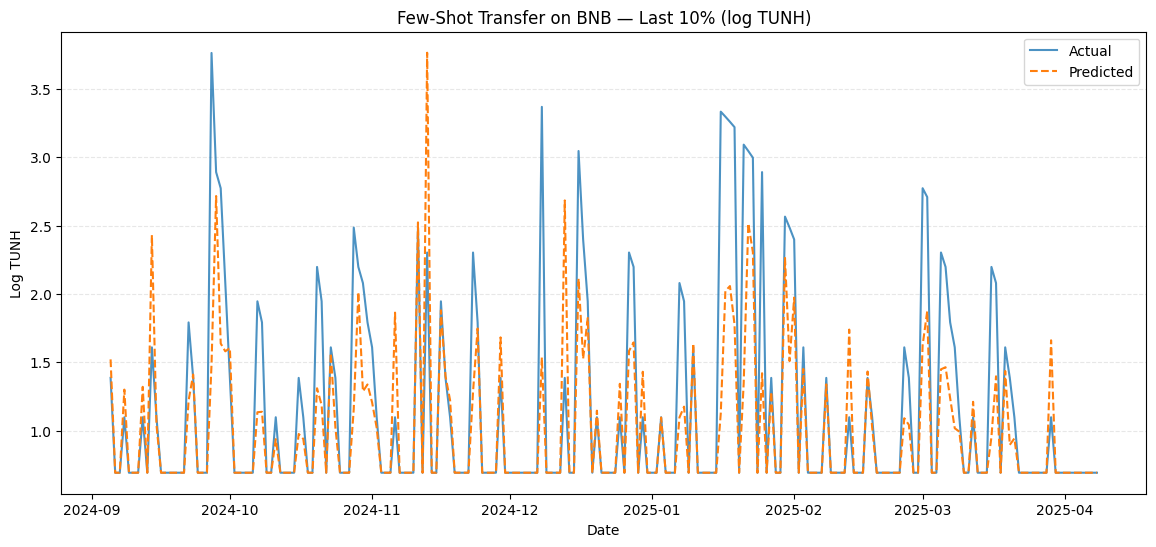

In [126]:
n_last = int(len(df_results) * 0.10)
df_last = df_results.tail(n_last)

plot_log_results(
    df_last,
    "Few-Shot Transfer on BNB — Last 10% (log TUNH)",
    "Log TUNH",
    'Plots/9. cross generalization/3a. btc_bnb_log.png'
)

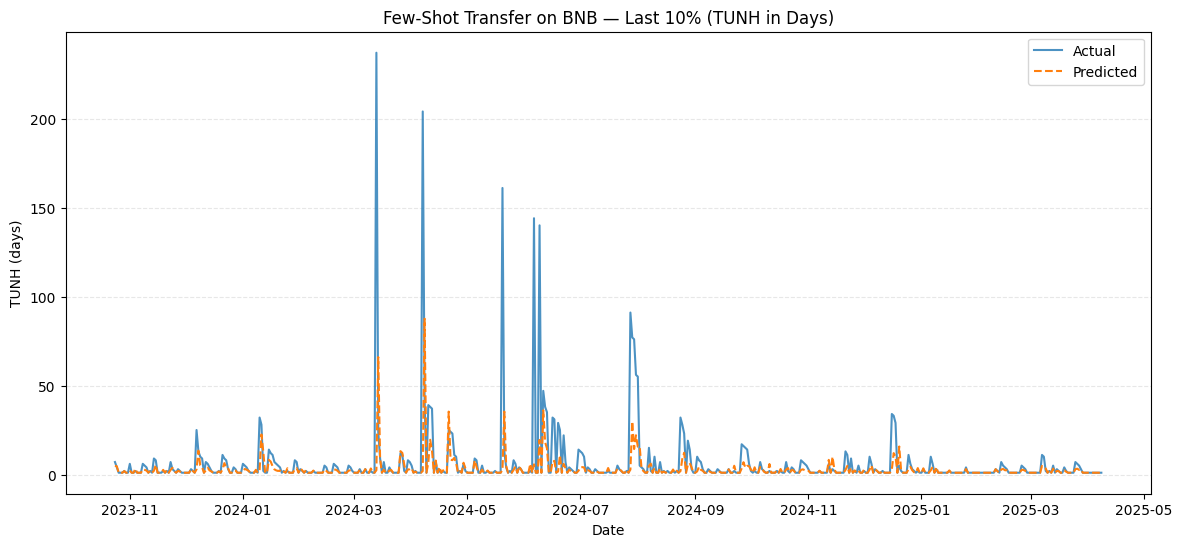

In [127]:
plot_results(
    df_test_days_btc,
    "Few-Shot Transfer on BNB — Last 10% (TUNH in Days)",
    "TUNH (days)",
    'Plots/9. cross generalization/3b. btc_bnb.png'
)

## <span style='color:darkgreen'>**4) BTC VS AAVE**</span>

### <span style='color:brown'>**Stage A:** Preprocessing</span>

In [128]:
df_aave = pd.read_csv("data/final_data_aave.csv")
df_aave['coin'] = 'AAVE'
df_aave = df_aave.rename(columns={"Date":"date"})
df_aave["date"] = pd.to_datetime(df_aave["date"])
df_aave['Date'] = df_aave['date'].dt.date
df_aave['date'] = df_aave['date'].dt.date
df_aave = df_aave.set_index('Date')
print(df_aave.head())

                  date       Open       High        Low      Close  Volume  tunh  coin
Date                                                                                  
2020-10-02  2020-10-02   0.000000   0.516571   0.000000   0.516571       0   1.0  AAVE
2020-10-03  2020-10-03   0.523836  65.305939   0.523801  53.151489       0  38.0  AAVE
2020-10-04  2020-10-04  53.179859  55.070354  50.688992  52.675034       0   1.0  AAVE
2020-10-05  2020-10-05  52.675034  55.112358  49.787899  53.219242       0   8.0  AAVE
2020-10-06  2020-10-06  53.291969  53.402271  40.734577  42.401600  583091   6.0  AAVE


In [129]:
df_aave['tunh'] = df_aave['tunh'].ffill().bfill()

upper_limit = df_aave['tunh'].quantile(0.99)
df_aave['tunh_outlier'] = df_aave['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_aave['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_aave):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

df_aave = df_aave[~df_aave['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_aave.shape}")
df_aave.drop(columns=['tunh_outlier'], inplace=True)

df_aave['tunh_log'] = np.log1p(df_aave['tunh'])

df_aave = df_aave.drop(['tunh'], axis=1)

Detected 17 outliers (1.03%) above the 99th percentile (929.50 days).
Final data shape after outlier removal: (1634, 9)


In [130]:
df_aave_rolled = roll_time_series(df_aave, column_id="coin", column_sort="date",
                            max_timeshift=20, min_timeshift=5)

X_aave = extract_features(df_aave_rolled.drop("coin", axis=1), 
                    column_id="id", column_sort="date", column_value="tunh_log", 
                    impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


In [131]:
X_aave = X_aave.set_index(X_aave.index.map(lambda x: x[1]), drop=True)
X_aave.index.name = "last_date"

y_aave = df_aave.set_index("date").sort_index().tunh_log.shift(-1)

y_aave = y_aave.dropna()

y_aave = y_aave[y_aave.index.isin(X_aave.index)]
X_aave = X_aave[X_aave.index.isin(y_aave.index)]

### <span style='color:brown'>**Stage B:** Modelling</span>

#### **Step 1:** Split the data

In [132]:
# BTC → 80% train / 10% wf
split_idx = int(len(X_btc) * 0.80)
wf_end    = int(len(X_btc) * 0.90)

X_btc_tr = X_btc.iloc[:split_idx]
X_btc_wf = X_btc.iloc[split_idx:wf_end]

# AAVE → first 10% few-shot, remaining 90% test
n_pax      = len(X_aave)
few_end    = int(n_pax * 0.10)
X_aave_few = X_aave.iloc[:few_end]
X_aave_te  = X_aave.iloc[few_end:]

# scale on BTC-train
scaler = StandardScaler().fit(X_btc_tr)
def scale(df): return pd.DataFrame(scaler.transform(df), index=df.index, columns=X_btc.columns)

X_tr  = scale(X_btc_tr)
X_wf  = scale(X_btc_wf)
X_few = scale(X_aave_few)
X_te  = scale(X_aave_te)

# align targets
y_tr  = y_btc.reindex(X_tr.index).dropna();  X_tr  = X_tr.loc[y_tr.index]
y_wf  = y_btc.reindex(X_wf.index).dropna();  X_wf  = X_wf.loc[y_wf.index]
y_few = y_aave.reindex(X_few.index).dropna();X_few = X_few.loc[y_few.index]
y_te  = y_aave.reindex(X_te.index).dropna(); X_te  = X_te.loc[y_te.index]

#### **Step 2:** Feature Selection

In [133]:
# 1) feature-select on BTC-train only
sel       = select_features(X_tr, y_tr).columns
X_tr_sel  = X_tr[sel]
X_wf_sel  = X_wf[sel]
X_few_sel = X_few[sel]
X_te_sel  = X_te[sel]

# 2) regime flags
reg_tr  = (y_tr.diff().shift(-1)  < 0).astype(int)
reg_wf  = (y_wf.diff().shift(-1)  < 0).astype(int)
reg_few = (y_few.diff().shift(-1) < 0).astype(int)
reg_te  = (y_te.diff().shift(-1)  < 0).astype(int)

# 3) expand interactions
X_tr_int  = expand_with_regime_interactions(X_tr_sel,  reg_tr)
X_wf_int  = expand_with_regime_interactions(X_wf_sel,  reg_wf)
X_few_int = expand_with_regime_interactions(X_few_sel, reg_few)
X_te_int  = expand_with_regime_interactions(X_te_sel,  reg_te)

#### **Step 3:** Pre-train on BTC

In [134]:
# pre-train
mlp.fit(
    X_tr_int.values, y_tr.values,
    validation_data=(X_wf_int.values, y_wf.values),
    epochs=100,
    batch_size=64,
    verbose=2
)

Epoch 1/100
67/67 - 1s - 10ms/step - loss: 0.1546 - val_loss: 0.4027
Epoch 2/100
67/67 - 0s - 4ms/step - loss: 0.1454 - val_loss: 0.4030
Epoch 3/100
67/67 - 0s - 4ms/step - loss: 0.1456 - val_loss: 0.4086
Epoch 4/100
67/67 - 0s - 5ms/step - loss: 0.1434 - val_loss: 0.4071
Epoch 5/100
67/67 - 0s - 4ms/step - loss: 0.1484 - val_loss: 0.4097
Epoch 6/100
67/67 - 0s - 4ms/step - loss: 0.1443 - val_loss: 0.4018
Epoch 7/100
67/67 - 0s - 4ms/step - loss: 0.1536 - val_loss: 0.4036
Epoch 8/100
67/67 - 0s - 7ms/step - loss: 0.1430 - val_loss: 0.4025
Epoch 9/100
67/67 - 0s - 5ms/step - loss: 0.1430 - val_loss: 0.4071
Epoch 10/100
67/67 - 0s - 4ms/step - loss: 0.1456 - val_loss: 0.4004
Epoch 11/100
67/67 - 0s - 4ms/step - loss: 0.1453 - val_loss: 0.4017
Epoch 12/100
67/67 - 0s - 5ms/step - loss: 0.1505 - val_loss: 0.4102
Epoch 13/100
67/67 - 0s - 4ms/step - loss: 0.1467 - val_loss: 0.4067
Epoch 14/100
67/67 - 0s - 5ms/step - loss: 0.1447 - val_loss: 0.3975
Epoch 15/100
67/67 - 0s - 4ms/step - loss:

#### **Step 4:** Fine-tune on AAVE

In [135]:
n = len(X_te_int)
n_ft = max(10, int(n*0.1))   # at least 10 samples
X_ft = X_te_int.iloc[:n_ft]
y_ft = y_te.iloc[:n_ft]
X_final = X_te_int.iloc[n_ft:]
y_final = y_te.iloc[n_ft:]

In [136]:
# lower learning-rate for fine-tuning
mlp.compile(optimizer=Adam(1e-4),
            loss="mean_absolute_error")

mlp.fit(
    X_ft.values, y_ft.values,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
    verbose=2
)

Epoch 1/50
8/8 - 1s - 95ms/step - loss: 0.2753 - val_loss: 0.1379
Epoch 2/50
8/8 - 0s - 16ms/step - loss: 0.3328 - val_loss: 0.1408
Epoch 3/50
8/8 - 0s - 10ms/step - loss: 0.2943 - val_loss: 0.1400
Epoch 4/50
8/8 - 0s - 14ms/step - loss: 0.3142 - val_loss: 0.1385
Epoch 5/50
8/8 - 0s - 9ms/step - loss: 0.2466 - val_loss: 0.1349
Epoch 6/50
8/8 - 0s - 11ms/step - loss: 0.2583 - val_loss: 0.1323
Epoch 7/50
8/8 - 0s - 11ms/step - loss: 0.2390 - val_loss: 0.1307
Epoch 8/50
8/8 - 0s - 25ms/step - loss: 0.2484 - val_loss: 0.1304
Epoch 9/50
8/8 - 0s - 8ms/step - loss: 0.2578 - val_loss: 0.1337
Epoch 10/50
8/8 - 0s - 10ms/step - loss: 0.2382 - val_loss: 0.1327
Epoch 11/50
8/8 - 0s - 9ms/step - loss: 0.2524 - val_loss: 0.1323
Epoch 12/50
8/8 - 0s - 8ms/step - loss: 0.2203 - val_loss: 0.1328
Epoch 13/50
8/8 - 0s - 8ms/step - loss: 0.2479 - val_loss: 0.1342
Epoch 14/50
8/8 - 0s - 8ms/step - loss: 0.2226 - val_loss: 0.1356
Epoch 15/50
8/8 - 0s - 8ms/step - loss: 0.2188 - val_loss: 0.1383
Epoch 16/50

#### **Step 5:** Evaluate on AAVE

In [137]:
y_pred = mlp.predict(X_final.values).flatten()
MAE, RMSE, MAPE, DA = calculate_metrics(y_final.values, y_pred)
print(" Few-Shot AAVE Final Test Metrics:")
print(f" MAE={MAE:.5f}, RMSE={RMSE:.5f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 Few-Shot AAVE Final Test Metrics:
 MAE=0.38256, RMSE=0.77035, MAPE=16.81%, DA=88.02%


In [138]:
df_results = pd.DataFrame({
    "Actual":    y_final.values,
    "Predicted": y_pred
}, index=y_final.index)

# Also add back “days” scale if you like
df_results["Actual_days"]    = np.expm1(df_results["Actual"])
df_results["Predicted_days"] = np.expm1(df_results["Predicted"])

print("\nTest Results (in days):")
print(df_results.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2021-08-11  0.693147   0.693104          1.0        0.999913
2021-08-12  1.386294   2.303496          3.0        9.009114
2021-08-13  1.098612   1.028618          2.0        1.797198
2021-08-14  0.693147   0.693104          1.0        0.999913
2021-08-15  0.693147   0.693104          1.0        0.999913


#### **Step 6:** Plot

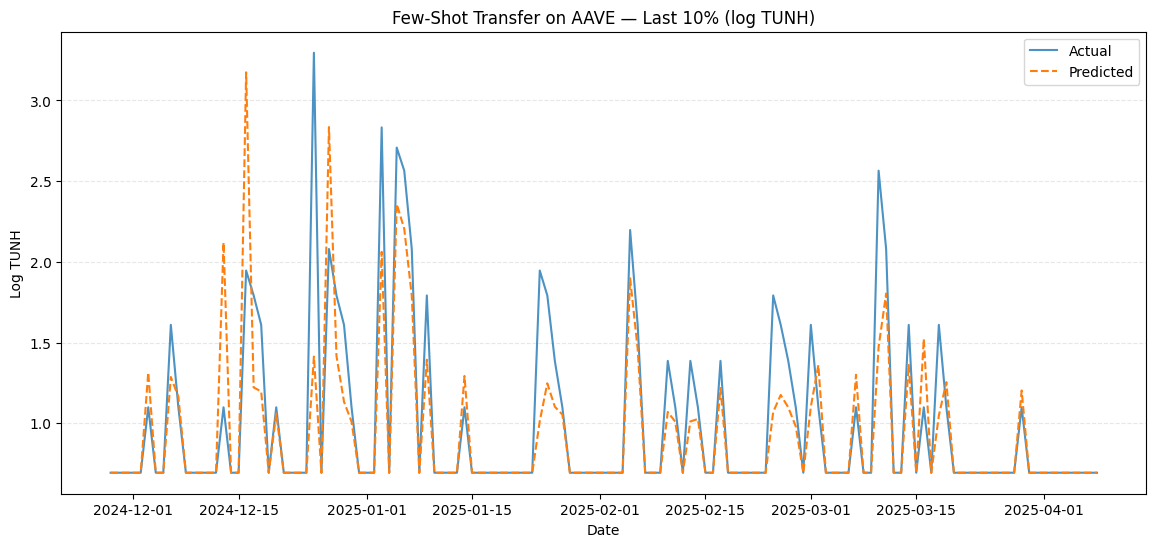

In [139]:
n_last = int(len(df_results) * 0.10)
df_last = df_results.tail(n_last)

plot_log_results(
    df_last,
    "Few-Shot Transfer on AAVE — Last 10% (log TUNH)",
    "Log TUNH",
    'Plots/9. cross generalization/4a. btc_aave_log.png'
)

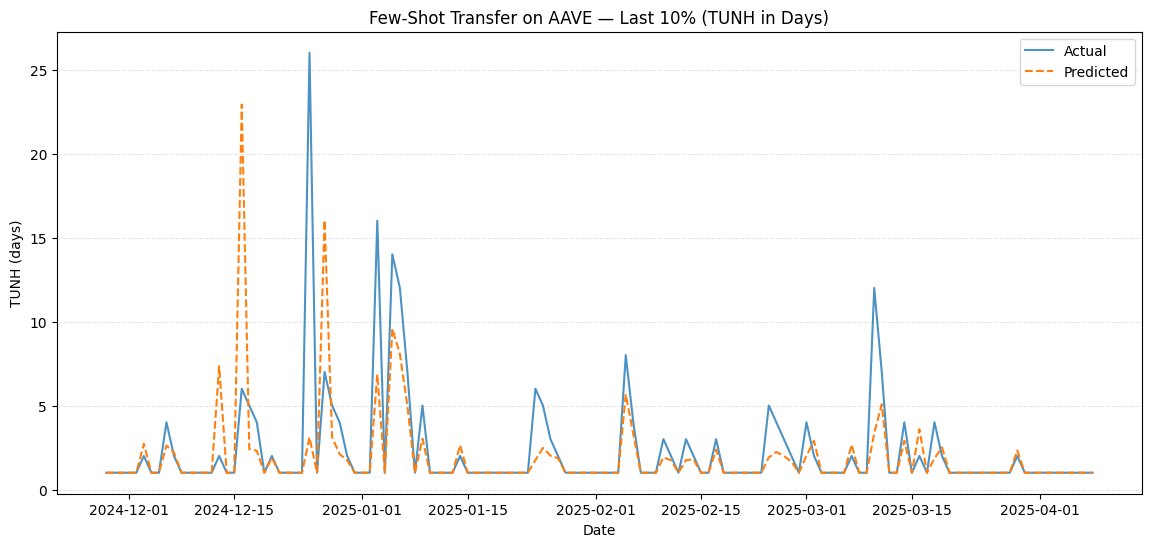

In [140]:
plot_results(
    df_last,
    "Few-Shot Transfer on AAVE — Last 10% (TUNH in Days)",
    "TUNH (days)",
    'Plots/9. cross generalization/4b. btc_aave.png'
)

## <span style='color:darkgreen'>**5) BTC VS SOL**</span>

### <span style='color:brown'>**Stage A:** Preprocessing</span>

In [141]:
df_sol = pd.read_csv("data/final_data_SOL.csv")
df_sol['coin'] = 'SOL'
df_sol = df_sol.rename(columns={"Date":"date"})
df_sol["date"] = pd.to_datetime(df_sol["date"])
df_sol['Date'] = df_sol['date'].dt.date
df_sol['date'] = df_sol['date'].dt.date
df_sol = df_sol.set_index('Date')
print(df_sol.head())

                  date      Open      High       Low     Close    Volume  tunh coin
Date                                                                               
2020-04-10  2020-04-10  0.832005  1.313487  0.694187  0.951054  87364276  96.0  SOL
2020-04-11  2020-04-11  0.951054  1.049073  0.765020  0.776819  43862444  92.0  SOL
2020-04-12  2020-04-12  0.785448  0.956670  0.762426  0.882507  38736897  79.0  SOL
2020-04-13  2020-04-13  0.890760  0.891603  0.773976  0.777832  18211285  78.0  SOL
2020-04-14  2020-04-14  0.777832  0.796472  0.628169  0.661925  16747614  16.0  SOL


In [142]:
df_sol['tunh'] = df_sol['tunh'].ffill().bfill()

upper_limit = df_sol['tunh'].quantile(0.99)
df_sol['tunh_outlier'] = df_sol['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_sol['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_sol):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

df_sol = df_sol[~df_sol['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_sol.shape}")
df_sol.drop(columns=['tunh_outlier'], inplace=True)

df_sol['tunh_log'] = np.log1p(df_sol['tunh'])

df_sol = df_sol.drop(['tunh'], axis=1)

Detected 19 outliers (1.04%) above the 99th percentile (788.00 days).
Final data shape after outlier removal: (1807, 9)


In [143]:
df_sol_rolled = roll_time_series(df_sol, column_id="coin", column_sort="date",
                            max_timeshift=20, min_timeshift=5)

X_sol = extract_features(df_sol_rolled.drop("coin", axis=1), 
                    column_id="id", column_sort="date", column_value="tunh_log", 
                    impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


In [144]:
X_sol = X_sol.set_index(X_sol.index.map(lambda x: x[1]), drop=True)
X_sol.index.name = "last_date"

y_sol = df_sol.set_index("date").sort_index().tunh_log.shift(-1)

y_sol = y_sol.dropna()

y_sol = y_sol[y_sol.index.isin(X_sol.index)]
X_sol = X_sol[X_sol.index.isin(y_sol.index)]

### <span style='color:brown'>**Stage B:** Modelling</span>

#### **Step 1:** Split the data

In [145]:
# BTC → 80% train / 10% wf
split_idx = int(len(X_btc) * 0.80)
wf_end    = int(len(X_btc) * 0.90)

X_btc_tr = X_btc.iloc[:split_idx]
X_btc_wf = X_btc.iloc[split_idx:wf_end]

# SOL → first 10% few-shot, remaining 90% test
n_pax      = len(X_sol)
few_end    = int(n_pax * 0.10)
X_sol_few = X_sol.iloc[:few_end]
X_sol_te  = X_sol.iloc[few_end:]

# scale on BTC-train
scaler = StandardScaler().fit(X_btc_tr)
def scale(df): return pd.DataFrame(scaler.transform(df), index=df.index, columns=X_btc.columns)

X_tr  = scale(X_btc_tr)
X_wf  = scale(X_btc_wf)
X_few = scale(X_sol_few)
X_te  = scale(X_sol_te)

# align targets
y_tr  = y_btc.reindex(X_tr.index).dropna();  X_tr  = X_tr.loc[y_tr.index]
y_wf  = y_btc.reindex(X_wf.index).dropna();  X_wf  = X_wf.loc[y_wf.index]
y_few = y_sol.reindex(X_few.index).dropna();X_few = X_few.loc[y_few.index]
y_te  = y_sol.reindex(X_te.index).dropna(); X_te  = X_te.loc[y_te.index]

#### **Step 2:** Feature Selection

In [146]:
# 1) feature-select on BTC-train only
sel       = select_features(X_tr, y_tr).columns
X_tr_sel  = X_tr[sel]
X_wf_sel  = X_wf[sel]
X_few_sel = X_few[sel]
X_te_sel  = X_te[sel]

# 2) regime flags
reg_tr  = (y_tr.diff().shift(-1)  < 0).astype(int)
reg_wf  = (y_wf.diff().shift(-1)  < 0).astype(int)
reg_few = (y_few.diff().shift(-1) < 0).astype(int)
reg_te  = (y_te.diff().shift(-1)  < 0).astype(int)

# 3) expand interactions
X_tr_int  = expand_with_regime_interactions(X_tr_sel,  reg_tr)
X_wf_int  = expand_with_regime_interactions(X_wf_sel,  reg_wf)
X_few_int = expand_with_regime_interactions(X_few_sel, reg_few)
X_te_int  = expand_with_regime_interactions(X_te_sel,  reg_te)

#### **Step 3:** Pre-train on BTC

In [147]:
# pre-train
mlp.fit(
    X_tr_int.values, y_tr.values,
    validation_data=(X_wf_int.values, y_wf.values),
    epochs=100,
    batch_size=64,
    verbose=2
)

Epoch 1/100
67/67 - 0s - 5ms/step - loss: 0.1496 - val_loss: 0.4128
Epoch 2/100
67/67 - 0s - 5ms/step - loss: 0.1433 - val_loss: 0.4019
Epoch 3/100
67/67 - 0s - 4ms/step - loss: 0.1435 - val_loss: 0.4156
Epoch 4/100
67/67 - 0s - 4ms/step - loss: 0.1387 - val_loss: 0.4148
Epoch 5/100
67/67 - 0s - 4ms/step - loss: 0.1400 - val_loss: 0.4048
Epoch 6/100
67/67 - 0s - 4ms/step - loss: 0.1487 - val_loss: 0.4085
Epoch 7/100
67/67 - 0s - 6ms/step - loss: 0.1439 - val_loss: 0.3963
Epoch 8/100
67/67 - 0s - 4ms/step - loss: 0.1412 - val_loss: 0.4055
Epoch 9/100
67/67 - 0s - 4ms/step - loss: 0.1382 - val_loss: 0.4101
Epoch 10/100
67/67 - 0s - 5ms/step - loss: 0.1398 - val_loss: 0.4008
Epoch 11/100
67/67 - 0s - 4ms/step - loss: 0.1383 - val_loss: 0.4121
Epoch 12/100
67/67 - 0s - 4ms/step - loss: 0.1422 - val_loss: 0.4019
Epoch 13/100
67/67 - 0s - 4ms/step - loss: 0.1430 - val_loss: 0.4094
Epoch 14/100
67/67 - 0s - 5ms/step - loss: 0.1387 - val_loss: 0.4079
Epoch 15/100
67/67 - 0s - 5ms/step - loss: 

#### **Step 4:** Fine-tune on SOL

In [148]:
n = len(X_te_int)
n_ft = max(10, int(n*0.1))   # at least 10 samples
X_ft = X_te_int.iloc[:n_ft]
y_ft = y_te.iloc[:n_ft]
X_final = X_te_int.iloc[n_ft:]
y_final = y_te.iloc[n_ft:]

In [149]:
# lower learning-rate for fine-tuning
mlp.compile(optimizer=Adam(1e-4),
            loss="mean_absolute_error")

mlp.fit(
    X_ft.values, y_ft.values,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
    verbose=2
)

Epoch 1/50
9/9 - 1s - 120ms/step - loss: 0.3357 - val_loss: 0.3269
Epoch 2/50
9/9 - 0s - 8ms/step - loss: 0.3059 - val_loss: 0.3191
Epoch 3/50
9/9 - 0s - 7ms/step - loss: 0.2996 - val_loss: 0.3159
Epoch 4/50
9/9 - 0s - 7ms/step - loss: 0.2822 - val_loss: 0.3178
Epoch 5/50
9/9 - 0s - 12ms/step - loss: 0.2755 - val_loss: 0.3170
Epoch 6/50
9/9 - 0s - 7ms/step - loss: 0.2454 - val_loss: 0.3118
Epoch 7/50
9/9 - 0s - 7ms/step - loss: 0.2480 - val_loss: 0.3139
Epoch 8/50
9/9 - 0s - 7ms/step - loss: 0.2229 - val_loss: 0.3185
Epoch 9/50
9/9 - 0s - 7ms/step - loss: 0.2357 - val_loss: 0.3192
Epoch 10/50
9/9 - 0s - 7ms/step - loss: 0.2581 - val_loss: 0.3220
Epoch 11/50
9/9 - 0s - 8ms/step - loss: 0.2270 - val_loss: 0.3225
Epoch 12/50
9/9 - 0s - 7ms/step - loss: 0.2305 - val_loss: 0.3180
Epoch 13/50
9/9 - 0s - 7ms/step - loss: 0.2227 - val_loss: 0.3191
Epoch 14/50
9/9 - 0s - 7ms/step - loss: 0.2358 - val_loss: 0.3301
Epoch 15/50
9/9 - 0s - 7ms/step - loss: 0.2193 - val_loss: 0.3325
Epoch 16/50
9/9 

#### **Step 5:** Evaluate on SOL

In [150]:
y_pred = mlp.predict(X_final.values).flatten()
MAE, RMSE, MAPE, DA = calculate_metrics(y_final.values, y_pred)
print(" Few-Shot SOL Final Test Metrics:")
print(f" MAE={MAE:.5f}, RMSE={RMSE:.5f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
 Few-Shot SOL Final Test Metrics:
 MAE=0.43016, RMSE=0.86567, MAPE=16.54%, DA=88.75%


In [151]:
df_results = pd.DataFrame({
    "Actual":    y_final.values,
    "Predicted": y_pred
}, index=y_final.index)

# Also add back “days” scale if you like
df_results["Actual_days"]    = np.expm1(df_results["Actual"])
df_results["Predicted_days"] = np.expm1(df_results["Predicted"])

print("\nTest Results (in days):")
print(df_results.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2021-03-23  1.386294   0.987662          3.0        1.684948
2021-03-24  0.693147   0.693098          1.0        0.999901
2021-03-25  0.693147   0.693098          1.0        0.999901
2021-03-26  0.693147   0.693098          1.0        0.999901
2021-03-27  1.098612   2.183187          2.0        7.874547


#### **Step 6:** Plot

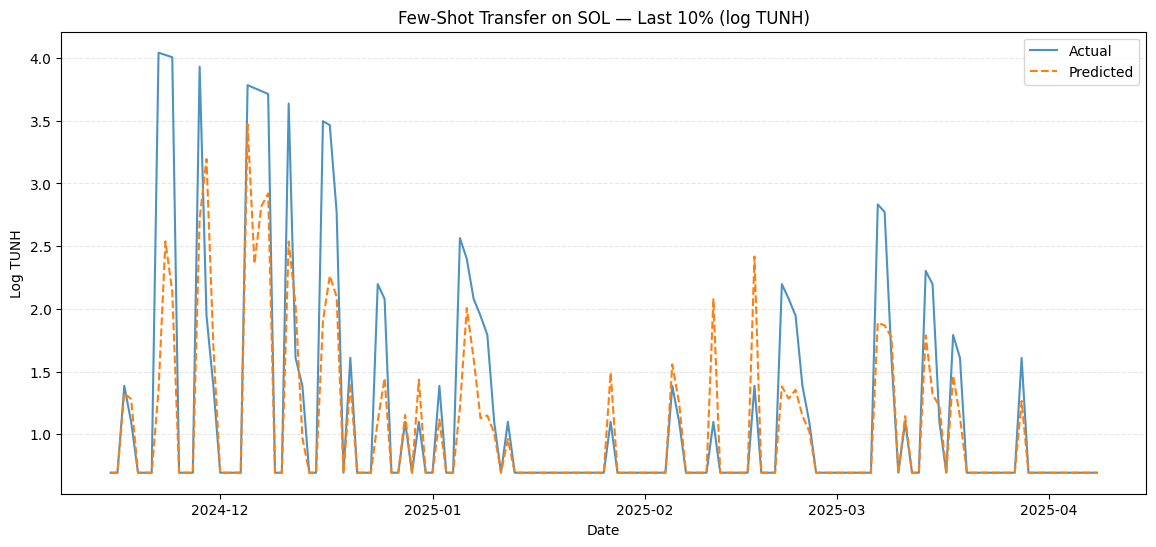

In [152]:
n_last = int(len(df_results) * 0.10)
df_last = df_results.tail(n_last)

plot_log_results(
    df_last,
    "Few-Shot Transfer on SOL — Last 10% (log TUNH)",
    "Log TUNH",
    'Plots/9. cross generalization/5a. btc_sol_log.png'
)

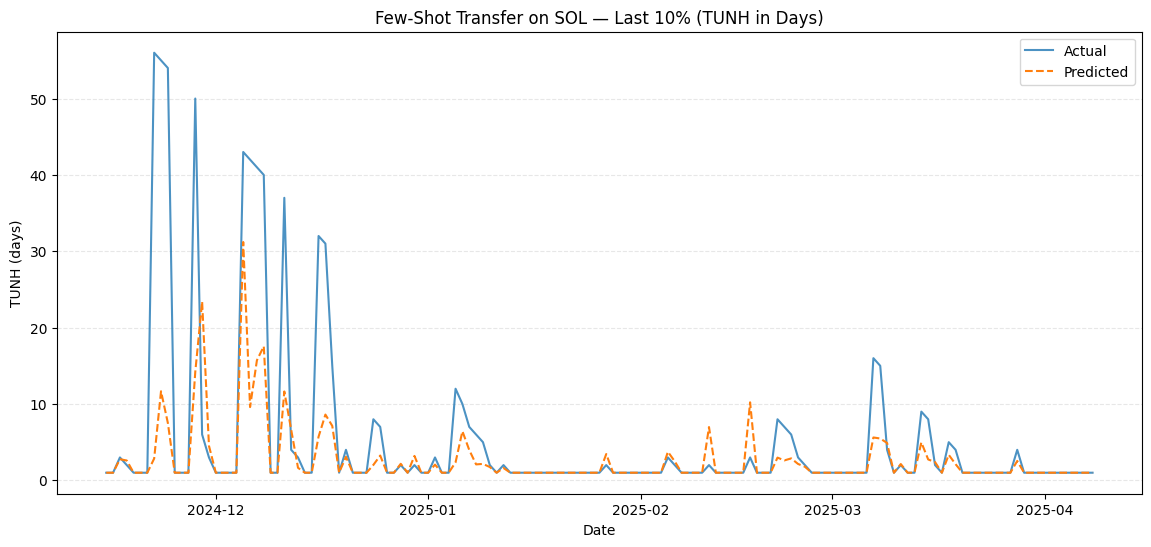

In [153]:
plot_results(
    df_last,
    "Few-Shot Transfer on SOL — Last 10% (TUNH in Days)",
    "TUNH (days)",
    'Plots/9. cross generalization/5b. btc_sol.png'
)

## <span style='color:darkgreen'>**6) BTC VS LTC**</span>

### <span style='color:brown'>**Stage A:** Preprocessing</span>

In [154]:
df_ltc = pd.read_csv("data/final_data_ltc.csv")
df_ltc['coin'] = 'LTC'
df_ltc = df_ltc.rename(columns={"Date":"date"})
df_ltc["date"] = pd.to_datetime(df_ltc["date"])
df_ltc['Date'] = df_ltc['date'].dt.date
df_ltc['date'] = df_ltc['date'].dt.date
df_ltc = df_ltc.set_index('Date')
print(df_ltc.head())

                  date     Open     High      Low    Close   Volume   tunh coin
Date                                                                           
2014-09-17  2014-09-17  5.08589  5.17077  4.96595  5.05855  3071840  292.0  LTC
2014-09-18  2014-09-18  5.06543  5.06543  4.57996  4.68523  4569260  291.0  LTC
2014-09-19  2014-09-19  4.68729  4.75582  4.25435  4.32777  3917450    4.0  LTC
2014-09-20  2014-09-20  4.32920  4.61608  4.20219  4.28644  5490660    3.0  LTC
2014-09-21  2014-09-21  4.26307  4.30013  4.15499  4.24592  2931220    1.0  LTC


In [155]:
df_ltc['tunh'] = df_ltc['tunh'].ffill().bfill()

upper_limit = df_ltc['tunh'].quantile(0.99)
df_ltc['tunh_outlier'] = df_ltc['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_ltc['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_ltc):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

df_ltc = df_ltc[~df_ltc['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_ltc.shape}")
df_ltc.drop(columns=['tunh_outlier'], inplace=True)

df_ltc['tunh_log'] = np.log1p(df_ltc['tunh'])

df_ltc = df_ltc.drop(['tunh'], axis=1)

Detected 39 outliers (1.01%) above the 99th percentile (556.86 days).
Final data shape after outlier removal: (3819, 9)


In [156]:
df_ltc_rolled = roll_time_series(df_ltc, column_id="coin", column_sort="date",
                            max_timeshift=20, min_timeshift=5)

X_ltc = extract_features(df_ltc_rolled.drop("coin", axis=1), 
                    column_id="id", column_sort="date", column_value="tunh_log", 
                    impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


In [157]:
X_ltc = X_ltc.set_index(X_ltc.index.map(lambda x: x[1]), drop=True)
X_ltc.index.name = "last_date"

y_ltc = df_ltc.set_index("date").sort_index().tunh_log.shift(-1)

y_ltc = y_ltc.dropna()

y_ltc = y_ltc[y_ltc.index.isin(X_ltc.index)]
X_ltc = X_ltc[X_ltc.index.isin(y_ltc.index)]

### <span style='color:brown'>**Stage B:** Modelling</span>

#### **Step 1:** Split the data

In [158]:
# BTC → 80% train / 10% wf
split_idx = int(len(X_btc) * 0.80)
wf_end    = int(len(X_btc) * 0.90)

X_btc_tr = X_btc.iloc[:split_idx]
X_btc_wf = X_btc.iloc[split_idx:wf_end]

# LTC → first 10% few-shot, remaining 90% test
n_pax      = len(X_ltc)
few_end    = int(n_pax * 0.10)
X_ltc_few = X_ltc.iloc[:few_end]
X_ltc_te  = X_ltc.iloc[few_end:]

# scale on BTC-train
scaler = StandardScaler().fit(X_btc_tr)
def scale(df): return pd.DataFrame(scaler.transform(df), index=df.index, columns=X_btc.columns)

X_tr  = scale(X_btc_tr)
X_wf  = scale(X_btc_wf)
X_few = scale(X_ltc_few)
X_te  = scale(X_ltc_te)

# align targets
y_tr  = y_btc.reindex(X_tr.index).dropna();  X_tr  = X_tr.loc[y_tr.index]
y_wf  = y_btc.reindex(X_wf.index).dropna();  X_wf  = X_wf.loc[y_wf.index]
y_few = y_ltc.reindex(X_few.index).dropna();X_few = X_few.loc[y_few.index]
y_te  = y_ltc.reindex(X_te.index).dropna(); X_te  = X_te.loc[y_te.index]

#### **Step 2:** Feature Selection

In [159]:
# 1) feature-select on BTC-train only
sel       = select_features(X_tr, y_tr).columns
X_tr_sel  = X_tr[sel]
X_wf_sel  = X_wf[sel]
X_few_sel = X_few[sel]
X_te_sel  = X_te[sel]

# 2) regime flags
reg_tr  = (y_tr.diff().shift(-1)  < 0).astype(int)
reg_wf  = (y_wf.diff().shift(-1)  < 0).astype(int)
reg_few = (y_few.diff().shift(-1) < 0).astype(int)
reg_te  = (y_te.diff().shift(-1)  < 0).astype(int)

# 3) expand interactions
X_tr_int  = expand_with_regime_interactions(X_tr_sel,  reg_tr)
X_wf_int  = expand_with_regime_interactions(X_wf_sel,  reg_wf)
X_few_int = expand_with_regime_interactions(X_few_sel, reg_few)
X_te_int  = expand_with_regime_interactions(X_te_sel,  reg_te)

#### **Step 3:** Pre-train on BTC

In [160]:
# pre-train
mlp.fit(
    X_tr_int.values, y_tr.values,
    validation_data=(X_wf_int.values, y_wf.values),
    epochs=100,
    batch_size=64,
    verbose=2
)

Epoch 1/100
67/67 - 0s - 5ms/step - loss: 0.1490 - val_loss: 0.4020
Epoch 2/100
67/67 - 0s - 5ms/step - loss: 0.1457 - val_loss: 0.4037
Epoch 3/100
67/67 - 0s - 5ms/step - loss: 0.1387 - val_loss: 0.4024
Epoch 4/100
67/67 - 0s - 4ms/step - loss: 0.1354 - val_loss: 0.4016
Epoch 5/100
67/67 - 0s - 5ms/step - loss: 0.1388 - val_loss: 0.3998
Epoch 6/100
67/67 - 0s - 5ms/step - loss: 0.1360 - val_loss: 0.4053
Epoch 7/100
67/67 - 0s - 4ms/step - loss: 0.1365 - val_loss: 0.4002
Epoch 8/100
67/67 - 0s - 4ms/step - loss: 0.1399 - val_loss: 0.4093
Epoch 9/100
67/67 - 0s - 4ms/step - loss: 0.1410 - val_loss: 0.4064
Epoch 10/100
67/67 - 0s - 4ms/step - loss: 0.1375 - val_loss: 0.4112
Epoch 11/100
67/67 - 0s - 4ms/step - loss: 0.1345 - val_loss: 0.4059
Epoch 12/100
67/67 - 0s - 4ms/step - loss: 0.1369 - val_loss: 0.4046
Epoch 13/100
67/67 - 0s - 4ms/step - loss: 0.1376 - val_loss: 0.4068
Epoch 14/100
67/67 - 0s - 5ms/step - loss: 0.1395 - val_loss: 0.3993
Epoch 15/100
67/67 - 0s - 4ms/step - loss: 

#### **Step 4:** Fine-tune on LTC

In [161]:
n = len(X_te_int)
n_ft = max(10, int(n*0.1))   # at least 10 samples
X_ft = X_te_int.iloc[:n_ft]
y_ft = y_te.iloc[:n_ft]
X_final = X_te_int.iloc[n_ft:]
y_final = y_te.iloc[n_ft:]

In [162]:
# lower learning-rate for fine-tuning
mlp.compile(optimizer=Adam(1e-4),
            loss="mean_absolute_error")

mlp.fit(
    X_ft.values, y_ft.values,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
    verbose=2
)

Epoch 1/50
18/18 - 1s - 40ms/step - loss: 0.3788 - val_loss: 0.5104
Epoch 2/50
18/18 - 0s - 6ms/step - loss: 0.3814 - val_loss: 0.5338
Epoch 3/50
18/18 - 0s - 5ms/step - loss: 0.3900 - val_loss: 0.5332
Epoch 4/50
18/18 - 0s - 10ms/step - loss: 0.3728 - val_loss: 0.5322
Epoch 5/50
18/18 - 0s - 5ms/step - loss: 0.3487 - val_loss: 0.5210
Epoch 6/50
18/18 - 0s - 5ms/step - loss: 0.3465 - val_loss: 0.5018
Epoch 7/50
18/18 - 0s - 5ms/step - loss: 0.3375 - val_loss: 0.5014
Epoch 8/50
18/18 - 0s - 6ms/step - loss: 0.3265 - val_loss: 0.5161
Epoch 9/50
18/18 - 0s - 6ms/step - loss: 0.3256 - val_loss: 0.5429
Epoch 10/50
18/18 - 0s - 5ms/step - loss: 0.3167 - val_loss: 0.5174
Epoch 11/50
18/18 - 0s - 5ms/step - loss: 0.3083 - val_loss: 0.5199
Epoch 12/50
18/18 - 0s - 5ms/step - loss: 0.3087 - val_loss: 0.5233
Epoch 13/50
18/18 - 0s - 5ms/step - loss: 0.3068 - val_loss: 0.5055
Epoch 14/50
18/18 - 0s - 5ms/step - loss: 0.2901 - val_loss: 0.5116
Epoch 15/50
18/18 - 0s - 5ms/step - loss: 0.3042 - val_

#### **Step 5:** Evaluate on LTC

In [163]:
y_pred = mlp.predict(X_final.values).flatten()
MAE, RMSE, MAPE, DA = calculate_metrics(y_final.values, y_pred)
print(" Few-Shot LTC Final Test Metrics:")
print(f" MAE={MAE:.5f}, RMSE={RMSE:.5f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
 Few-Shot LTC Final Test Metrics:
 MAE=0.38981, RMSE=0.77396, MAPE=16.55%, DA=88.31%


In [164]:
df_results = pd.DataFrame({
    "Actual":    y_final.values,
    "Predicted": y_pred
}, index=y_final.index)

# Also add back “days” scale if you like
df_results["Actual_days"]    = np.expm1(df_results["Actual"])
df_results["Predicted_days"] = np.expm1(df_results["Predicted"])

print("\nTest Results (in days):")
print(df_results.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2016-09-16  0.693147   0.693147          1.0        0.999999
2016-09-17  0.693147   0.693147          1.0        0.999999
2016-09-18  3.401197   1.038140         29.0        1.823960
2016-09-19  0.693147   0.693147          1.0        0.999999
2016-09-20  1.945910   2.049082          6.0        6.760776


#### **Step 6:** Plot

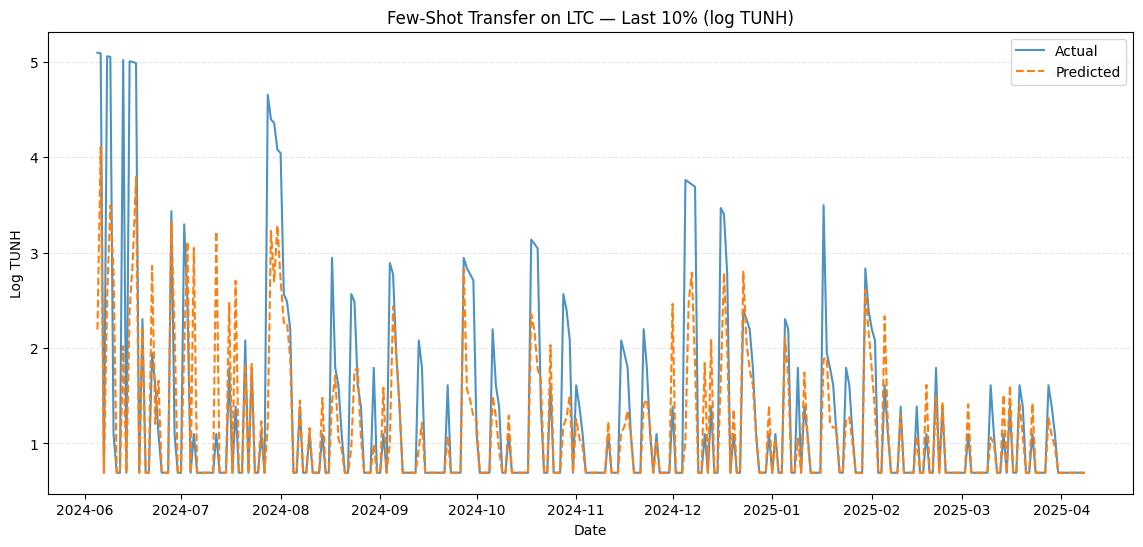

In [165]:
n_last = int(len(df_results) * 0.10)
df_last = df_results.tail(n_last)

plot_log_results(
    df_last,
    "Few-Shot Transfer on LTC — Last 10% (log TUNH)",
    "Log TUNH",
    'Plots/9. cross generalization/6a. btc_ltc_log.png'
)

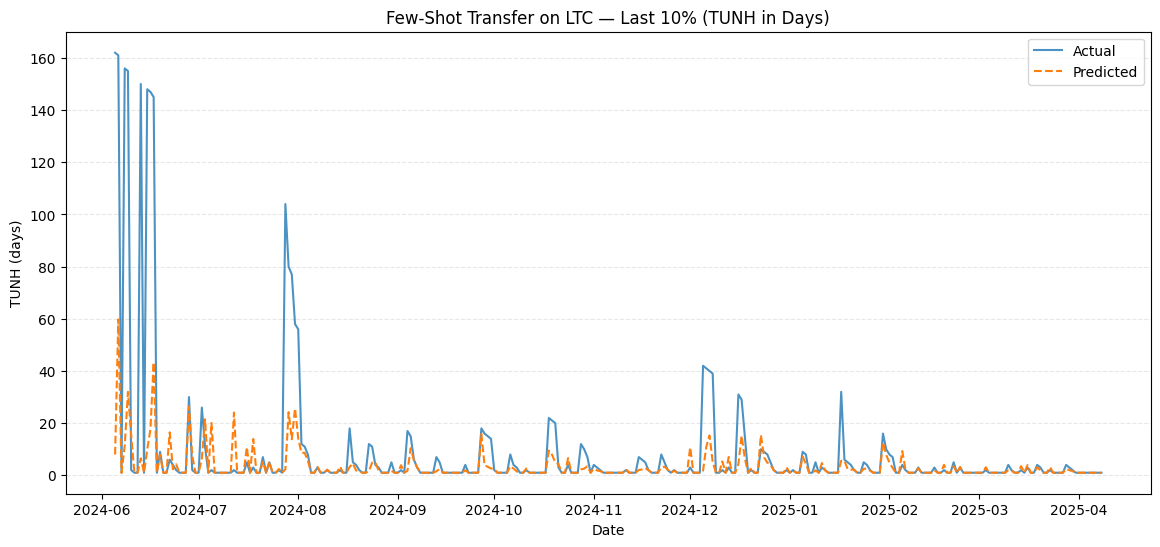

In [166]:
plot_results(
    df_last,
    "Few-Shot Transfer on LTC — Last 10% (TUNH in Days)",
    "TUNH (days)",
    'Plots/9. cross generalization/6b. btc_ltc.png'
)

## <span style='color:darkgreen'>**7) BTC VS XRP**</span>

### <span style='color:brown'>**Stage A:** Preprocessing</span>

In [167]:
df_xrp = pd.read_csv("data/final_data_XRP.csv")
df_xrp['coin'] = 'XRP'
df_xrp = df_xrp.rename(columns={"Date":"date"})
df_xrp["date"] = pd.to_datetime(df_xrp["date"])
df_xrp['Date'] = df_xrp['date'].dt.date
df_xrp['date'] = df_xrp['date'].dt.date
df_xrp = df_xrp.set_index('Date')
print(df_xrp.head())

                  date      Open      High       Low     Close     Volume  tunh coin
Date                                                                                
2017-11-09  2017-11-09  0.217911  0.221791  0.214866  0.217488  147916992   7.0  XRP
2017-11-10  2017-11-10  0.218256  0.219068  0.205260  0.206483  141032992   6.0  XRP
2017-11-11  2017-11-11  0.205948  0.214456  0.205459  0.210430  134503008   5.0  XRP
2017-11-12  2017-11-12  0.210214  0.210214  0.195389  0.197339  251175008   2.0  XRP
2017-11-13  2017-11-13  0.197472  0.204081  0.197456  0.203442  132567000   1.0  XRP


In [168]:
df_xrp['tunh'] = df_xrp['tunh'].ffill().bfill()

upper_limit = df_xrp['tunh'].quantile(0.99)
df_xrp['tunh_outlier'] = df_xrp['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_xrp['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_xrp):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

df_xrp = df_xrp[~df_xrp['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_xrp.shape}")
df_xrp.drop(columns=['tunh_outlier'], inplace=True)

df_xrp['tunh_log'] = np.log1p(df_xrp['tunh'])

df_xrp = df_xrp.drop(['tunh'], axis=1)

Detected 28 outliers (1.03%) above the 99th percentile (1127.92 days).
Final data shape after outlier removal: (2681, 9)


In [169]:
df_xrp_rolled = roll_time_series(df_xrp, column_id="coin", column_sort="date",
                            max_timeshift=20, min_timeshift=5)

X_xrp = extract_features(df_xrp_rolled.drop("coin", axis=1), 
                    column_id="id", column_sort="date", column_value="tunh_log", 
                    impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


In [170]:
X_xrp = X_xrp.set_index(X_xrp.index.map(lambda x: x[1]), drop=True)
X_xrp.index.name = "last_date"

y_xrp = df_xrp.set_index("date").sort_index().tunh_log.shift(-1)

y_xrp = y_xrp.dropna()

y_xrp = y_xrp[y_xrp.index.isin(X_xrp.index)]
X_xrp = X_xrp[X_xrp.index.isin(y_xrp.index)]

### <span style='color:brown'>**Stage B:** Modelling</span>

#### **Step 1:** Split the data

In [171]:
# BTC → 80% train / 10% wf
split_idx = int(len(X_btc) * 0.80)
wf_end    = int(len(X_btc) * 0.90)

X_btc_tr = X_btc.iloc[:split_idx]
X_btc_wf = X_btc.iloc[split_idx:wf_end]

# XRP → first 10% few-shot, remaining 90% test
n_pax      = len(X_xrp)
few_end    = int(n_pax * 0.10)
X_xrp_few = X_xrp.iloc[:few_end]
X_xrp_te  = X_xrp.iloc[few_end:]

# scale on BTC-train
scaler = StandardScaler().fit(X_btc_tr)
def scale(df): return pd.DataFrame(scaler.transform(df), index=df.index, columns=X_btc.columns)

X_tr  = scale(X_btc_tr)
X_wf  = scale(X_btc_wf)
X_few = scale(X_xrp_few)
X_te  = scale(X_xrp_te)

# align targets
y_tr  = y_btc.reindex(X_tr.index).dropna();  X_tr  = X_tr.loc[y_tr.index]
y_wf  = y_btc.reindex(X_wf.index).dropna();  X_wf  = X_wf.loc[y_wf.index]
y_few = y_xrp.reindex(X_few.index).dropna();X_few = X_few.loc[y_few.index]
y_te  = y_xrp.reindex(X_te.index).dropna(); X_te  = X_te.loc[y_te.index]

#### **Step 2:** Feature Selection

In [172]:
# 1) feature-select on BTC-train only
sel       = select_features(X_tr, y_tr).columns
X_tr_sel  = X_tr[sel]
X_wf_sel  = X_wf[sel]
X_few_sel = X_few[sel]
X_te_sel  = X_te[sel]

# 2) regime flags
reg_tr  = (y_tr.diff().shift(-1)  < 0).astype(int)
reg_wf  = (y_wf.diff().shift(-1)  < 0).astype(int)
reg_few = (y_few.diff().shift(-1) < 0).astype(int)
reg_te  = (y_te.diff().shift(-1)  < 0).astype(int)

# 3) expand interactions
X_tr_int  = expand_with_regime_interactions(X_tr_sel,  reg_tr)
X_wf_int  = expand_with_regime_interactions(X_wf_sel,  reg_wf)
X_few_int = expand_with_regime_interactions(X_few_sel, reg_few)
X_te_int  = expand_with_regime_interactions(X_te_sel,  reg_te)

#### **Step 3:** Pre-train on BTC

In [173]:
# pre-train
mlp.fit(
    X_tr_int.values, y_tr.values,
    validation_data=(X_wf_int.values, y_wf.values),
    epochs=100,
    batch_size=64,
    verbose=2
)

Epoch 1/100
67/67 - 0s - 4ms/step - loss: 0.1487 - val_loss: 0.4053
Epoch 2/100
67/67 - 0s - 4ms/step - loss: 0.1496 - val_loss: 0.4093
Epoch 3/100
67/67 - 0s - 4ms/step - loss: 0.1408 - val_loss: 0.4106
Epoch 4/100
67/67 - 0s - 4ms/step - loss: 0.1374 - val_loss: 0.4084
Epoch 5/100
67/67 - 0s - 4ms/step - loss: 0.1308 - val_loss: 0.4048
Epoch 6/100
67/67 - 0s - 4ms/step - loss: 0.1354 - val_loss: 0.4027
Epoch 7/100
67/67 - 0s - 5ms/step - loss: 0.1358 - val_loss: 0.4053
Epoch 8/100
67/67 - 0s - 4ms/step - loss: 0.1386 - val_loss: 0.3946
Epoch 9/100
67/67 - 0s - 4ms/step - loss: 0.1313 - val_loss: 0.4064
Epoch 10/100
67/67 - 0s - 4ms/step - loss: 0.1271 - val_loss: 0.4029
Epoch 11/100
67/67 - 0s - 4ms/step - loss: 0.1362 - val_loss: 0.3959
Epoch 12/100
67/67 - 0s - 4ms/step - loss: 0.1316 - val_loss: 0.4047
Epoch 13/100
67/67 - 0s - 4ms/step - loss: 0.1351 - val_loss: 0.4085
Epoch 14/100
67/67 - 0s - 5ms/step - loss: 0.1328 - val_loss: 0.4045
Epoch 15/100
67/67 - 0s - 4ms/step - loss: 

#### **Step 4:** Fine-tune on XRP

In [174]:
n = len(X_te_int)
n_ft = max(10, int(n*0.1))   # at least 10 samples
X_ft = X_te_int.iloc[:n_ft]
y_ft = y_te.iloc[:n_ft]
X_final = X_te_int.iloc[n_ft:]
y_final = y_te.iloc[n_ft:]

In [175]:
# lower learning-rate for fine-tuning
mlp.compile(optimizer=Adam(1e-4),
            loss="mean_absolute_error")

mlp.fit(
    X_ft.values, y_ft.values,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
    verbose=2
)

Epoch 1/50
12/12 - 1s - 51ms/step - loss: 0.6861 - val_loss: 0.4843
Epoch 2/50
12/12 - 0s - 5ms/step - loss: 0.6633 - val_loss: 0.4795
Epoch 3/50
12/12 - 0s - 5ms/step - loss: 0.6602 - val_loss: 0.4637
Epoch 4/50
12/12 - 0s - 5ms/step - loss: 0.6489 - val_loss: 0.4645
Epoch 5/50
12/12 - 0s - 5ms/step - loss: 0.6593 - val_loss: 0.4572
Epoch 6/50
12/12 - 0s - 5ms/step - loss: 0.6389 - val_loss: 0.4490
Epoch 7/50
12/12 - 0s - 5ms/step - loss: 0.5910 - val_loss: 0.4426
Epoch 8/50
12/12 - 0s - 5ms/step - loss: 0.5698 - val_loss: 0.4440
Epoch 9/50
12/12 - 0s - 10ms/step - loss: 0.5863 - val_loss: 0.4445
Epoch 10/50
12/12 - 0s - 6ms/step - loss: 0.5758 - val_loss: 0.4400
Epoch 11/50
12/12 - 0s - 6ms/step - loss: 0.5632 - val_loss: 0.4380
Epoch 12/50
12/12 - 0s - 6ms/step - loss: 0.5417 - val_loss: 0.4341
Epoch 13/50
12/12 - 0s - 6ms/step - loss: 0.5662 - val_loss: 0.4379
Epoch 14/50
12/12 - 0s - 6ms/step - loss: 0.5423 - val_loss: 0.4444
Epoch 15/50
12/12 - 0s - 6ms/step - loss: 0.5679 - val_

#### **Step 5:** Evaluate on XRP

In [176]:
y_pred = mlp.predict(X_final.values).flatten()
MAE, RMSE, MAPE, DA = calculate_metrics(y_final.values, y_pred)
print(" Few-Shot XRP Final Test Metrics:")
print(f" MAE={MAE:.5f}, RMSE={RMSE:.5f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
 Few-Shot XRP Final Test Metrics:
 MAE=0.50964, RMSE=0.92765, MAPE=22.13%, DA=88.88%


In [177]:
df_results = pd.DataFrame({
    "Actual":    y_final.values,
    "Predicted": y_pred
}, index=y_final.index)

# Also add back “days” scale if you like
df_results["Actual_days"]    = np.expm1(df_results["Actual"])
df_results["Predicted_days"] = np.expm1(df_results["Predicted"])

print("\nTest Results (in days):")
print(df_results.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2019-04-25  0.693147   0.693158          1.0        1.000022
2019-04-26  0.693147   0.693158          1.0        1.000022
2019-04-27  1.098612   2.013508          2.0        6.489543
2019-04-28  0.693147   0.693158          1.0        1.000022
2019-04-29  1.386294   2.104769          3.0        7.205205


#### **Step 6:** Plot

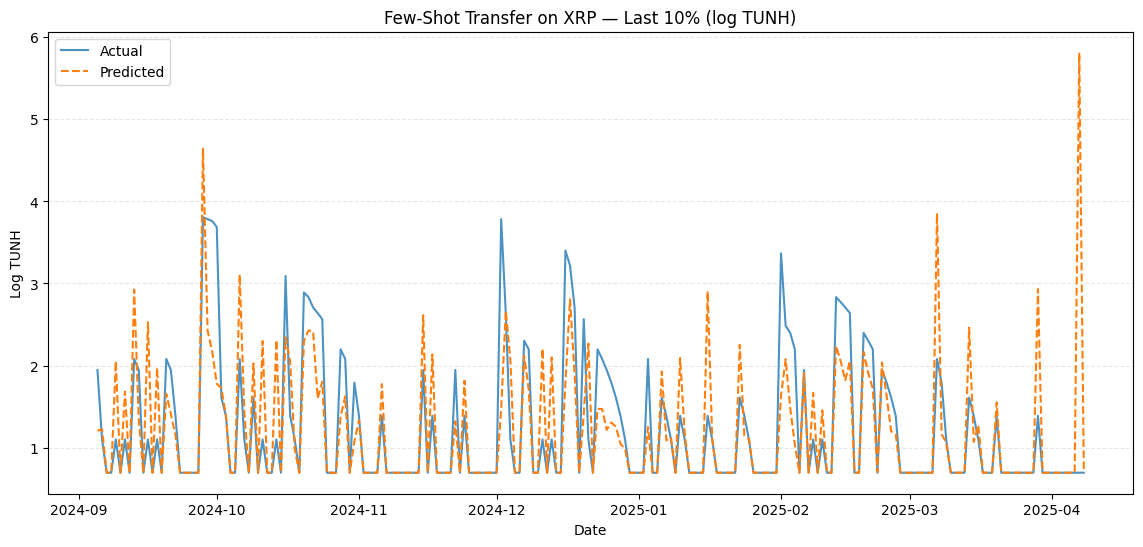

In [178]:
n_last = int(len(df_results) * 0.10)
df_last = df_results.tail(n_last)

plot_log_results(
    df_last,
    "Few-Shot Transfer on XRP — Last 10% (log TUNH)",
    "Log TUNH",
    'Plots/9. cross generalization/7a. btc_xrp_log.png'
)

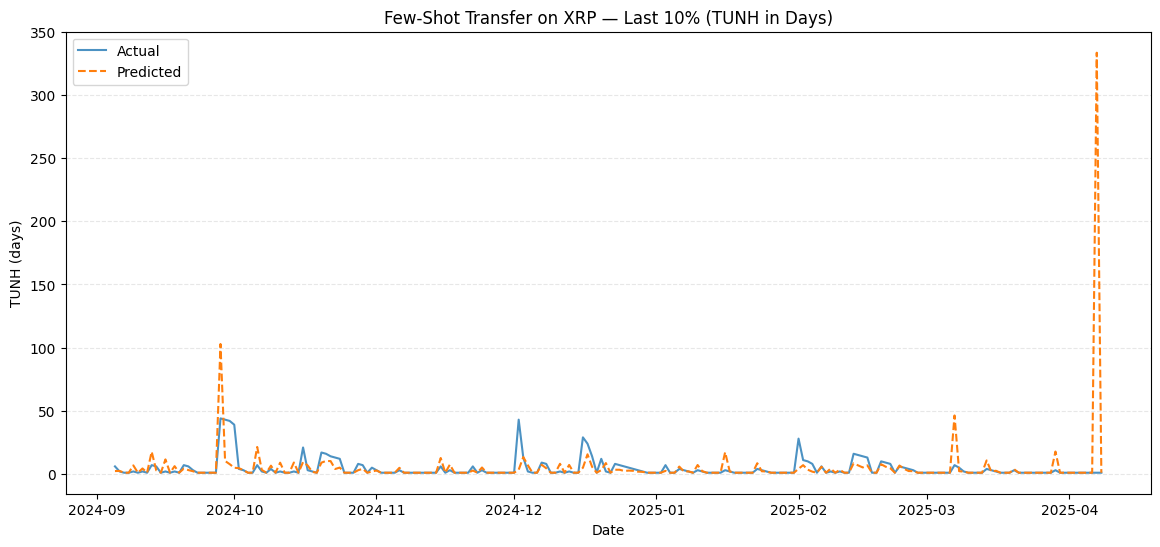

In [179]:
plot_results(
    df_last,
    "Few-Shot Transfer on XRP — Last 10% (TUNH in Days)",
    "TUNH (days)",
    'Plots/9. cross generalization/7b. btc_xrp.png'
)

## <span style='color:darkgreen'>**8) BTC VS ADA**</span>

### <span style='color:brown'>**Stage A:** Preprocessing</span>

In [180]:
df_ada= pd.read_csv("data/final_data_ADA.csv")
df_ada['coin'] = 'ADA'
df_ada = df_ada.rename(columns={"Date":"date"})
df_ada["date"] = pd.to_datetime(df_ada["date"])
df_ada['Date'] = df_ada['date'].dt.date
df_ada['date'] = df_ada['date'].dt.date
df_df_adaxrp = df_ada.set_index('Date')
print(df_ada.head())

         date      Open      High       Low     Close    Volume  tunh coin        Date
0  2017-11-09  0.025160  0.035060  0.025006  0.032053  18716200  17.0  ADA  2017-11-09
1  2017-11-10  0.032219  0.033348  0.026451  0.027119   6766780  16.0  ADA  2017-11-10
2  2017-11-11  0.026891  0.029659  0.025684  0.027437   5532220   9.0  ADA  2017-11-11
3  2017-11-12  0.027480  0.027952  0.022591  0.023977   7280250   4.0  ADA  2017-11-12
4  2017-11-13  0.024364  0.026300  0.023495  0.025808   4419440   1.0  ADA  2017-11-13


In [181]:
df_ada['tunh'] = df_ada['tunh'].ffill().bfill()

upper_limit = df_ada['tunh'].quantile(0.99)
df_ada['tunh_outlier'] = df_ada['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_ada['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_ada):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

df_ada = df_ada[~df_ada['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_ada.shape}")
df_ada.drop(columns=['tunh_outlier'], inplace=True)

df_ada['tunh_log'] = np.log1p(df_ada['tunh'])

df_ada = df_ada.drop(['tunh'], axis=1)

Detected 28 outliers (1.03%) above the 99th percentile (980.60 days).
Final data shape after outlier removal: (2681, 10)


In [182]:
df_ada_rolled = roll_time_series(df_ada, column_id="coin", column_sort="date",
                            max_timeshift=20, min_timeshift=5)

X_ada = extract_features(df_ada_rolled.drop("coin", axis=1), 
                    column_id="id", column_sort="date", column_value="tunh_log", 
                    impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


In [183]:
X_ada = X_ada.set_index(X_ada.index.map(lambda x: x[1]), drop=True)
X_ada.index.name = "last_date"

y_ada = df_ada.set_index("date").sort_index().tunh_log.shift(-1)

y_ada = y_ada.dropna()

y_ada = y_ada[y_ada.index.isin(X_ada.index)]
X_ada = X_ada[X_ada.index.isin(y_ada.index)]

### <span style='color:brown'>**Stage B:** Modelling</span>

#### **Step 1:** Split the data

In [184]:
# BTC → 80% train / 10% wf
split_idx = int(len(X_btc) * 0.80)
wf_end    = int(len(X_btc) * 0.90)

X_btc_tr = X_btc.iloc[:split_idx]
X_btc_wf = X_btc.iloc[split_idx:wf_end]

# ADA → first 10% few-shot, remaining 90% test
n_pax      = len(X_ada)
few_end    = int(n_pax * 0.10)
X_ada_few = X_ada.iloc[:few_end]
X_ada_te  = X_ada.iloc[few_end:]

# scale on BTC-train
scaler = StandardScaler().fit(X_btc_tr)
def scale(df): return pd.DataFrame(scaler.transform(df), index=df.index, columns=X_btc.columns)

X_tr  = scale(X_btc_tr)
X_wf  = scale(X_btc_wf)
X_few = scale(X_ada_few)
X_te  = scale(X_ada_te)

# align targets
y_tr  = y_btc.reindex(X_tr.index).dropna();  X_tr  = X_tr.loc[y_tr.index]
y_wf  = y_btc.reindex(X_wf.index).dropna();  X_wf  = X_wf.loc[y_wf.index]
y_few = y_ada.reindex(X_few.index).dropna();X_few = X_few.loc[y_few.index]
y_te  = y_ada.reindex(X_te.index).dropna(); X_te  = X_te.loc[y_te.index]

#### **Step 2:** Feature Selection

In [185]:
# 1) feature-select on BTC-train only
sel       = select_features(X_tr, y_tr).columns
X_tr_sel  = X_tr[sel]
X_wf_sel  = X_wf[sel]
X_few_sel = X_few[sel]
X_te_sel  = X_te[sel]

# 2) regime flags
reg_tr  = (y_tr.diff().shift(-1)  < 0).astype(int)
reg_wf  = (y_wf.diff().shift(-1)  < 0).astype(int)
reg_few = (y_few.diff().shift(-1) < 0).astype(int)
reg_te  = (y_te.diff().shift(-1)  < 0).astype(int)

# 3) expand interactions
X_tr_int  = expand_with_regime_interactions(X_tr_sel,  reg_tr)
X_wf_int  = expand_with_regime_interactions(X_wf_sel,  reg_wf)
X_few_int = expand_with_regime_interactions(X_few_sel, reg_few)
X_te_int  = expand_with_regime_interactions(X_te_sel,  reg_te)

#### **Step 3:** Pre-train on BTC

In [186]:
# pre-train
mlp.fit(
    X_tr_int.values, y_tr.values,
    validation_data=(X_wf_int.values, y_wf.values),
    epochs=100,
    batch_size=64,
    verbose=2
)

Epoch 1/100
67/67 - 1s - 9ms/step - loss: 0.2073 - val_loss: 0.4132
Epoch 2/100
67/67 - 0s - 4ms/step - loss: 0.1572 - val_loss: 0.4139
Epoch 3/100
67/67 - 0s - 4ms/step - loss: 0.1567 - val_loss: 0.4128
Epoch 4/100
67/67 - 0s - 4ms/step - loss: 0.1439 - val_loss: 0.4139
Epoch 5/100
67/67 - 0s - 4ms/step - loss: 0.1414 - val_loss: 0.4152
Epoch 6/100
67/67 - 0s - 4ms/step - loss: 0.1408 - val_loss: 0.4104
Epoch 7/100
67/67 - 0s - 4ms/step - loss: 0.1381 - val_loss: 0.4060
Epoch 8/100
67/67 - 0s - 4ms/step - loss: 0.1374 - val_loss: 0.4021
Epoch 9/100
67/67 - 0s - 4ms/step - loss: 0.1367 - val_loss: 0.4090
Epoch 10/100
67/67 - 0s - 4ms/step - loss: 0.1388 - val_loss: 0.4083
Epoch 11/100
67/67 - 0s - 4ms/step - loss: 0.1308 - val_loss: 0.4033
Epoch 12/100
67/67 - 0s - 4ms/step - loss: 0.1350 - val_loss: 0.4019
Epoch 13/100
67/67 - 0s - 5ms/step - loss: 0.1352 - val_loss: 0.4147
Epoch 14/100
67/67 - 0s - 4ms/step - loss: 0.1329 - val_loss: 0.4033
Epoch 15/100
67/67 - 0s - 4ms/step - loss: 

#### **Step 4:** Fine-tune on ADA

In [187]:
n = len(X_te_int)
n_ft = max(10, int(n*0.1))   # at least 10 samples
X_ft = X_te_int.iloc[:n_ft]
y_ft = y_te.iloc[:n_ft]
X_final = X_te_int.iloc[n_ft:]
y_final = y_te.iloc[n_ft:]

In [188]:
# lower learning-rate for fine-tuning
mlp.compile(optimizer=Adam(1e-4),
            loss="mean_absolute_error")

mlp.fit(
    X_ft.values, y_ft.values,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
    verbose=2
)

Epoch 1/50
12/12 - 1s - 49ms/step - loss: 0.4666 - val_loss: 0.3957
Epoch 2/50
12/12 - 0s - 5ms/step - loss: 0.4239 - val_loss: 0.3864
Epoch 3/50
12/12 - 0s - 5ms/step - loss: 0.4005 - val_loss: 0.3910
Epoch 4/50
12/12 - 0s - 5ms/step - loss: 0.3575 - val_loss: 0.4074
Epoch 5/50
12/12 - 0s - 5ms/step - loss: 0.3416 - val_loss: 0.4053
Epoch 6/50
12/12 - 0s - 5ms/step - loss: 0.3487 - val_loss: 0.3998
Epoch 7/50
12/12 - 0s - 5ms/step - loss: 0.3779 - val_loss: 0.3986
Epoch 8/50
12/12 - 0s - 5ms/step - loss: 0.3398 - val_loss: 0.3982
Epoch 9/50
12/12 - 0s - 5ms/step - loss: 0.3551 - val_loss: 0.3989
Epoch 10/50
12/12 - 0s - 5ms/step - loss: 0.3136 - val_loss: 0.4022
Epoch 11/50
12/12 - 0s - 6ms/step - loss: 0.3068 - val_loss: 0.4055
Epoch 12/50
12/12 - 0s - 5ms/step - loss: 0.3006 - val_loss: 0.4076
Epoch 13/50
12/12 - 0s - 5ms/step - loss: 0.3016 - val_loss: 0.4100
Epoch 14/50
12/12 - 0s - 6ms/step - loss: 0.2747 - val_loss: 0.4075
Epoch 15/50
12/12 - 0s - 5ms/step - loss: 0.2997 - val_l

#### **Step 5:** Evaluate on ADA

In [189]:
y_pred = mlp.predict(X_final.values).flatten()
MAE, RMSE, MAPE, DA = calculate_metrics(y_final.values, y_pred)
print(" Few-Shot ADA Final Test Metrics:")
print(f" MAE={MAE:.5f}, RMSE={RMSE:.5f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
 Few-Shot ADA Final Test Metrics:
 MAE=0.42611, RMSE=0.85814, MAPE=17.82%, DA=85.97%


In [190]:
df_results = pd.DataFrame({
    "Actual":    y_final.values,
    "Predicted": y_pred
}, index=y_final.index)

# Also add back “days” scale if you like
df_results["Actual_days"]    = np.expm1(df_results["Actual"])
df_results["Predicted_days"] = np.expm1(df_results["Predicted"])

print("\nTest Results (in days):")
print(df_results.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2019-04-30  1.098612   1.933464          2.0        5.913415
2019-05-01  0.693147   0.693128          1.0        0.999962
2019-05-02  0.693147   0.693128          1.0        0.999962
2019-05-03  2.079442   1.233283          7.0        2.432480
2019-05-04  0.693147   0.693128          1.0        0.999962


#### **Step 6:** Plot

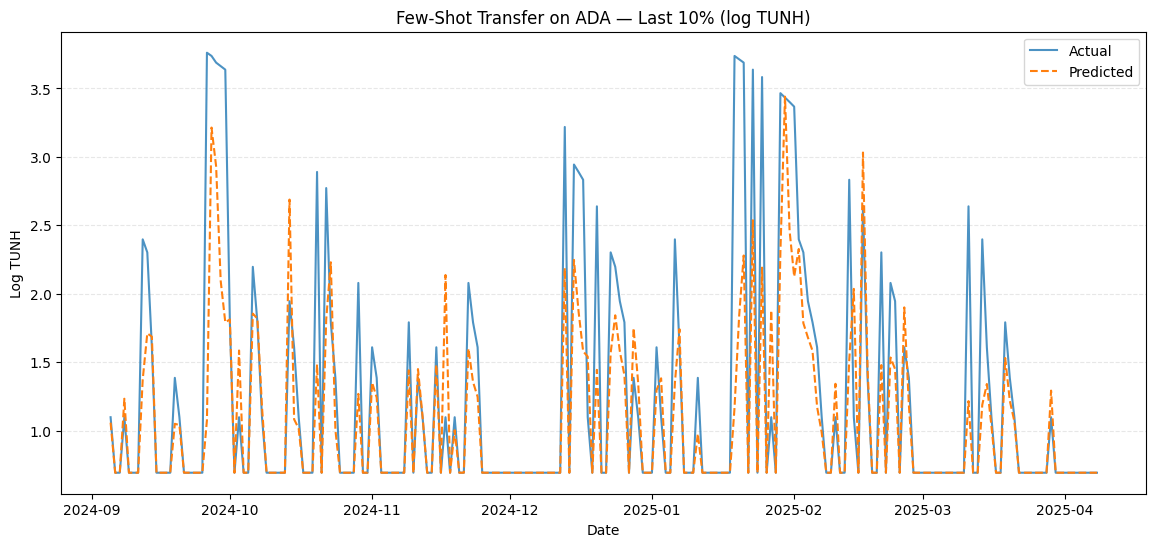

In [191]:
n_last = int(len(df_results) * 0.10)
df_last = df_results.tail(n_last)

plot_log_results(
    df_last,
    "Few-Shot Transfer on ADA — Last 10% (log TUNH)",
    "Log TUNH",
    'Plots/9. cross generalization/8a. btc_ada_log.png'
)

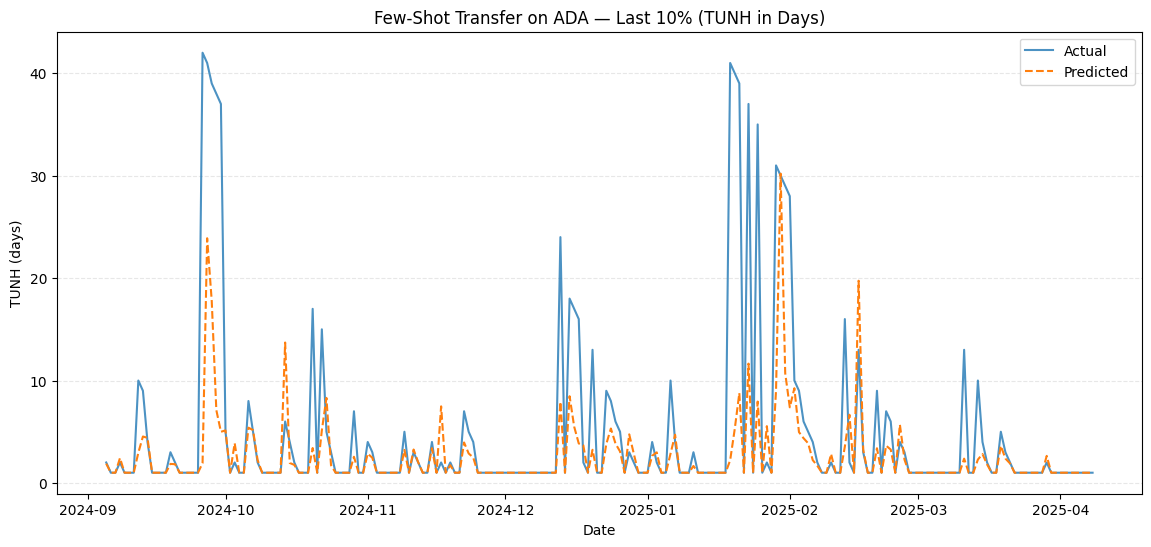

In [192]:
plot_results(
    df_last,
    "Few-Shot Transfer on ADA — Last 10% (TUNH in Days)",
    "TUNH (days)",
    'Plots/9. cross generalization/8b. btc_ada.png'
)

## <span style='color:darkgreen'>**9) BTC VS DOGE**</span>

### <span style='color:brown'>**Stage A:** Preprocessing</span>

In [193]:
df_doge= pd.read_csv("data/final_data_doge.csv")
df_doge['coin'] = 'DOGE'
df_doge = df_doge.rename(columns={"Date":"date"})
df_doge["date"] = pd.to_datetime(df_doge["date"])
df_doge['Date'] = df_doge['date'].dt.date
df_doge['date'] = df_doge['date'].dt.date
df_doge = df_doge.set_index('Date')
print(df_doge.head())

                  date      Open      High       Low     Close   Volume  tunh  coin
Date                                                                               
2017-11-09  2017-11-09  0.001207  0.001415  0.001181  0.001415  6259550   1.0  DOGE
2017-11-10  2017-11-10  0.001421  0.001431  0.001125  0.001163  4246520  11.0  DOGE
2017-11-11  2017-11-11  0.001146  0.001257  0.001141  0.001201  2231080   4.0  DOGE
2017-11-12  2017-11-12  0.001189  0.001210  0.001002  0.001038  3288960   1.0  DOGE
2017-11-13  2017-11-13  0.001046  0.001212  0.001019  0.001211  2481270   1.0  DOGE


In [194]:
df_doge['tunh'] = df_doge['tunh'].ffill().bfill()

upper_limit = df_doge['tunh'].quantile(0.99)
df_doge['tunh_outlier'] = df_doge['tunh'] > upper_limit

# Calculate total clearly
num_outliers = df_doge['tunh_outlier'].sum()
print(f"Detected {num_outliers} outliers ({100 * num_outliers / len(df_doge):.2f}%) above the 99th percentile ({upper_limit:.2f} days).")

df_doge = df_doge[~df_doge['tunh_outlier']].copy()
print(f"Final data shape after outlier removal: {df_doge.shape}")
df_doge.drop(columns=['tunh_outlier'], inplace=True)

df_doge['tunh_log'] = np.log1p(df_doge['tunh'])

df_doge = df_doge.drop(['tunh'], axis=1)

Detected 28 outliers (1.03%) above the 99th percentile (1080.92 days).
Final data shape after outlier removal: (2681, 9)


In [195]:
df_doge_rolled = roll_time_series(df_doge, column_id="coin", column_sort="date",
                            max_timeshift=20, min_timeshift=5)

X_doge = extract_features(df_doge_rolled.drop("coin", axis=1), 
                    column_id="id", column_sort="date", column_value="tunh_log", 
                    impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


In [196]:
X_doge = X_doge.set_index(X_doge.index.map(lambda x: x[1]), drop=True)
X_doge.index.name = "last_date"

y_doge = df_doge.set_index("date").sort_index().tunh_log.shift(-1)

y_doge = y_doge.dropna()

y_doge = y_doge[y_doge.index.isin(X_doge.index)]
X_doge = X_doge[X_doge.index.isin(y_doge.index)]

### <span style='color:brown'>**Stage B:** Modelling</span>

#### **Step 1:** Split the data

In [197]:
# BTC → 80% train / 10% wf
split_idx = int(len(X_btc) * 0.80)
wf_end    = int(len(X_btc) * 0.90)

X_btc_tr = X_btc.iloc[:split_idx]
X_btc_wf = X_btc.iloc[split_idx:wf_end]

# DOGE → first 10% few-shot, remaining 90% test
n_pax      = len(X_doge)
few_end    = int(n_pax * 0.10)
X_doge_few = X_doge.iloc[:few_end]
X_doge_te  = X_doge.iloc[few_end:]

# scale on BTC-train
scaler = StandardScaler().fit(X_btc_tr)
def scale(df): return pd.DataFrame(scaler.transform(df), index=df.index, columns=X_btc.columns)

X_tr  = scale(X_btc_tr)
X_wf  = scale(X_btc_wf)
X_few = scale(X_doge_few)
X_te  = scale(X_doge_te)

# align targets
y_tr  = y_btc.reindex(X_tr.index).dropna();  X_tr  = X_tr.loc[y_tr.index]
y_wf  = y_btc.reindex(X_wf.index).dropna();  X_wf  = X_wf.loc[y_wf.index]
y_few = y_doge.reindex(X_few.index).dropna();X_few = X_few.loc[y_few.index]
y_te  = y_doge.reindex(X_te.index).dropna(); X_te  = X_te.loc[y_te.index]

#### **Step 2:** Feature Selection

In [198]:
# 1) feature-select on BTC-train only
sel       = select_features(X_tr, y_tr).columns
X_tr_sel  = X_tr[sel]
X_wf_sel  = X_wf[sel]
X_few_sel = X_few[sel]
X_te_sel  = X_te[sel]

# 2) regime flags
reg_tr  = (y_tr.diff().shift(-1)  < 0).astype(int)
reg_wf  = (y_wf.diff().shift(-1)  < 0).astype(int)
reg_few = (y_few.diff().shift(-1) < 0).astype(int)
reg_te  = (y_te.diff().shift(-1)  < 0).astype(int)

# 3) expand interactions
X_tr_int  = expand_with_regime_interactions(X_tr_sel,  reg_tr)
X_wf_int  = expand_with_regime_interactions(X_wf_sel,  reg_wf)
X_few_int = expand_with_regime_interactions(X_few_sel, reg_few)
X_te_int  = expand_with_regime_interactions(X_te_sel,  reg_te)

#### **Step 3:** Pre-train on BTC

In [199]:
# pre-train
mlp.fit(
    X_tr_int.values, y_tr.values,
    validation_data=(X_wf_int.values, y_wf.values),
    epochs=100,
    batch_size=64,
    verbose=2
)

Epoch 1/100
67/67 - 1s - 8ms/step - loss: 0.1297 - val_loss: 0.4015
Epoch 2/100
67/67 - 0s - 4ms/step - loss: 0.1274 - val_loss: 0.4172
Epoch 3/100
67/67 - 0s - 4ms/step - loss: 0.1244 - val_loss: 0.4052
Epoch 4/100
67/67 - 0s - 4ms/step - loss: 0.1243 - val_loss: 0.4073
Epoch 5/100
67/67 - 0s - 4ms/step - loss: 0.1268 - val_loss: 0.4043
Epoch 6/100
67/67 - 0s - 4ms/step - loss: 0.1225 - val_loss: 0.4064
Epoch 7/100
67/67 - 0s - 4ms/step - loss: 0.1272 - val_loss: 0.4023
Epoch 8/100
67/67 - 0s - 4ms/step - loss: 0.1301 - val_loss: 0.4088
Epoch 9/100
67/67 - 0s - 4ms/step - loss: 0.1254 - val_loss: 0.4149
Epoch 10/100
67/67 - 0s - 4ms/step - loss: 0.1287 - val_loss: 0.4027
Epoch 11/100
67/67 - 0s - 4ms/step - loss: 0.1250 - val_loss: 0.3979
Epoch 12/100
67/67 - 0s - 4ms/step - loss: 0.1271 - val_loss: 0.4128
Epoch 13/100
67/67 - 0s - 4ms/step - loss: 0.1296 - val_loss: 0.4057
Epoch 14/100
67/67 - 0s - 4ms/step - loss: 0.1273 - val_loss: 0.4069
Epoch 15/100
67/67 - 0s - 4ms/step - loss: 

#### **Step 4:** Fine-tune on DOGE

In [200]:
n = len(X_te_int)
n_ft = max(10, int(n*0.1))   # at least 10 samples
X_ft = X_te_int.iloc[:n_ft]
y_ft = y_te.iloc[:n_ft]
X_final = X_te_int.iloc[n_ft:]
y_final = y_te.iloc[n_ft:]

In [201]:
# lower learning-rate for fine-tuning
mlp.compile(optimizer=Adam(1e-4),
            loss="mean_absolute_error")

mlp.fit(
    X_ft.values, y_ft.values,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
    verbose=2
)

Epoch 1/50
12/12 - 1s - 49ms/step - loss: 0.8345 - val_loss: 0.4815
Epoch 2/50
12/12 - 0s - 5ms/step - loss: 0.7518 - val_loss: 0.4690
Epoch 3/50
12/12 - 0s - 5ms/step - loss: 0.7224 - val_loss: 0.4659
Epoch 4/50
12/12 - 0s - 5ms/step - loss: 0.7242 - val_loss: 0.4654
Epoch 5/50
12/12 - 0s - 5ms/step - loss: 0.6755 - val_loss: 0.4663
Epoch 6/50
12/12 - 0s - 5ms/step - loss: 0.6712 - val_loss: 0.4640
Epoch 7/50
12/12 - 0s - 5ms/step - loss: 0.6983 - val_loss: 0.4627
Epoch 8/50
12/12 - 0s - 5ms/step - loss: 0.6307 - val_loss: 0.4597
Epoch 9/50
12/12 - 0s - 6ms/step - loss: 0.6515 - val_loss: 0.4573
Epoch 10/50
12/12 - 0s - 5ms/step - loss: 0.6405 - val_loss: 0.4630
Epoch 11/50
12/12 - 0s - 5ms/step - loss: 0.5916 - val_loss: 0.4651
Epoch 12/50
12/12 - 0s - 6ms/step - loss: 0.5919 - val_loss: 0.4576
Epoch 13/50
12/12 - 0s - 5ms/step - loss: 0.5710 - val_loss: 0.4574
Epoch 14/50
12/12 - 0s - 6ms/step - loss: 0.5718 - val_loss: 0.4525
Epoch 15/50
12/12 - 0s - 5ms/step - loss: 0.5840 - val_l

#### **Step 5:** Evaluate on DOGE

In [202]:
y_pred = mlp.predict(X_final.values).flatten()
MAE, RMSE, MAPE, DA = calculate_metrics(y_final.values, y_pred)
print(" Few-Shot DOGE Final Test Metrics:")
print(f" MAE={MAE:.5f}, RMSE={RMSE:.5f}, MAPE={MAPE:.2f}%, DA={DA:.2f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
 Few-Shot DOGE Final Test Metrics:
 MAE=0.44576, RMSE=0.83405, MAPE=19.56%, DA=87.63%


In [203]:
df_results = pd.DataFrame({
    "Actual":    y_final.values,
    "Predicted": y_pred
}, index=y_final.index)

# Also add back “days” scale if you like
df_results["Actual_days"]    = np.expm1(df_results["Actual"])
df_results["Predicted_days"] = np.expm1(df_results["Predicted"])

print("\nTest Results (in days):")
print(df_results.head())


Test Results (in days):
              Actual  Predicted  Actual_days  Predicted_days
last_date                                                   
2019-04-12  1.098612   1.300885          2.0        2.672546
2019-04-13  0.693147   0.693107          1.0        0.999919
2019-04-14  1.386294   1.854144          3.0        5.386228
2019-04-15  0.693147   0.693107          1.0        0.999919
2019-04-16  0.693147   0.693107          1.0        0.999919


#### **Step 6:** Plot

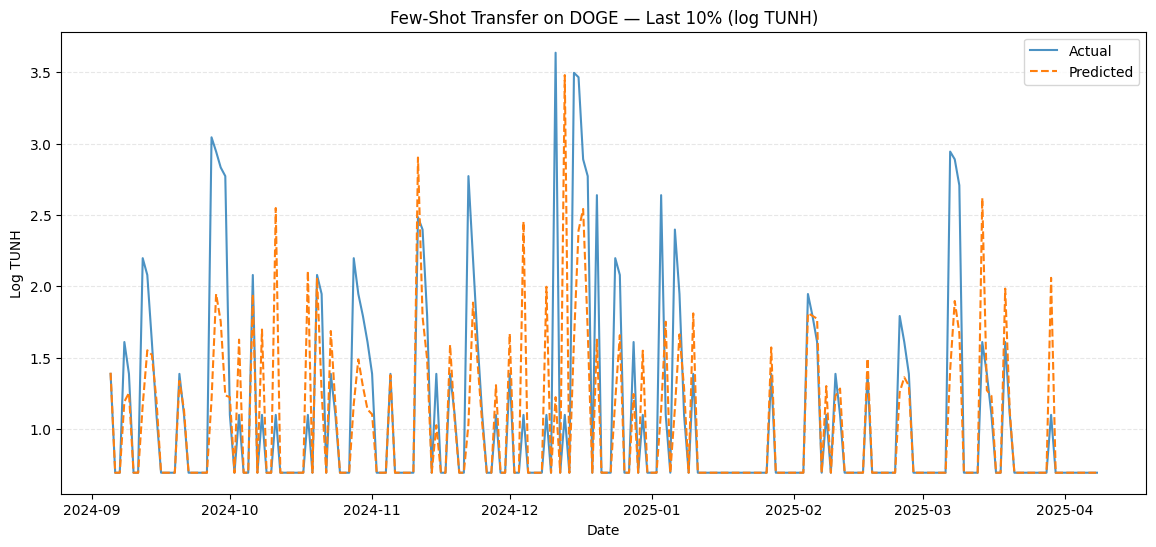

In [204]:
n_last = int(len(df_results) * 0.10)
df_last = df_results.tail(n_last)

plot_log_results(
    df_last,
    "Few-Shot Transfer on DOGE — Last 10% (log TUNH)",
    "Log TUNH",
    'Plots/9. cross generalization/9a. btc_doge_log.png'
)

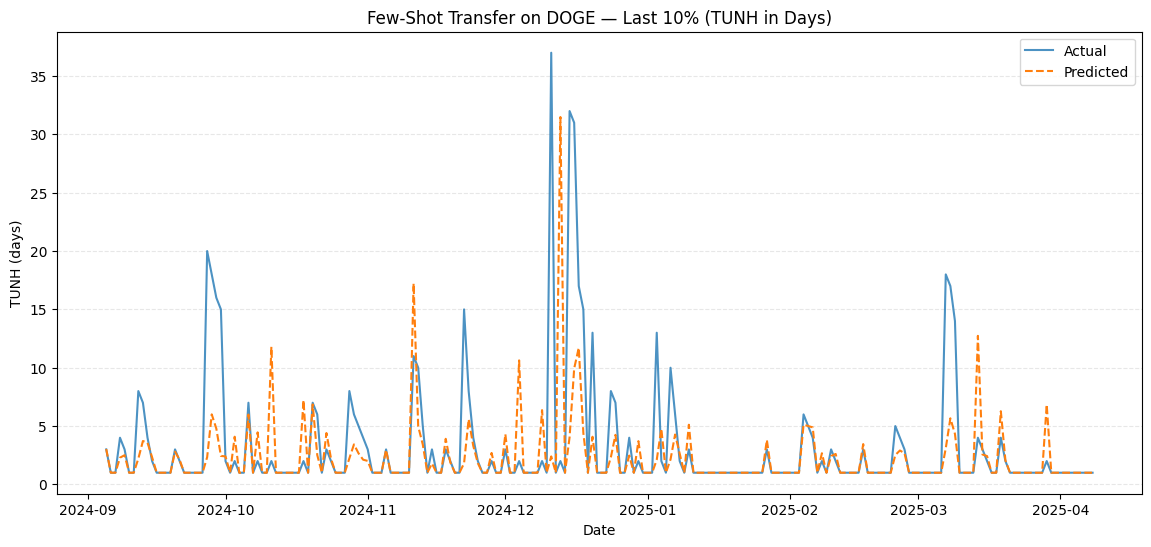

In [205]:
plot_results(
    df_last,
    "Few-Shot Transfer on DOGE — Last 10% (TUNH in Days)",
    "TUNH (days)",
    'Plots/9. cross generalization/9b. btc_doge.png'
)